In [2]:
import numpy as np
from scipy.optimize import minimize_scalar
from scipy.stats import t as student_t
from scipy import integrate
from scipy.stats import norm
from sklearn.metrics import adjusted_rand_score  
import matplotlib.pyplot as plt
import math
from typing import Callable, Tuple, List, Dict, Literal, Optional

In [3]:
from tqdm import tqdm

In [4]:
from statsmodels import robust 

In [5]:
import matplotlib.pyplot as plt
import pandas as pd 

# I- Dynamic programming functions

In [6]:

QuadPiece = Tuple[float, float, float, float, float, int]
#quadpiece is a tuple containing:
#first float a = left bound of the interval
#second flat b: right bound of the interval
#3 other floats A,B,C = coefficients of the quadratic polynom on interval [a,b]: AX^2+BX=c 
#last int tau = index of last changepoint 


#algorithm 3 from pseudocode 
def rfpop_algorithm3_min_over_theta(Qt_pieces: List[QuadPiece]):
    best_val = float('inf')
    best_tau = 0
    for (a,b,A,B,C,tau) in Qt_pieces:
        # computing min of Q_t(theta) over segment (a,b]
        if abs(A) < 1e-16:
            #if the coefficient associated with x^2 of the quadratic function is =0 then the function is linear (B!=0) or constant (B=0)
            #hence in this case min value of Q_t(theta) is on the boundaries of the segment
            left = a + 1e-12 #because segment does not contain a 
            right = b
            vleft = A*left*left + B*left + C
            vright = A*right*right + B*right + C
            theta_star = left if vleft <= vright else right
        else: #if A!=0 then Q_t(theta) =A theta^2 + B theta + C on segment (a,b] 
            #so minimizer is -B/2A   (each quadratic is assumed convex, not concave so not a maximizer)
            theta_star = -B / (2.0 * A)
            #we need to ensure the minimizer is in (a,b]
            if theta_star <= a: 
                theta_star = a + 1e-12
            elif theta_star > b:
                theta_star = b
        val = A*theta_star*theta_star + B*theta_star + C
        if val < best_val:
            best_val = val
            best_tau = tau
    return float(best_val), int(best_tau)

#algorithm 2 from appendix D 
def rfpop_algorithm2_add_Qstar_and_gamma(Qstar_pieces: List[QuadPiece], 
                                         #Q_star est représenté sous forme [ (a1,b1,A1,B1,C1,tau1), (a2,b2,A2,B2,C2,tau2), ..., ]
                                         gamma_pieces: List[QuadPiece]):

    out: List[QuadPiece] = []
    i = 0
    j = 0
    while i < len(Qstar_pieces) and j < len(gamma_pieces):
        pa, pb, pA, pB, pC, p_tau = Qstar_pieces[i]
        ga, gb, gA, gB, gC, g_tau = gamma_pieces[j]

        #new interval 
        a = max(pa, ga)
        b = min(pb, gb)
        
        # sum of Q_star and gamma on the new interval
        newA = pA + gA
        newB = pB + gB
        newC = pC + gC
        # tau comes from Q* (p_tau) 
        out.append((a, b, newA, newB, newC, p_tau))
        # avancer indices selon bornes
        if abs(b - pb) < 1e-12:
            i += 1
        if abs(b - gb) < 1e-12:
            j += 1
        # to avoid infinite loop
        if (i < len(Qstar_pieces) and j < len(gamma_pieces)) and a >= b - 1e-14 and abs(b - Qstar_pieces[i][1]) > 1e-12 and abs(b - gamma_pieces[j][1]) > 1e-12:
            break
    # to do as they say on page 12 and merge identical neighbouring intervals
    if not out:
        return []
    merged: List[QuadPiece] = [out[0]]
    for pc in out[1:]:
        a,b,A,B,C,tau = pc
        ma,mb,mA,mB,mC,mtau = merged[-1]
        if (abs(A - mA) < 1e-14 and abs(B - mB) < 1e-14 and abs(C - mC) < 1e-9 and tau == mtau and abs(a - mb) < 1e-9):
            merged[-1] = (ma, b, mA, mB, mC, mtau)
        else:
            merged.append(pc)
    return merged



#algorithm 4

def rfpop_algorithm4_prune_compare_to_constant(Qt_pieces: List[QuadPiece],
                                               Qt_val: float, #Qt_val + beta = the constant C in appendix
                                               beta: float,
                                               t_index_for_new: int):
   
    thr = Qt_val + beta
    out: List[QuadPiece] = []

    #goes through the Nt intervals of Qt
    for (a,b,A,B,C,tau) in Qt_pieces:
        #finds the roots of Q_t(x) - C ie the roots of A x^2 + B x + (C - thr) = 0 on [a,b]
        # BEWARE: source of confuction: thr is the equivalent of the constant C in the pseudocode of the paper
        # C is the last coefficient of the quadratic function, not the constant C defined in the pseudocode 
        roots: List[float] = []
        if abs(A) < 1e-16:
            # if the quadratic function is linear or constant: B x + (C - thr) = 0
            if abs(B) > 1e-16:
                x = -(C - thr) / B
                #we need to ensure root x is in interval [a,b] otherwise we don't care about it 
                if x + 1e-12 >= a and x - 1e-12 <= b:
                    x_clamped = max(min(x, b), a) #to ensure the root is indeed within the interval and have no problems of numerical errors later: we need to sort the roots it could do weird things later if we don't do that
                    roots.append(x_clamped)
        else:
            #if the function is indeed quadratic we compute delta and roots 
            D = B*B - 4.0*A*(C - thr)
            if D >= -1e-14:
                D = max(D, 0.0)
                sqrtD = math.sqrt(D)
                x1 = (-B - sqrtD) / (2.0*A)
                x2 = (-B + sqrtD) / (2.0*A)
                for x in (x1, x2):
                    if x + 1e-12 >= a and x - 1e-12 <= b:
                        x_clamped = max(min(x, b), a)
                        # avoid duplicates if delta D = 0 we get 2 times the same root 
                        if not any(abs(x_clamped - r) < 1e-9 for r in roots):
                            roots.append(x_clamped)
        roots.sort()
        # create vector [a, r1, r2,  b]
        breaks = [a] + roots + [b]
        for k in range(len(breaks)-1):
            lo = breaks[k]
            hi = breaks[k+1]
            mid = (lo + hi) / 2.0
            #here we evaluate the polynom A*mid*mid + B*mid + C - thr on each subsegment [a,root_1], [root_1,root_2],[root_2,b]
            #on each of these subsegment this polynom has the same sign as each bound of a subsegment is a root 
            #so we can pick an arbitrary value like the middle to see the sign of the polynom on this subsegment
            val_mid = A*mid*mid + B*mid + C - thr 

            #if polynom is negative then Q_t(theta)<constant so we keep Q_t(theta) = A*theta^2 + B*theta + C
            if val_mid <= 1e-12:
                # keep Q_t on this subsegment
                out.append((lo, hi, A, B, C, tau))
            else:
                # keep constant thr in this subsegment and set a changepoint at t_index_for_new 
                out.append((lo, hi, 0.0, 0.0, thr, t_index_for_new))
    # fusionner adjacences égales
    if not out:
        return []
    merged: List[QuadPiece] = [out[0]]
    for pc in out[1:]:
        a,b,A,B,C,tau = pc
        ma,mb,mA,mB,mC,mtau = merged[-1]
        if (abs(A - mA) < 1e-14 and abs(B - mB) < 1e-14 and abs(C - mC) < 1e-9 and tau == mtau and abs(a - mb) < 1e-9):
            merged[-1] = (ma, b, mA, mB, mC, mtau)
        else:
            merged.append(pc)
    return merged



#algorithm 1
def rfpop_algorithm1_main(y: List[float], gamma_builder, beta: float):

    y_arr = np.asarray(y, dtype=float)
    n = len(y_arr)

    lo = float(np.min(y_arr)) - 1.0 #we add -1 and +1 to ensure there is no numeric problem with python approximations for foats 
    hi = float(np.max(y_arr)) + 1.0
    Qstar = [(lo, hi, 0.0, 0.0, 0.0, 0)]  # Q*_1
    cp_tau = [0] * n
    Qt_vals = [0.0] * n
    for t_idx in range(n):
        # Sub-routine 2 : Qt = Q*_t + gamma(y_t)
        gamma_pcs = gamma_builder(float(y_arr[t_idx]), t_idx)
        Qt_pcs = rfpop_algorithm2_add_Qstar_and_gamma(Qstar, gamma_pcs)
        # Sub-routine 3 : min over theta Qt
        Qt_val, tau_t = rfpop_algorithm3_min_over_theta(Qt_pcs)
        cp_tau[t_idx] = tau_t
        Qt_vals[t_idx] = Qt_val
        # Sub-routine 4 : compute Q*_{t+1}
        Qstar = rfpop_algorithm4_prune_compare_to_constant(Qt_pcs, Qt_val, beta, t_idx)
    return cp_tau, Qt_vals, Qstar



QuadPiece = Tuple[float, float, float, float, float, int]
INF = 1e18  # borne pratique pour "infty"
EPS = 1e-12

def gamma_builder_L2(y: float, tau_for_new: int) -> List[QuadPiece]:
    """
    gamma(y,theta) = (y - theta)^2 = theta^2 - 2*y*theta + y^2
    Single quadratic piece on (-INF, INF].
    """
    A = 1.0
    B = -2.0 * y
    C = y * y
    return [(-INF, INF, A, B, C, tau_for_new)]

def gamma_builder_biweight(y: float, K: float, tau_for_new: int) -> List[QuadPiece]:
    """ :
      gamma(y,theta) = (y-theta)^2   if |y-theta| <= K
                      = K^2         otherwise
    Can be defined as 3 different quadratic functions over 3 segments :
      (-INF, y-K]       : constant K^2
      (y-K, y+K]        : quadratic (y-theta)^2
      (y+K, INF)        : constant K^2
    """
    A_q = 1.0
    B_q = -2.0 * y
    C_q = y * y
    constC = float(K * K)
    return [
        (-INF, y - K, 0.0, 0.0, constC, tau_for_new),
        (y - K, y + K, A_q, B_q, C_q, tau_for_new),
        (y + K, INF, 0.0, 0.0, constC, tau_for_new)
    ]


def gamma_builder_huber(y: float, K: float, tau_for_new: int) -> List[QuadPiece]:
    """
    Huber loss with threshold K:
      gamma(y,theta) = (y-theta)^2                     if |y-theta| <= K
                      = 2*K*|y-theta| - K^2           if |y-theta| > K
    
    Can be defined as 3 quadratic functions over 3 segments  
    (-INF, y-K] :  2*K*(y-theta) - K^2 = -2K*theta + (2K*y - K^2)
    (y-K, y+K]: (y-theta)^2 = theta^2 - 2y theta + y^2
    (y+K, INF): 2*K*(theta-y) - K^2 = 2K*theta + (-2K*y - K^2)
    """
    # central quadratic
    A_q = 1.0
    B_q = -2.0 * y
    C_q = y * y
    # left linear: B_left * theta + C_left  where B_left = -2K, C_left = 2K*y - K^2
    B_left = -2.0 * K
    C_left = 2.0 * K * y - K * K
    # right linear: B_right * theta + C_right where B_right = 2K, C_right = -2K*y - K^2
    B_right = 2.0 * K
    C_right = -2.0 * K * y - K * K
    return [
        (-INF, y - K, 0.0, B_left, C_left, tau_for_new),   # linear = A=0
        (y - K, y + K, A_q, B_q, C_q, tau_for_new),       # quadratic
        (y + K, INF, 0.0, B_right, C_right, tau_for_new) # linear = A=0
    ]

def gamma_builder_L1(y: float, tau_for_new: int) -> List[QuadPiece]:
    """
    L1 loss: gamma(y,theta) = |y - theta|
    Piecewise-linear
      (-INF, y) :  y - theta = (-1)*theta + y
      (y, INF): theta - y = (+1)*theta + (-y)

    """
    # left piece: (-INF, y] -> -theta + y  => A=0, B=-1, C=y
    # right piece: (y, INF] -> theta - y  => A=0, B=1,  C=-y
    return [
        (-INF, y, 0.0, -1.0, float(y), tau_for_new),
        (y, INF, 0.0,  1.0, float(-y), tau_for_new)
    ]




## II - Data for experiments 

In [7]:
def generate_scenarios():

    np.random.seed(42) 

    # Fonction auxiliaire pour le bruit t-student
    def t_noise(n, df=5, sigma=1.0):
        return np.random.standard_t(df, size=n) * sigma

    #scenario 1
    n1 = 2048
    t = np.arange(n1) / n1
    pos = np.array([0.1, 0.13, 0.15, 0.23, 0.25, 0.40, 0.44, 0.65, 0.76, 0.78, 0.81])
    h = np.array([4, -5, 3, -4, 5, -4.2, 2.1, 4.3, -3.1, 2.1, -4.2])
    sig1 = np.zeros(n1)
    for p, hi in zip(pos, h):
        sig1[int(p * n1):] += hi
    sig1 = sig1 * 3.5 
    y1 = sig1 + t_noise(n1, df=5, sigma=5.0) 

    #Scenario 2
    n2 = 512
    sig2 = np.zeros(n2)
    segments_fms = [
        (0, 200, -0.2), (200, 220, 0.2), (220, 240, 1.2), (240, 260, -0.8),
        (260, 280, 0.5), (280, 400, -0.1), (400, 420, 0.8), (420, 512, -0.3)
    ]
    for start, end, val in segments_fms:
        sig2[start:end] = val
    y2 = sig2 + t_noise(n2, df=5, sigma=0.3)


    # --- Scenario 2'
    # same signal but less noise
    y2_prime = sig2 + t_noise(n2, df=5, sigma=0.2)

    #Scenario 3
    # short and long segments
    n3 = 512
    sig3 = np.zeros(n3)
    curr = 0
    mu = 0
    #alternate randomly between long and short segments 
    while curr < n3:
        length = np.random.choice([10, 20, 80, 100])
        val = np.random.normal(0, 2)
        end = min(curr + length, n3)
        sig3[curr:end] = val
        curr = end

    y3 = sig3 + t_noise(n3, df=5, sigma=0.3)


    #Scenario 4 saw tooth 
    n4 = 240
    sig4 = np.zeros(n4)
    n_teeth = 10
    len_tooth = n4 // n_teeth 
    for i in range(n_teeth):
        if i % 2 == 1:
            sig4[i*len_tooth : (i+1)*len_tooth] = 1.0
    y4 = sig4 + t_noise(n4, df=5, sigma=0.3)

    #Scenario 5: Stairs 
    n5 = 150
    sig5 = np.zeros(n5)
    n_steps = 10
    len_step = n5 // n_steps 
    for i in range(n_steps):
        sig5[i*len_step : (i+1)*len_step] = (i + 1) * 1.5
    # Bruit
    y5 = sig5 + t_noise(n5, df=5, sigma=0.3)

    dic1 = {
        "Scenario 1": y1,
        "Scenario 2": y2,
        "Scenario 2'": y2_prime,
        "Scenario 3": y3,
        "Scenario 4": y4,
        "Scenario 5": y5}
    dic2 = {
        "Scenario 1": sig1,
        "Scenario 2": sig2,
        "Scenario 2'": sig2,
        "Scenario 3": sig3,
        "Scenario 4": sig4,
        "Scenario 5": sig5}
    return dic1,dic2



data, true_signals = generate_scenarios()


## III- Reproducing the experiments 

We should pick K and beta optimally as in the paper: 
$$K = \begin{cases}
                3 \hat \sigma \quad \text{for the biweight loss}, \\
                1.345 \hat \sigma \quad \text{for the huber loss}
            \end{cases} $$


Where $\hat \sigma$ is the median absolute deviation of the differenced time series. 


$$ \beta = 2 \hat \sigma^2\text{log}(n) \mathbb E(\phi(Z)^2)$$

Where $\phi$ is the gradient of the loss function and $Z \sim \mathcal N(0,1)$

In [8]:
def biweight_phi(z, K_std):
    return 2*z if abs(z) <= K_std else 0.0

def huber_phi(z, K_std):
    return 2*z if abs(z) <= K_std else 2*K_std*np.sign(z)

def compute_penalty_beta(y, loss):
    ys = pd.Series(y)
    sigma = robust.mad(ys.diff().dropna())/np.sqrt(2)
    n = len(y)
    # return 2 * sigma**2 * np.log(n)

    if loss == 'l2':
        return 2 * sigma**2 * np.log(n)

    elif loss == 'biweight':
        K_std = 3.0  # K / sigma
        E_phi2, _ = integrate.quad(
            lambda z: (biweight_phi(z, K_std)**2) * norm.pdf(z),
            -np.inf, np.inf
        )
        return 2 * sigma**2 * np.log(n)   * E_phi2

    elif loss == 'huber':
        K_std = 1.345
        E_phi2, _ = integrate.quad(
            lambda z: (huber_phi(z, K_std)**2) * norm.pdf(z),
            -np.inf, np.inf
        )
        return 2 * sigma**2 * np.log(n) * E_phi2

    elif loss == 'l1':
        return np.log(n)
    

    # #function to compute parameter K
def compute_loss_bound_K(y,
             loss: Literal['huber','biweight']):
    ys =pd.Series(y)
    mad = robust.mad(ys.diff().dropna())/np.sqrt(2)
    if loss == "biweight":
        return 3*mad
    elif loss == 'huber':
        return 1.345*mad 


In [9]:
# #function to compute parameter K
# def compute_loss_bound_K(y,
#              loss: Literal['huber','biweight']):
#     ys =pd.Series(y)
#     mad = robust.mad(ys.diff().dropna())
#     if loss == "biweight":
#         return 3*mad
#     elif loss == 'huber':
#         return 1.345*mad 



# #functions necessary to compute optimal beta according to schwarz information criteria 
# #we now need to introduce a few auxiliary functions to compute the optimal beta from the paper:
# #indeed we need to compute E(phi(Z)^2) where phi is the gradient of the loss function used: this implies doing numerical approximations

# # Huber loss gradient definition for integration
# def huber_gradient(z, K):
#     return z if abs(z) <= K else math.copysign(K, z)

# # biweight loss gradient definition for integration
# def biweight_gradient(z, K):
#     return z if abs(z) <= K else 0


# # function to integrate that will be used to approximate E(phi(Z)^2)
# def integrand_phi2(phi_func, z, K):
#     return (phi_func(z, K)**2) * norm.pdf(z)



# # def compute_E_phi2(phi_func, #either huber_gradient or biweight_gradient 
# #                    K):
# #     E_phi2, _ = integrate.quad(lambda z: integrand_phi2(phi_func, z, K), -np.inf, np.inf,
# #                                 epsabs=1e-9, epsrel=1e-9, limit=200)
    
# #     return float(E_phi2)

# def compute_penalty_beta(y,
#                          loss: Literal['huber','biweight','l2','l1']
#                          ):
    
#     """
#     page 16 of the paper: optimal beta according to schwarz information criteria is beta = 2 \hat{\sigma}^2 log(n) E(phi(Z)^2)
#     where:
#     \hat{\sigma} = median absolute deviation of the differentiated time series y = estimator of variance of the noise
#     n = length of time series 
#     phi = gradient of the loss function used 
#     Z = a N(0,I)

#     for L2 loss p(z) = z^2/2, phi(z)=z so E(phi(Z)^2) = E(Z^2) = 1
#     for huber and biweight loss, E(phi(Z)^2) is approximated numerically 
#     for L1 loss we can't apply the formula of the paper as E(phi(Z)^2) = 0 so we arbitrarly pick beta = log(n)
#     """
#     ys =pd.Series(y)
#     mad = robust.mad(ys.diff().dropna())

#     if loss == 'l2':
#         return 2*mad*mad*np.log(len(y))

#     elif loss == 'huber':

#         K = compute_loss_bound_K(y,'huber')

#         E_phi2, _ = integrate.quad(lambda z: integrand_phi2(huber_gradient, z, K), -np.inf, np.inf,
#                                 epsabs=1e-9, epsrel=1e-9, limit=200)
        
#         return 2*mad*mad*np.log(len(y))*float(E_phi2)
    
#     elif loss == 'biweight':
        
#         K = compute_loss_bound_K(y,'biweight')

#         E_phi2, _ = integrate.quad(lambda z: integrand_phi2(biweight_gradient, z, K), -np.inf, np.inf,
#                                 epsabs=1e-9, epsrel=1e-9, limit=200)
        
#         return 2*mad*mad*np.log(len(y))*float(E_phi2)
    
#     elif loss == 'l1':
#         return np.log(len(y))


## Without the clipping rule for $\beta/K$

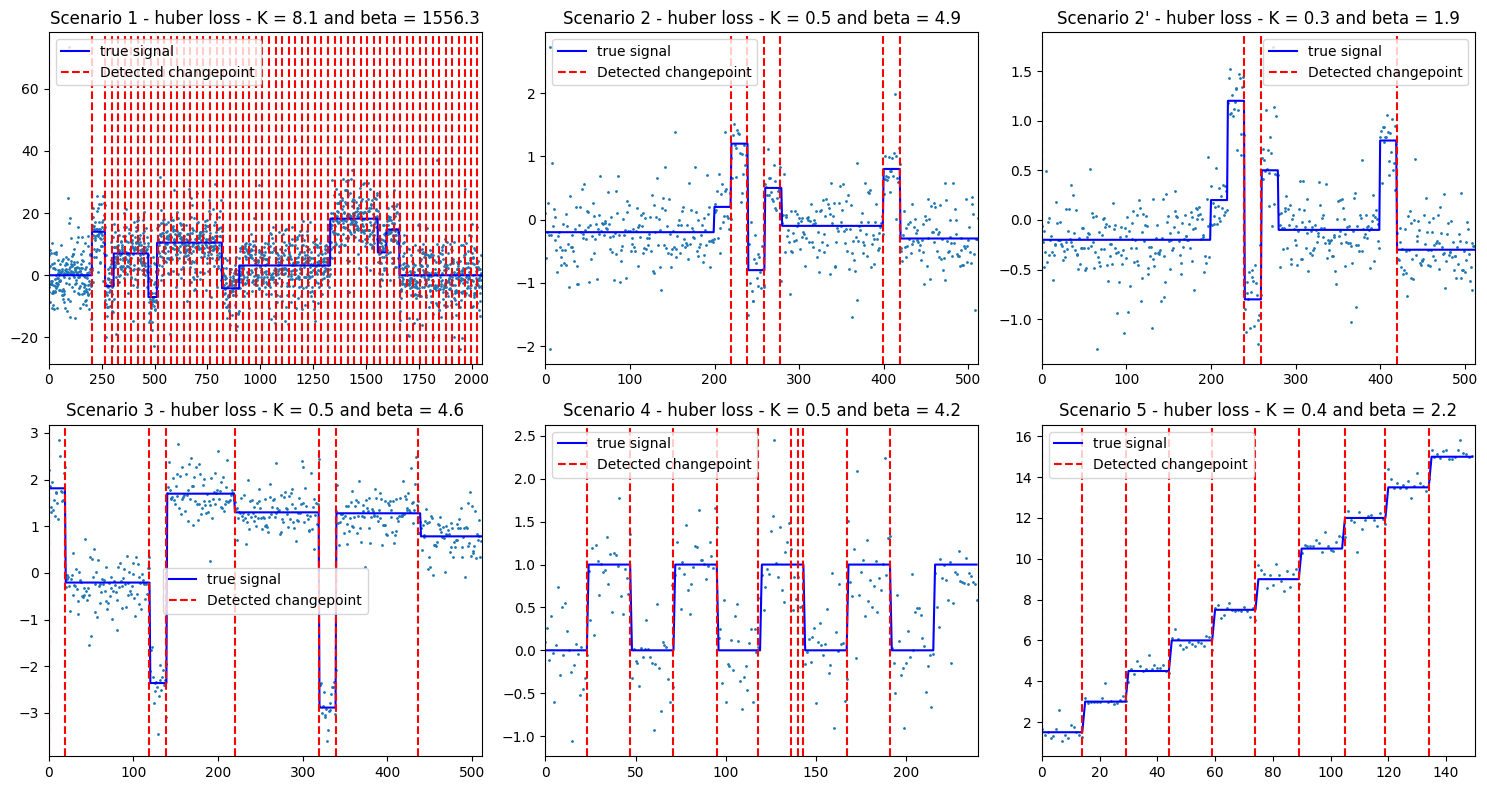

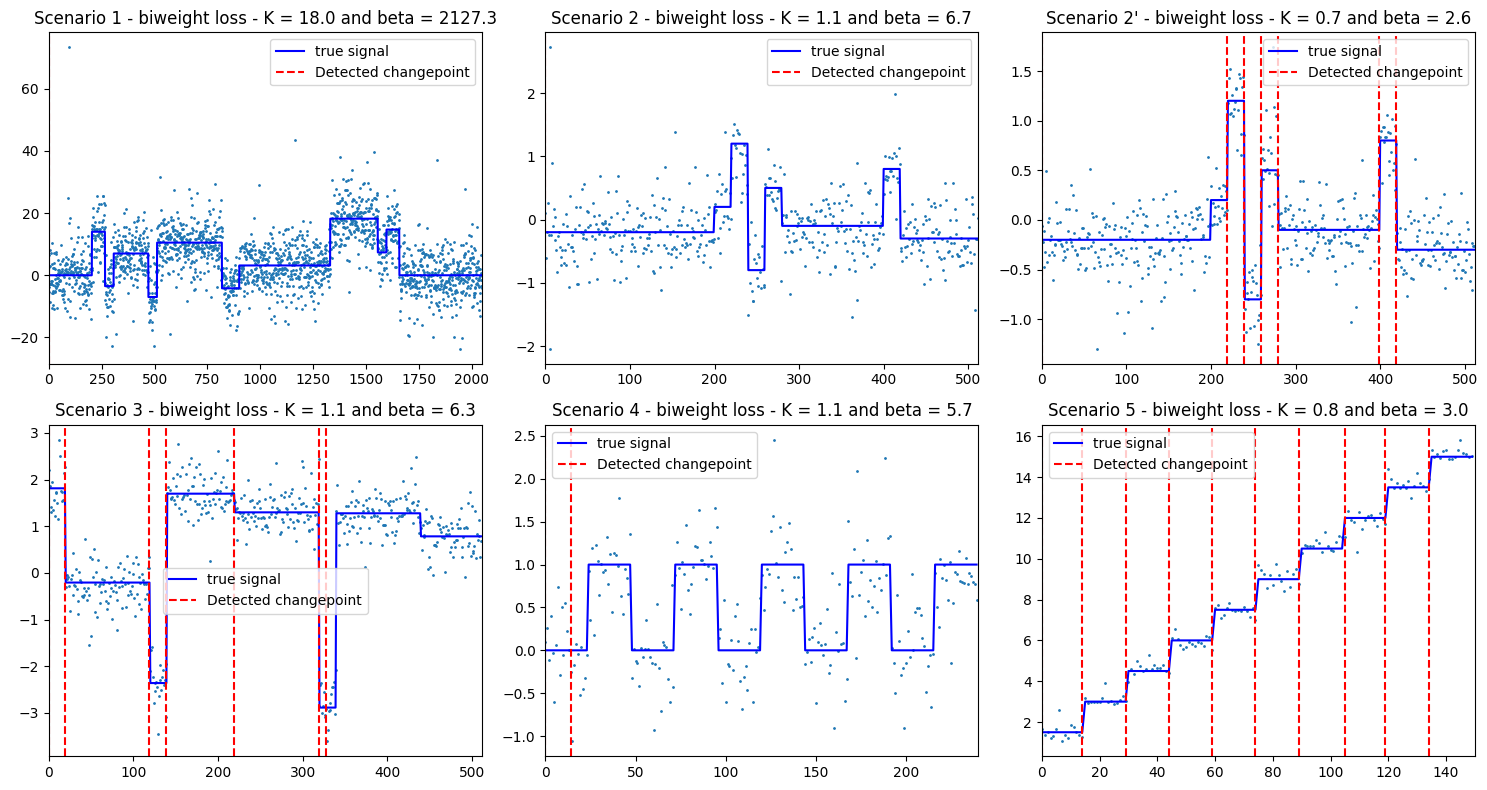

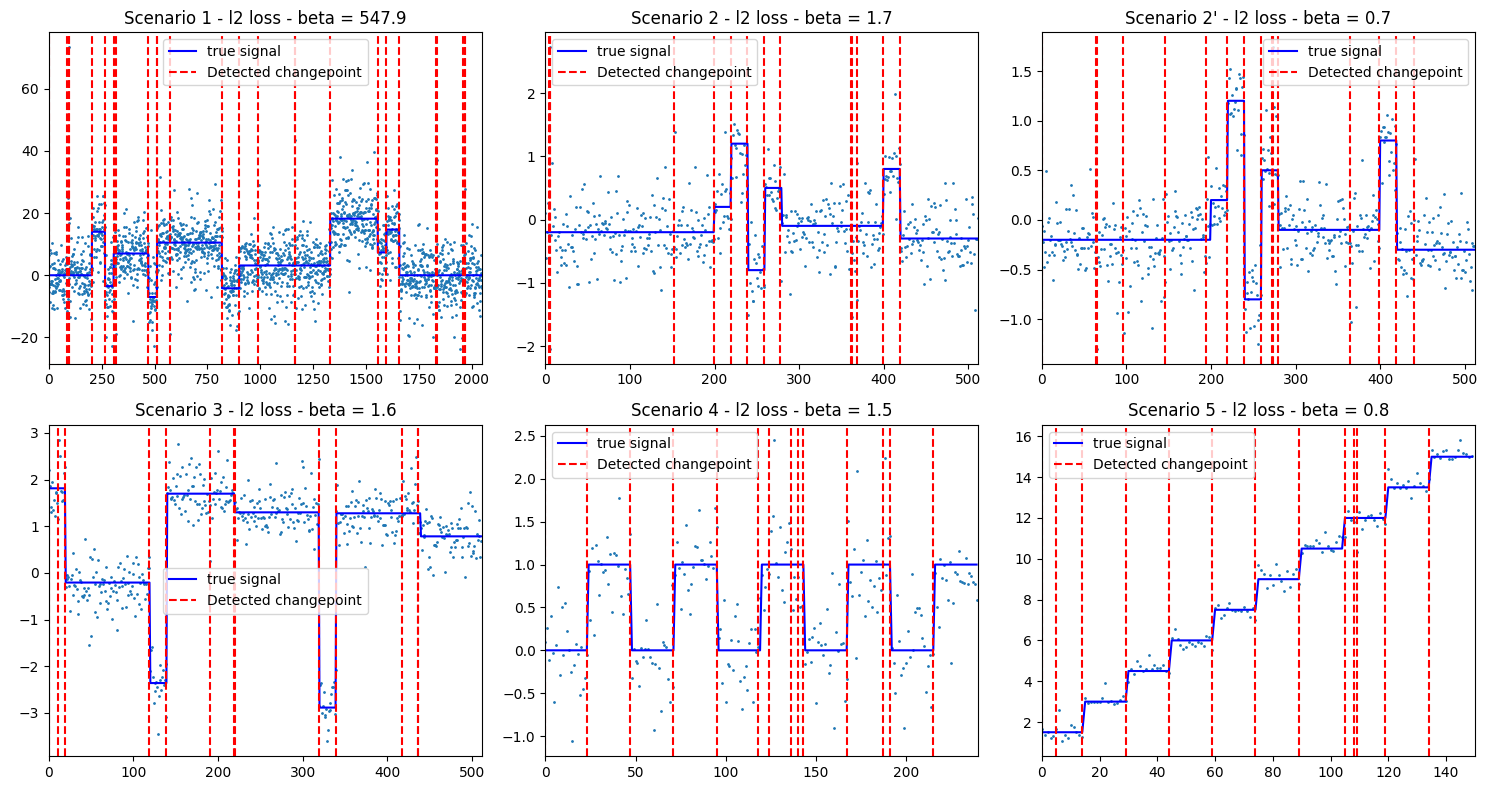

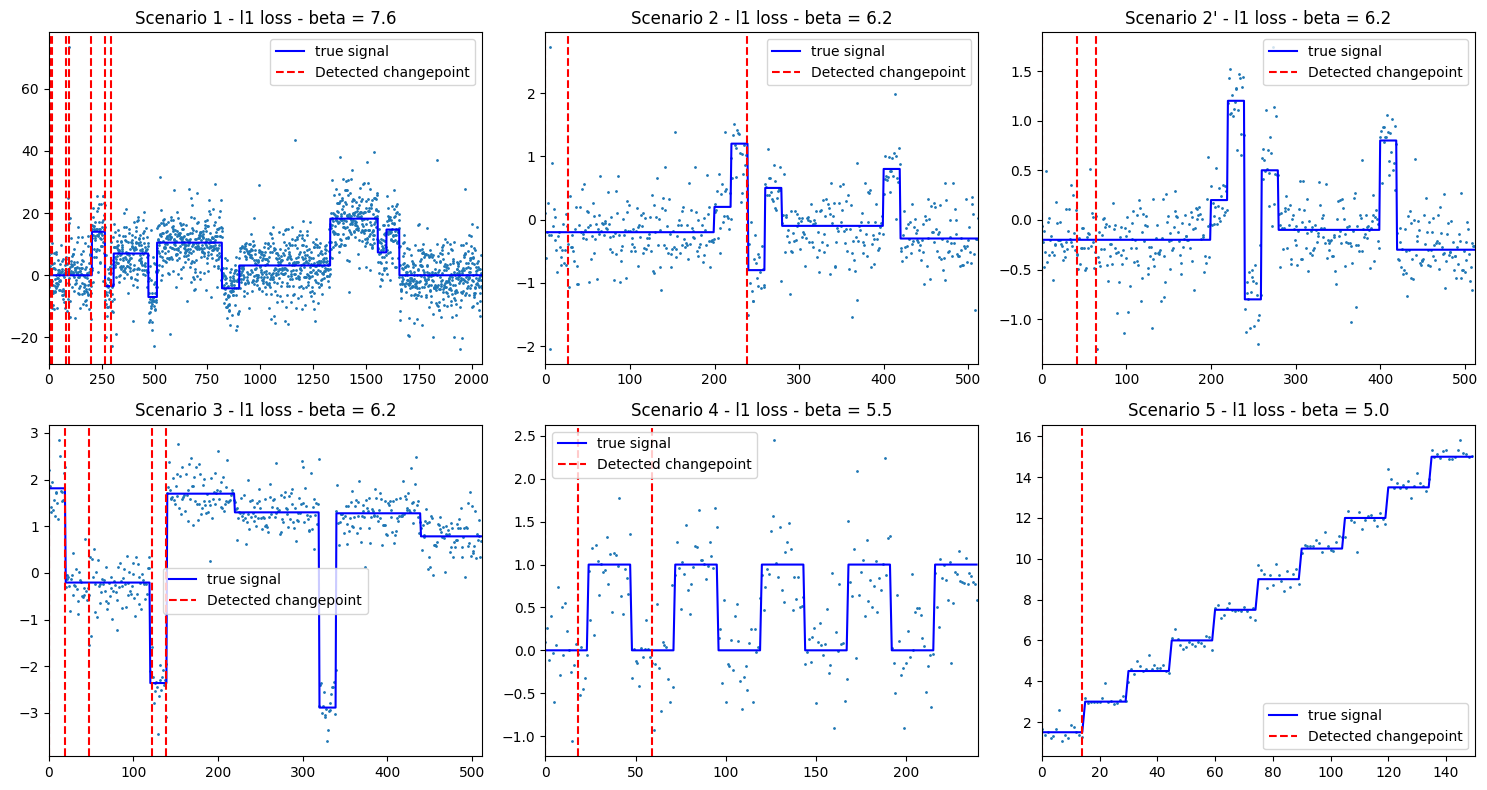

In [10]:

for loss in ['huber','biweight','l2','l1']:
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()



    scenario_names = ["Scenario 1", "Scenario 2", "Scenario 2'", 
                        "Scenario 3", "Scenario 4", "Scenario 5"]

    for i, name in enumerate(scenario_names):
        y = data[name]
        true_sig = true_signals[name]
        beta = compute_penalty_beta(y,loss)
        K=compute_loss_bound_K(y,loss)

        if loss == 'huber':
            cp_tau, Qt_vals, Qstar_final = rfpop_algorithm1_main(y, lambda y_t, t: gamma_builder_huber(y_t, K, t), beta)
        elif loss == 'biweight':
            cp_tau, Qt_vals, Qstar_final = rfpop_algorithm1_main(y, lambda y_t, t: gamma_builder_biweight(y_t, K, t), beta)
        elif loss == 'l1':
            cp_tau, Qt_vals, Qstar_final = rfpop_algorithm1_main(y, lambda y_t, t: gamma_builder_L1(y_t, t), beta)
        else: #l2
            cp_tau, Qt_vals, Qstar_final = rfpop_algorithm1_main(y, lambda y_t, t: gamma_builder_L2(y_t, t), beta)


        ax = axes[i]

        ax.plot(y, '.', markersize=2)
        ax.plot(true_sig, label = 'true signal',color = 'blue')
        changepoints = np.unique(cp_tau)
    
        for cp in changepoints:
            
            # On trace une ligne rouge pointillée à chaque changepoint
            ax.axvline(x=cp, color='r', linestyle='--', label='Detected changepoint' if cp == changepoints[0] else "")
        if not K:
            ax.set_title(f'{name} - {loss} loss - beta = {round(beta,1)}')
        else:
            ax.set_title(f'{name} - {loss} loss - K = {round(K,1)} and beta = {round(beta,1)}')
        ax.set_xlim(0, len(y))
        ax.legend()
        

    plt.tight_layout()
    plt.show()

Analysis of results: 
#### Huber loss
- we get overall satisfying results with the huber loss excepted on the first and third scenarios. 
- On the first scenario, there is an over segmentation phenomenon: although penalty $\beta$ is very high, the algorithm detects too many changepoints. This is because the Huber loss is unbounded and grows linearly at infinity. "For unbounded loss functions, such as [...] Huber loss, a penalised cost approach will place an outlier in a segment on its own if that outlier is sufficiently extreme". 
- On the scenario 2' we can see an under segmentation problem: we detect only 4 out of 7 outliers, while in scenario 2, which is the same but with less noise in the data, we detect 6 out of 7 outliers. In scenario 2', since there is less noise in the data, it may be more costly for the algorithm to pay the penalty $\beta$ to add new changepoints rather than pay it with the loss function (which will be lower on a given segment since outliers are not taking as extreme values as in scenario 2). 

### Biweight loss
- we get poor results on scenarios 1, 2 and 4. For these scenarios, the algorithm detects very few changepoints, because $\beta$ takes too large values (for instance $\beta = 2127$ for the scenario 1), caused by too much noise in the data. For these scenarios we need to increase $K$ (so that points above this threshold are considered as outliers) or decrease $\beta$. By doing so, we would decrease the minimum segment size $\beta/K$ and detect more changepoints.

### L2 loss
- we see an oversegmentation phenomenon on many scenarios: the algorithm detects too many changepoints: it seems we're not penalizing enough and we should increase the $\beta$ parameter to avoid that. 

### L1 loss 
- we see the opposite undersegmentation phenomenon: we're not detecting enough changepoints and should reduce the $\beta$.


We'll now try playing a bit with parameters for each loss to get better results on these scenarios.


## Biweight loss

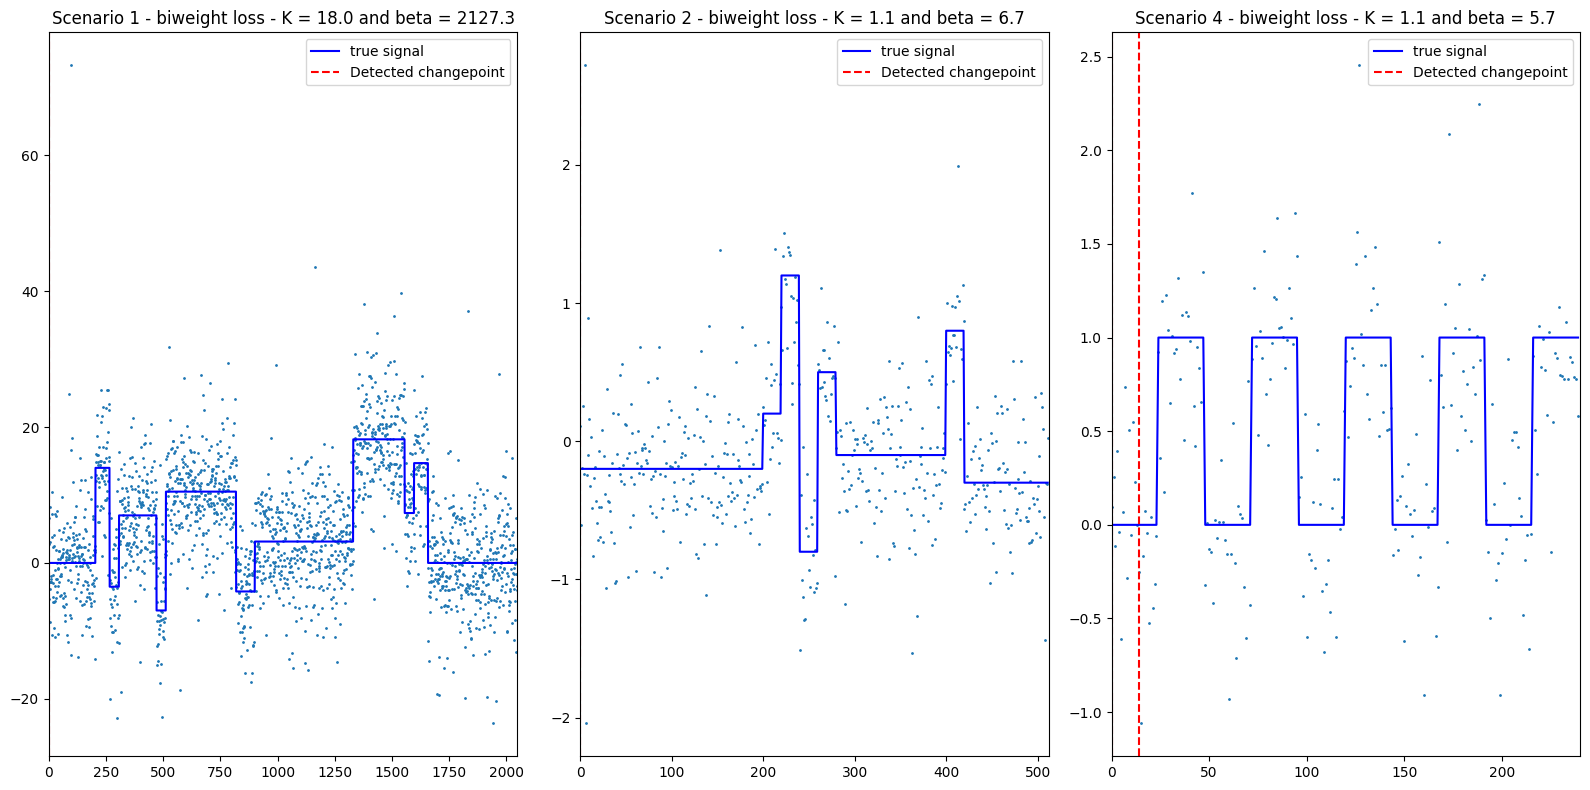

In [11]:

loss = 'biweight'
fig, axes = plt.subplots(1, 3, figsize=(16,8))
axes = axes.flatten()

scenario_names = ["Scenario 1", "Scenario 2", "Scenario 4"]  #, 
                    #"Scenario 3", "Scenario 4", "Scenario 5"]

for i, name in enumerate(scenario_names):
    y = data[name]
    
    true_sig = true_signals[name]
    beta = compute_penalty_beta(y,loss)
    K = compute_loss_bound_K(y,loss)
    

    if loss == 'huber':
        cp_tau, Qt_vals, Qstar_final = rfpop_algorithm1_main(y, lambda y_t, t: gamma_builder_huber(y_t, K, t), beta)
    elif loss == 'biweight':
        cp_tau, Qt_vals, Qstar_final = rfpop_algorithm1_main(y, lambda y_t, t: gamma_builder_biweight(y_t, K, t), beta)
    elif loss == 'l1':
        cp_tau, Qt_vals, Qstar_final = rfpop_algorithm1_main(y, lambda y_t, t: gamma_builder_L1(y_t, t), beta)
    else: #l2
        cp_tau, Qt_vals, Qstar_final = rfpop_algorithm1_main(y, lambda y_t, t: gamma_builder_L2(y_t, t), beta)


    ax = axes[i]

    ax.plot(y, '.', markersize=2)
    ax.plot(true_sig, label = 'true signal',color = 'blue')
    changepoints = np.unique(cp_tau)

    for cp in changepoints:
        
        # On trace une ligne rouge pointillée à chaque changepoint
        ax.axvline(x=cp, color='r', linestyle='--', label='Detected changepoint' if cp == changepoints[0] else "")
    if not K:
        ax.set_title(f'{name} - {loss} loss - beta = {round(beta,1)}')
    else:
        ax.set_title(f'{name} - {loss} loss - K = {round(K,1)} and beta = {round(beta,1)}')
    ax.set_xlim(0, len(y))
    ax.legend()
    

plt.tight_layout()
plt.show()

Whatever we try to do when playing with parameters $\beta$ and $K$ of the biweight loss, we get very disappointing results for these 3 scenarios (very few changepoints detected). Setting a much smaller beta or higher K does not change anything. Even setting beta = 0 does not change things. I don't understand how the paper got satisfying results with this loss.

## Huber

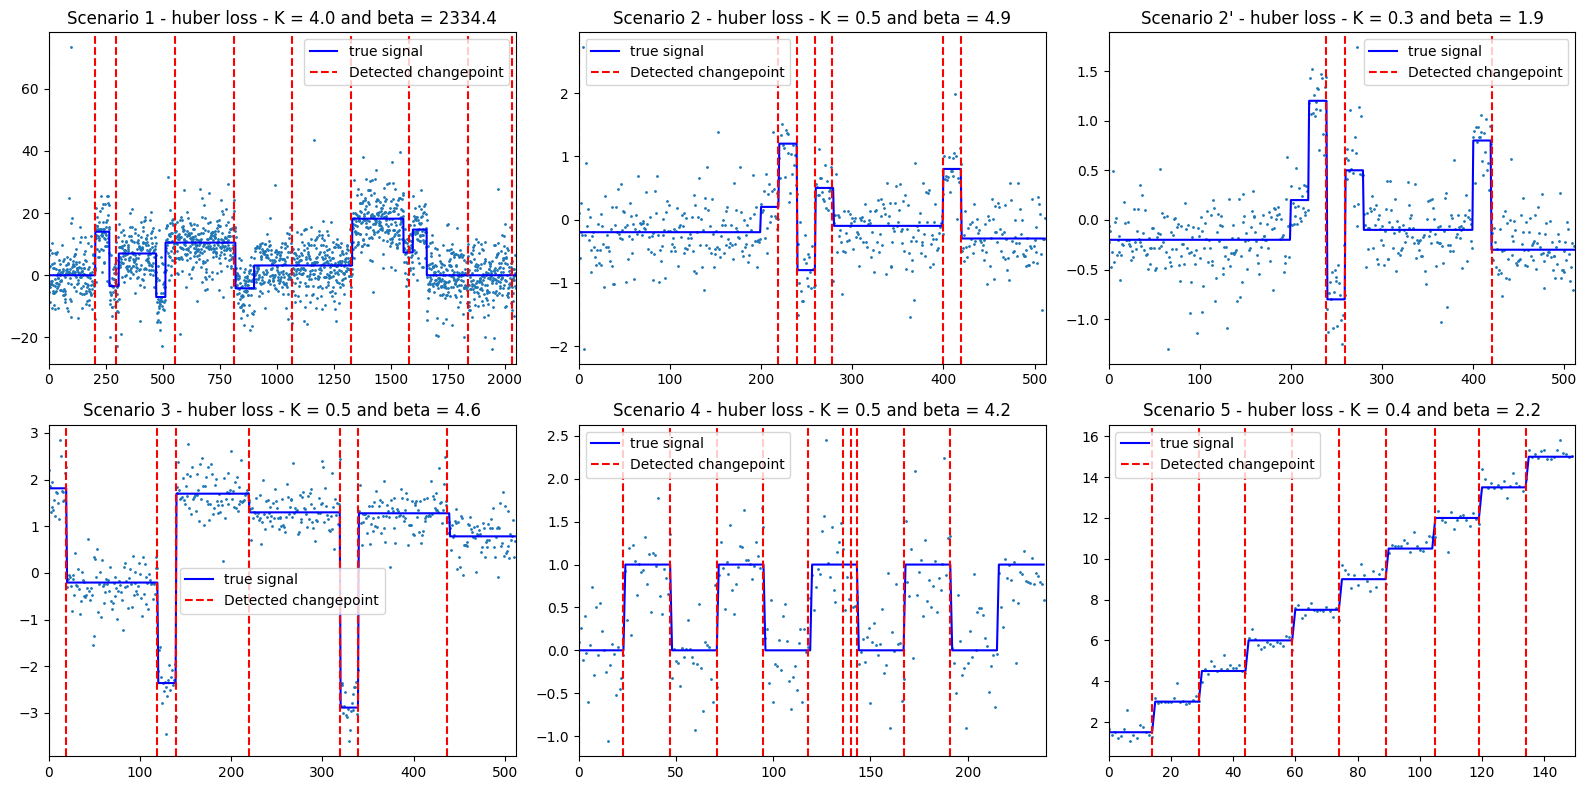

In [12]:

loss = 'huber'
fig, axes = plt.subplots(2, 3, figsize=(16,8))
axes = axes.flatten()

scenario_names = ["Scenario 1", "Scenario 2", "Scenario 2'", 
                    "Scenario 3", "Scenario 4", "Scenario 5"]

for i, name in enumerate(scenario_names):
    y = data[name]
    
    true_sig = true_signals[name]
    beta = compute_penalty_beta(y,loss)
    K = compute_loss_bound_K(y,loss)
    
    if name == 'Scenario 1':
        beta = 1.5*beta
        K = K/2
    

    if loss == 'huber':
        cp_tau, Qt_vals, Qstar_final = rfpop_algorithm1_main(y, lambda y_t, t: gamma_builder_huber(y_t, K, t), beta)
    elif loss == 'biweight':
        cp_tau, Qt_vals, Qstar_final = rfpop_algorithm1_main(y, lambda y_t, t: gamma_builder_biweight(y_t, K, t), beta)
    elif loss == 'l1':
        cp_tau, Qt_vals, Qstar_final = rfpop_algorithm1_main(y, lambda y_t, t: gamma_builder_L1(y_t, t), beta)
    else: #l2
        cp_tau, Qt_vals, Qstar_final = rfpop_algorithm1_main(y, lambda y_t, t: gamma_builder_L2(y_t, t), beta)


    ax = axes[i]

    ax.plot(y, '.', markersize=2)
    ax.plot(true_sig, label = 'true signal',color = 'blue')
    changepoints = np.unique(cp_tau)

    for cp in changepoints:
        
        # On trace une ligne rouge pointillée à chaque changepoint
        ax.axvline(x=cp, color='r', linestyle='--', label='Detected changepoint' if cp == changepoints[0] else "")
    if not K:
        ax.set_title(f'{name} - {loss} loss - beta = {round(beta,1)}')
    else:
        ax.set_title(f'{name} - {loss} loss - K = {round(K,1)} and beta = {round(beta,1)}')
    ax.set_xlim(0, len(y))
    ax.legend()
    

plt.tight_layout()
plt.show()

Even by testing many values and scalings for the values of beta and K for scenario 1, it is difficult to get satisfying results. 

### $\ell_2$ loss

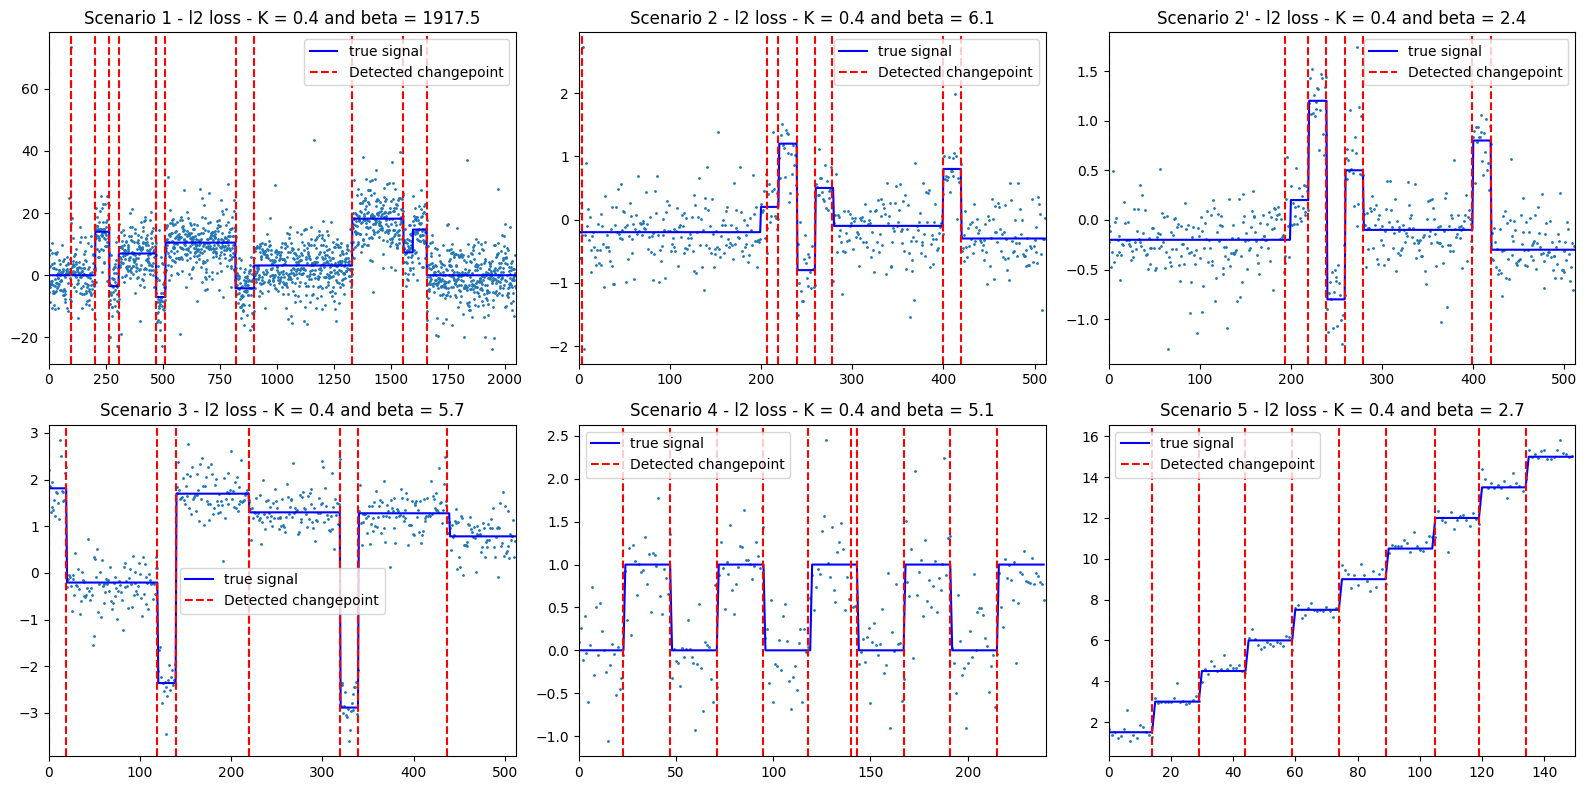

In [13]:

loss = 'l2'
fig, axes = plt.subplots(2, 3, figsize=(16,8))
axes = axes.flatten()

scenario_names = ["Scenario 1", "Scenario 2", "Scenario 2'", 
                    "Scenario 3", "Scenario 4", "Scenario 5"]

for i, name in enumerate(scenario_names):
    y = data[name]
    
    true_sig = true_signals[name]
    beta = compute_penalty_beta(y,loss)*3.5
    # K = compute_loss_bound_K(y,loss)
    
    

    if loss == 'huber':
        cp_tau, Qt_vals, Qstar_final = rfpop_algorithm1_main(y, lambda y_t, t: gamma_builder_huber(y_t, K, t), beta)
    elif loss == 'biweight':
        cp_tau, Qt_vals, Qstar_final = rfpop_algorithm1_main(y, lambda y_t, t: gamma_builder_biweight(y_t, K, t), beta)
    elif loss == 'l1':
        cp_tau, Qt_vals, Qstar_final = rfpop_algorithm1_main(y, lambda y_t, t: gamma_builder_L1(y_t, t), beta)
    else: #l2
        cp_tau, Qt_vals, Qstar_final = rfpop_algorithm1_main(y, lambda y_t, t: gamma_builder_L2(y_t, t), beta)


    ax = axes[i]

    ax.plot(y, '.', markersize=2)
    ax.plot(true_sig, label = 'true signal',color = 'blue')
    changepoints = np.unique(cp_tau)

    for cp in changepoints:
        
        # On trace une ligne rouge pointillée à chaque changepoint
        ax.axvline(x=cp, color='r', linestyle='--', label='Detected changepoint' if cp == changepoints[0] else "")
    if not K:
        ax.set_title(f'{name} - {loss} loss - beta = {round(beta,1)}')
    else:
        ax.set_title(f'{name} - {loss} loss - K = {round(K,1)} and beta = {round(beta,1)}')
    ax.set_xlim(0, len(y))
    ax.legend()
    

plt.tight_layout()
plt.show()

By adjusting manually the $\beta$ penalty (here we incrementally increased beta until getting satisfying results), we get the best results so far and don't see any oversegmentation or undersegmentation. Using the $\ell_2$ loss with a manually tuned beta (here $\beta = 2 \ \hat{\sigma}^2log(n) \cdot 3.5$ is what works best) seems to yield very satisfying results.

Moreover, from a practical perspective, using the $\ell_2$ loss is much simpler than using the biweight or huber loss as it is more interpretable, and we need to tune only one parameter and not 2.

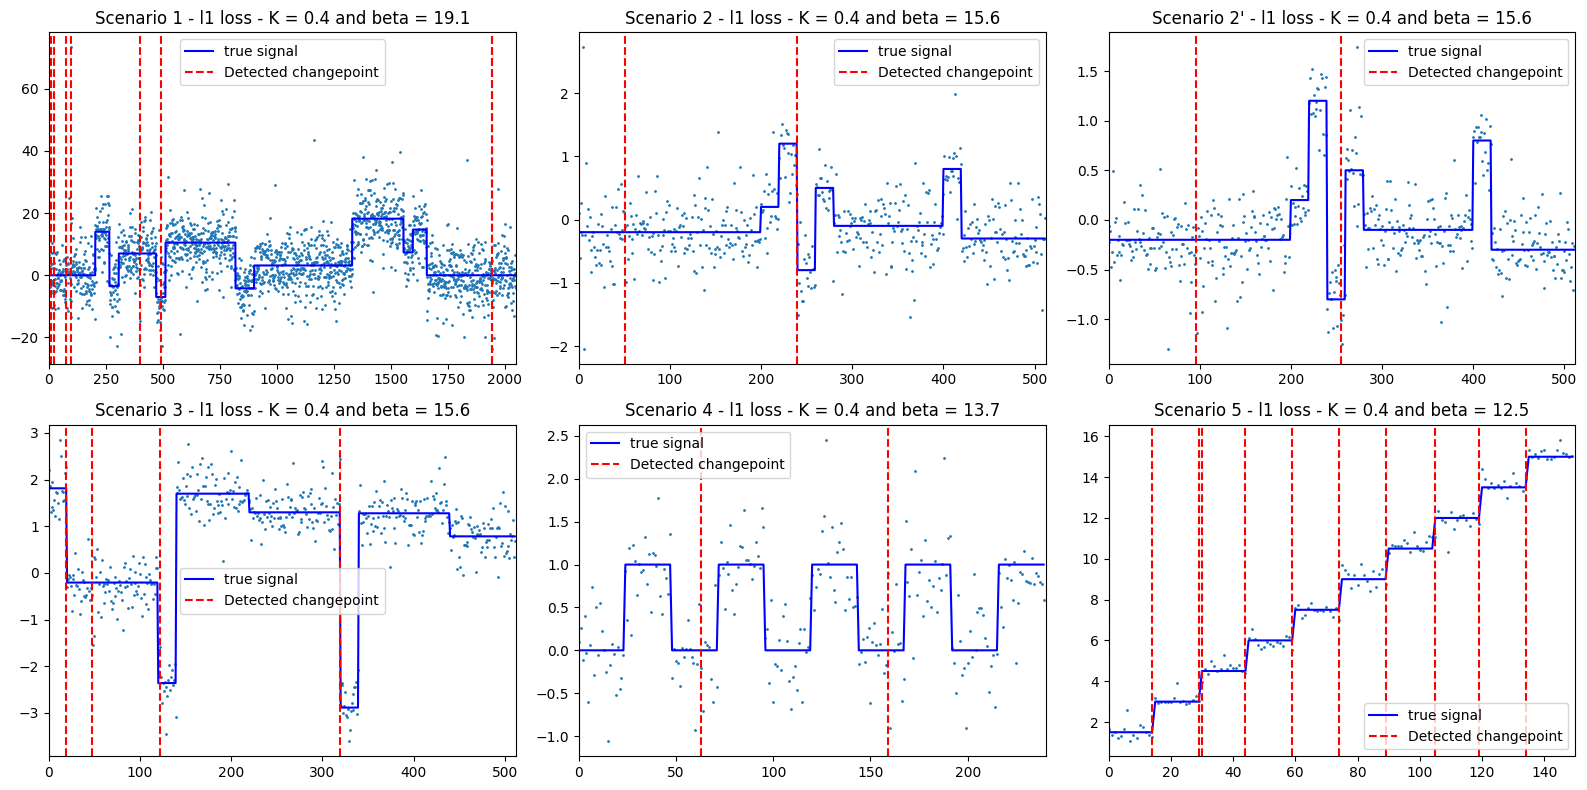

In [14]:

loss = 'l1'
fig, axes = plt.subplots(2, 3, figsize=(16,8))
axes = axes.flatten()

scenario_names = ["Scenario 1", "Scenario 2", "Scenario 2'", 
                    "Scenario 3", "Scenario 4", "Scenario 5"]

for i, name in enumerate(scenario_names):
    y = data[name]
    
    true_sig = true_signals[name]
    beta = compute_penalty_beta(y,loss)*2.5
    # K = compute_loss_bound_K(y,loss)
    
    

    if loss == 'huber':
        cp_tau, Qt_vals, Qstar_final = rfpop_algorithm1_main(y, lambda y_t, t: gamma_builder_huber(y_t, K, t), beta)
    elif loss == 'biweight':
        cp_tau, Qt_vals, Qstar_final = rfpop_algorithm1_main(y, lambda y_t, t: gamma_builder_biweight(y_t, K, t), beta)
    elif loss == 'l1':
        cp_tau, Qt_vals, Qstar_final = rfpop_algorithm1_main(y, lambda y_t, t: gamma_builder_L1(y_t, t), beta)
    else: #l2
        cp_tau, Qt_vals, Qstar_final = rfpop_algorithm1_main(y, lambda y_t, t: gamma_builder_L2(y_t, t), beta)


    ax = axes[i]

    ax.plot(y, '.', markersize=2)
    ax.plot(true_sig, label = 'true signal',color = 'blue')
    changepoints = np.unique(cp_tau)

    for cp in changepoints:
        
        # On trace une ligne rouge pointillée à chaque changepoint
        ax.axvline(x=cp, color='r', linestyle='--', label='Detected changepoint' if cp == changepoints[0] else "")
    if not K:
        ax.set_title(f'{name} - {loss} loss - beta = {round(beta,1)}')
    else:
        ax.set_title(f'{name} - {loss} loss - K = {round(K,1)} and beta = {round(beta,1)}')
    ax.set_xlim(0, len(y))
    ax.legend()
    

plt.tight_layout()
plt.show()

We also struggle getting better results by adjusting manually the $\beta$ for the $\ell_1$ loss.

# Cross Validation

We cross validate beta and K

In [15]:
def cross_validate_rfpop(
    y: np.ndarray,
    loss: Literal['huber', 'biweight', 'l2', 'l1'] = 'biweight',
    beta_range: Optional[np.ndarray] = None,
    K_range: Optional[np.ndarray] = None,
    criterion: Literal['penalized_cost', 'raw_cost_bic'] = 'penalized_cost',
    verbose: bool = True
) -> dict:
    """
    Cross-validation généralisée pour RFPOP avec différentes loss functions.
    
    Corrige le bug de closure en utilisant des fonctions avec paramètres par défaut.

    Parameters:
    -----------
    y : np.ndarray
        Série temporelle
    loss : str
        Type de loss function: 'huber', 'biweight', 'l2', ou 'l1'
    beta_range : np.ndarray, optional
        Grille de valeurs pour β
    K_range : np.ndarray, optional  
        Grille de valeurs pour K (ignoré pour l2)
    criterion : str
        'penalized_cost' ou 'raw_cost_bic'
    verbose : bool
        Affiche les informations de progression

    Returns:
    --------
    dict : Résultats incluant best_beta, best_K, best_score, etc.
    """
    n = len(y)
    y_list = list(y)
    
    # Paramètres théoriques du papier
    ys = pd.Series(y)
    sigma_hat = robust.mad(ys.diff().dropna()) / np.sqrt(2)
    
    # Calculer les paramètres de référence
    if loss in ['huber', 'biweight']:
        K_paper = compute_loss_bound_K(y, loss)
        beta_paper = compute_penalty_beta(y, loss)
    elif loss == 'l2':
        K_paper = None
        beta_paper = compute_penalty_beta(y, 'l2')
    else:  # l1
        K_paper = None
        beta_paper = compute_penalty_beta(y, 'l1')
    
    # Définir les grilles de recherche
    if beta_range is None:
        beta_range = np.linspace(0.1 * beta_paper, 5.0 * beta_paper, num=25)
    
    if loss in ['huber', 'biweight']:
        if K_range is None:
            K_range = np.linspace(0.5 * K_paper, 3.0 * K_paper, num=20)
    else:  # l2 ou l1
        K_range = [None]  # L2 et L1 n'ont pas de K
    
    results = []
    
    if verbose:
        total = len(beta_range) * len(K_range)
        print(f"Cross-validation pour {loss} loss")
        print(f"Exploration de {len(beta_range)} × {len(K_range)} = {total} combinaisons...")
    
    for beta in beta_range:
        for K in K_range:
            beta_used = beta
            
            try:
                # Créer le gamma_builder avec capture correcte de K
                # On utilise une valeur par défaut pour éviter le bug de closure
                if loss == 'huber':
                    def make_gamma(K_val):
                        return lambda y_t, t: gamma_builder_huber(y_t, K_val, t)
                    gamma_builder = make_gamma(K)
                elif loss == 'biweight':
                    def make_gamma(K_val):
                        return lambda y_t, t: gamma_builder_biweight(y_t, K_val, t)
                    gamma_builder = make_gamma(K)
                elif loss == 'l2':
                    gamma_builder = lambda y_t, t: gamma_builder_L2(y_t, t)
                else:  # l1
                    gamma_builder = lambda y_t, t: gamma_builder_L1(y_t, t)
                
                cp_tau, Qt_vals, _ = rfpop_algorithm1_main(y_list, gamma_builder, beta_used)
                
                changepoints = np.unique(cp_tau)
                n_cp = len(changepoints) - 1
                n_segments = len(changepoints)
                
                penalized_cost = Qt_vals[-1]
                raw_cost = penalized_cost - n_segments * beta_used
                
                if criterion == 'penalized_cost':
                    score = penalized_cost
                else:  # raw_cost_bic
                    score = raw_cost + np.log(n) * n_cp
                
                results.append({
                    'beta': beta_used,
                    'K': K,
                    'ratio': beta_used / K if K else None,
                    'penalized_cost': penalized_cost,
                    'raw_cost': raw_cost,
                    'n_changepoints': n_cp,
                    'score': score,
                    'cp_tau': cp_tau,
                    'changepoints': changepoints
                })
                
            except Exception as e:
                if verbose:
                    print(f"  Erreur pour β={beta:.2f}, K={K}: {e}")
    
    if not results:
        raise ValueError("Aucun résultat valide obtenu")
    
    best_idx = np.argmin([r['score'] for r in results])
    best = results[best_idx]
    
    return {
        'best_beta': best['beta'],
        'best_K': best['K'],
        'best_ratio': best['ratio'],
        'best_score': best['score'],
        'best_n_cp': best['n_changepoints'],
        'best_changepoints': best['changepoints'],
        'best_cp_tau': best['cp_tau'],
        'all_results': results,
        'paper_params': {
            'beta': beta_paper,
            'K': K_paper,
            'sigma_hat': sigma_hat
        },
        'loss': loss,
        'criterion': criterion
    }


def extract_changepoints_backtrack(cp_tau):
    """
    Extrait les changepoints par backtracking (méthode correcte).
    
    Parameters:
    -----------
    cp_tau : list
        Liste des derniers changepoints pour chaque position
        
    Returns:
    --------
    list : Liste des positions de changepoints (sans le 0 initial)
    """
    n = len(cp_tau)
    changepoints = []
    t = n - 1
    
    while t > 0:
        tau = cp_tau[t]
        if tau > 0:
            changepoints.append(tau)
        t = tau
    
    changepoints.reverse()
    return changepoints


def get_segments_from_cp_tau(cp_tau, y):
    """
    Extrait les segments à partir de cp_tau.
    
    Returns:
    --------
    list of tuples : [(start_idx, end_idx, mean_value), ...]
    """
    n = len(cp_tau)
    segments = []
    t = n - 1
    
    while t > 0:
        t_prev = int(cp_tau[t])
        if isinstance(y, pd.Series):
            seg_mean = y.iloc[t_prev:t+1].mean()
        else:
            seg_mean = np.mean(y[t_prev:t+1])
        segments.append((t_prev, t, seg_mean))
        t = t_prev
    
    segments.reverse()
    return segments

In [16]:
def plot_cv_biweight_results(cv_result: dict, y: np.ndarray, true_signal: np.ndarray, 
                              title: str = "CV Biweight - Résultats"):
    """
    Visualise les résultats de la CV biweight avec plusieurs graphiques.
    
    Le coût affiché est le coût pénalisé Qt_vals[-1] qui inclut déjà β×n_segments.
    """
    results = cv_result['all_results']
    paper = cv_result['paper_params']
    n = len(y)
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Signal avec changepoints détectés
    ax1 = axes[0, 0]
    ax1.plot(y, '.', markersize=2, alpha=0.5, label='Données')
    ax1.plot(true_signal, 'b-', linewidth=2, label='Vrai signal')
    for i, cp in enumerate(cv_result['best_changepoints']):
        ax1.axvline(x=cp, color='r', linestyle='--', alpha=0.7,
                   label='CP détectés' if i == 0 else "")
    ax1.set_title(f"β={cv_result['best_beta']:.2f}, K={cv_result['best_K']:.2f}, "
                  f"Ratio={cv_result['best_ratio']:.2f}, N_CP={cv_result['best_n_cp']}")
    ax1.legend(loc='upper right')
    ax1.set_xlim(0, n)
    
    # 2. Heatmap Score vs (β, K)
    ax2 = axes[0, 1]
    df = pd.DataFrame(results)
    pivot = df.pivot_table(values='score', index='K', columns='beta_used', aggfunc='mean')
    im = ax2.imshow(pivot.values, aspect='auto', cmap='viridis_r', origin='lower')
    ax2.set_xticks(range(len(pivot.columns)))
    ax2.set_xticklabels([f'{x:.1f}' for x in pivot.columns], rotation=45, fontsize=8)
    ax2.set_yticks(range(len(pivot.index)))
    ax2.set_yticklabels([f'{x:.2f}' for x in pivot.index])
    ax2.set_xlabel('β')
    ax2.set_ylabel('K')
    ax2.set_title(f'Score ({cv_result["criterion"]}) - Plus foncé = meilleur')
    plt.colorbar(im, ax=ax2)
    
    # 3. N changepoints vs Ratio β/K
    ax3 = axes[1, 0]
    ratios = [r['ratio'] for r in results]
    n_cps = [r['n_changepoints'] for r in results]
    costs = [r['penalized_cost'] for r in results]  # Utilise penalized_cost
    
    scatter = ax3.scatter(ratios, n_cps, c=costs, cmap='plasma', alpha=0.7)
    ax3.axvline(x=n/100, color='green', linestyle='--', linewidth=2, 
                label=f'Seuil clipping (n/100={n/100:.1f})')
    ax3.axvline(x=paper['ratio'], color='orange', linestyle=':', linewidth=2,
                label=f'Ratio papier ({paper["ratio"]:.2f})')
    ax3.scatter([cv_result['best_ratio']], [cv_result['best_n_cp']], 
                color='red', s=200, marker='*', zorder=5, label='Optimal CV')
    ax3.set_xlabel('Ratio β/K (= longueur min segment)')
    ax3.set_ylabel('N changepoints')
    ax3.set_title('Impact du ratio β/K')
    ax3.legend(loc='upper right')
    plt.colorbar(scatter, ax=ax3, label='Coût pénalisé')
    
    # 4. Coût vs N changepoints (courbe L)
    ax4 = axes[1, 1]
    # Grouper par n_changepoints et prendre le min cost
    df_grouped = df.groupby('n_changepoints').agg({
        'penalized_cost': 'min', 
        'raw_cost': 'min',
        'ratio': 'mean'
    }).reset_index()
    
    ax4.plot(df_grouped['n_changepoints'], df_grouped['penalized_cost'], 'o-', 
             markersize=8, label='Coût pénalisé (Qt[-1])')
    ax4.plot(df_grouped['n_changepoints'], df_grouped['raw_cost'], 's--', 
             markersize=6, alpha=0.7, label='Coût brut (sans β)')
    
    ax4.scatter([cv_result['best_n_cp']], 
                [cv_result['best_penalized_cost']],
                color='red', s=200, marker='*', zorder=5, label='Optimal CV')
    ax4.set_xlabel('N changepoints')
    ax4.set_ylabel('Coût')
    ax4.set_title('Compromis coût/complexité')
    ax4.legend()
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return fig

In [17]:
# Cross-validation pour tous les scénarios avec les 4 loss functions
# Compare les résultats de la CV avec les paramètres ajustés manuellement

scenario_names = ["Scenario 1", "Scenario 2", "Scenario 2'", "Scenario 3", "Scenario 4", "Scenario 5"]
losses = ['huber', 'biweight', 'l2', 'l1']

# Stocker tous les résultats
all_cv_results = {}

for scenario in scenario_names:
    print(f"\n{'='*60}")
    print(f"  {scenario}")
    print(f"{'='*60}")
    
    y = data[scenario]
    true_sig = true_signals[scenario]
    all_cv_results[scenario] = {}
    
    for loss in losses:
        print(f"\n  [{loss.upper()}] Cross-validation...")
        
        try:
            cv_result = cross_validate_rfpop(
                y=y,
                loss=loss,
                criterion='penalized_cost',
                verbose=False
            )
            
            all_cv_results[scenario][loss] = cv_result
            
            print(f"    Best beta: {cv_result['best_beta']:.4f}")
            if cv_result['best_K'] is not None:
                print(f"    Best K: {cv_result['best_K']:.4f}")
                print(f"    Best ratio (beta/K): {cv_result['best_ratio']:.2f}")
            print(f"    Changepoints detected: {cv_result['best_n_cp']}")
            print(f"    Paper params: beta={cv_result['paper_params']['beta']:.4f}", end="")
            if cv_result['paper_params']['K'] is not None:
                print(f", K={cv_result['paper_params']['K']:.4f}")
            else:
                print()
                
        except Exception as e:
            print(f"    Error: {e}")
            all_cv_results[scenario][loss] = None

print("\n" + "="*60)
print("CV COMPLETED FOR ALL SCENARIOS")
print("="*60)


  Scenario 1

  [HUBER] Cross-validation...
    Best beta: 155.6283
    Best K: 4.0309
    Best ratio (beta/K): 38.61
    Changepoints detected: 108
    Paper params: beta=1556.2829, K=8.0618

  [BIWEIGHT] Cross-validation...
    Best beta: 212.7251
    Best K: 8.9909
    Best ratio (beta/K): 23.66
    Changepoints detected: 3
    Paper params: beta=2127.2506, K=17.9818

  [L2] Cross-validation...
    Best beta: 54.7860
    Changepoints detected: 610
    Paper params: beta=547.8600

  [L1] Cross-validation...
    Best beta: 0.7625
    Changepoints detected: 287
    Paper params: beta=7.6246

  Scenario 2

  [HUBER] Cross-validation...
    Best beta: 0.4920
    Best K: 0.5143
    Best ratio (beta/K): 0.96
    Changepoints detected: 67
    Paper params: beta=4.9200, K=0.5011

  [BIWEIGHT] Cross-validation...
    Best beta: 0.6725
    Best K: 0.5589
    Best ratio (beta/K): 1.20
    Changepoints detected: 14
    Paper params: beta=6.7250, K=1.1177

  [L2] Cross-validation...
    Best bet

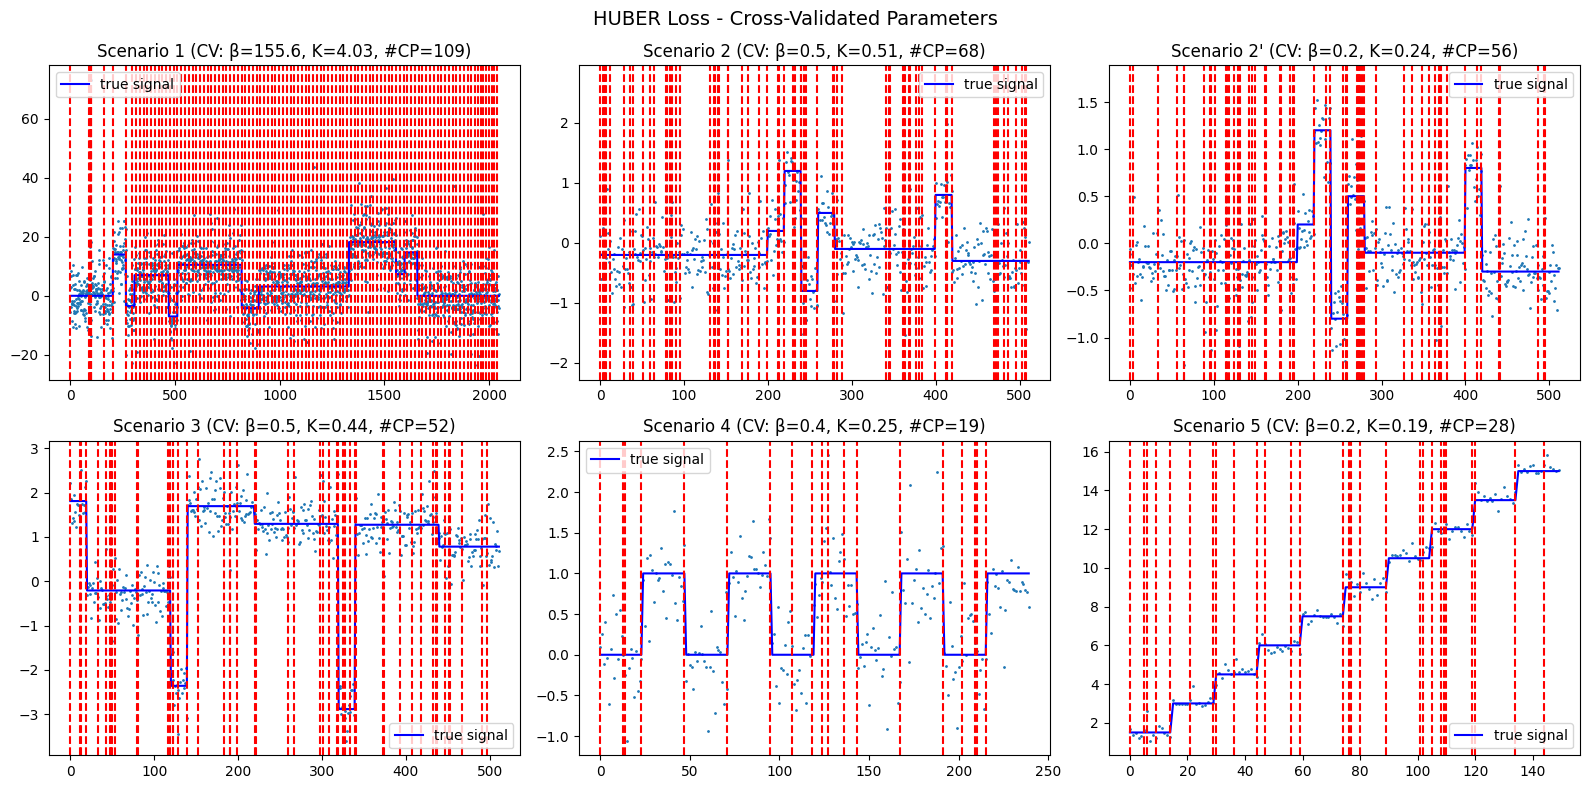

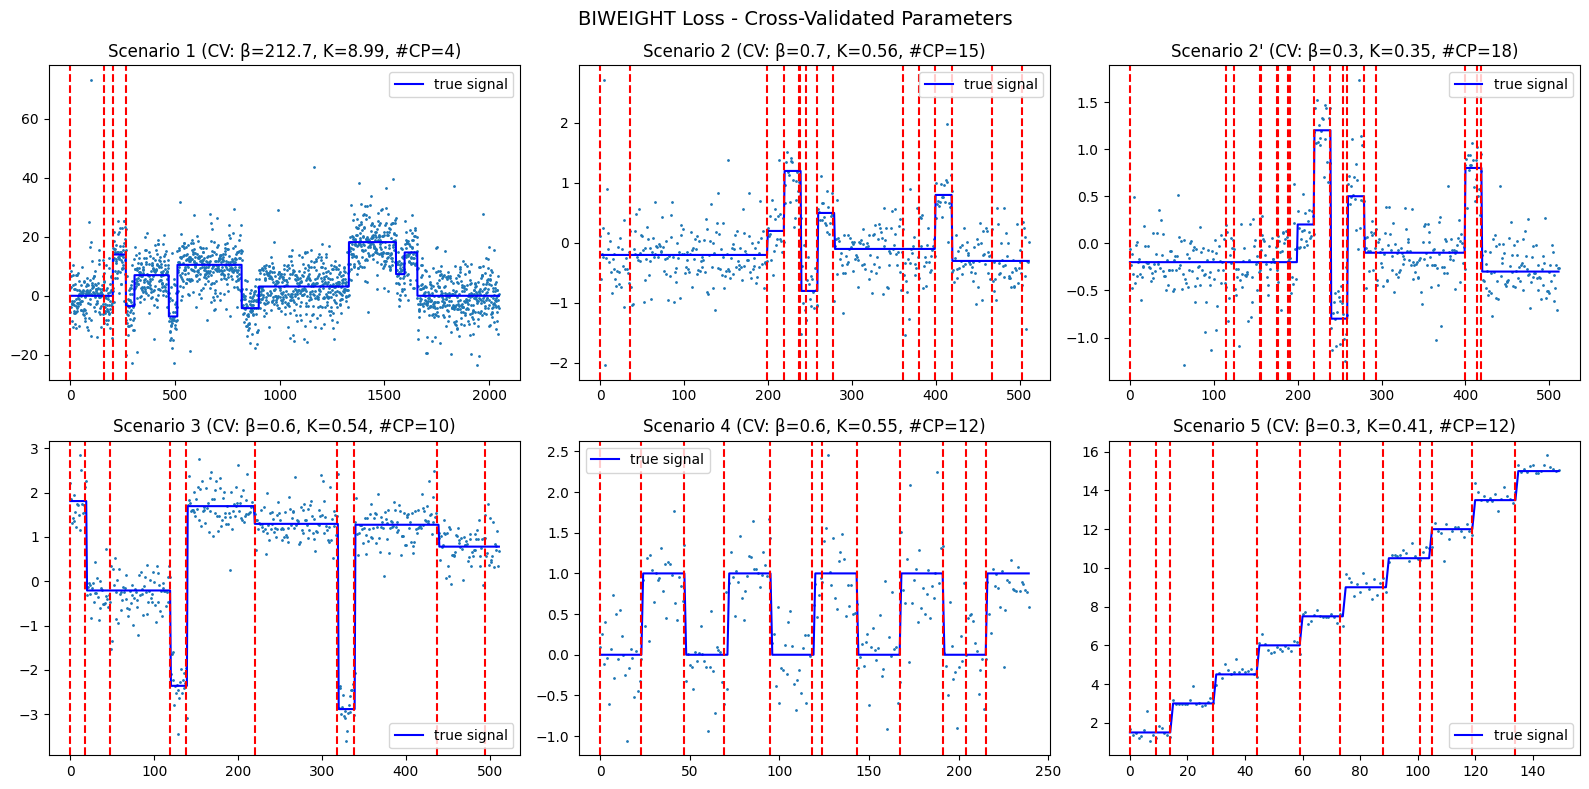

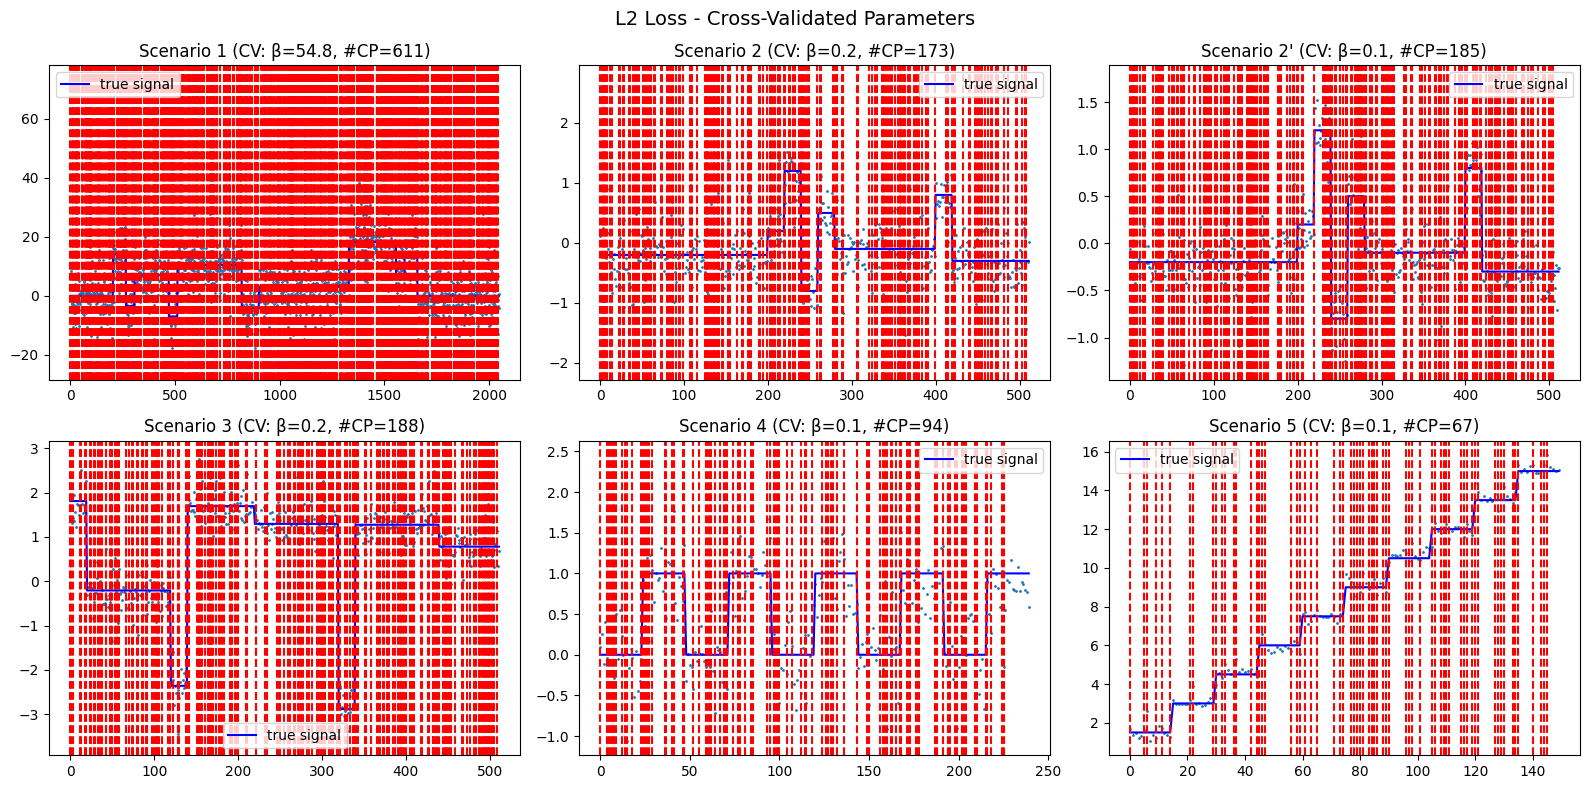

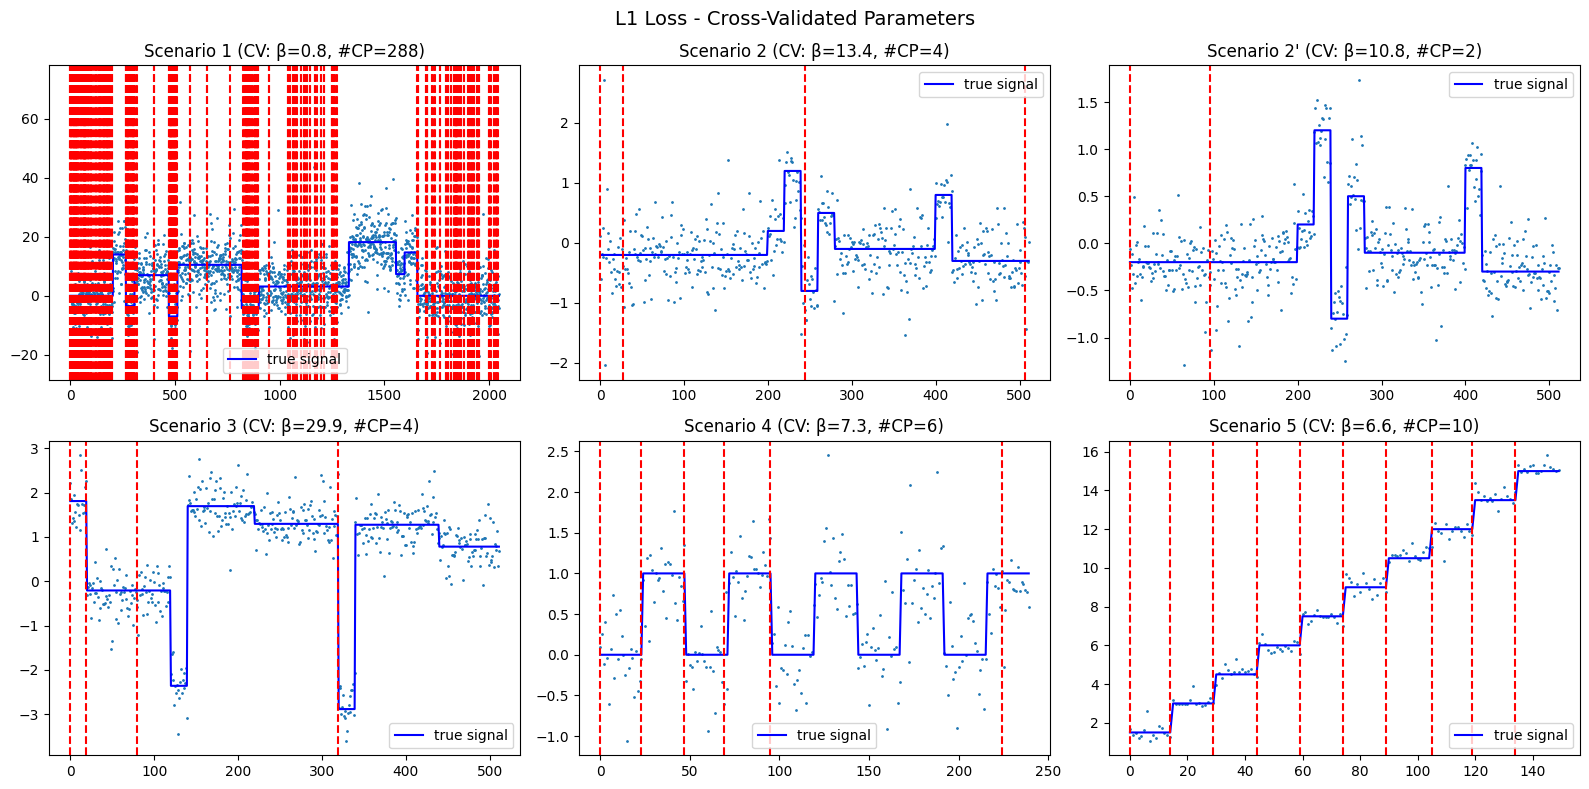

In [41]:
for loss in ['huber', 'biweight', 'l2', 'l1']:
    fig, axes = plt.subplots(2, 3, figsize=(16, 8))
    axes = axes.flatten()

    scenario_names = ["Scenario 1", "Scenario 2", "Scenario 2'", 
                      "Scenario 3", "Scenario 4", "Scenario 5"]

    for i, name in enumerate(scenario_names):
        y = data[name]
        true_sig = true_signals[name]
        
        # Get CV results (nested dict)
        cv_result = all_cv_results[name][loss]
        changepoints = cv_result['best_changepoints']
        best_beta = cv_result['best_beta']
        best_K = cv_result.get('best_K', None)

        ax = axes[i]

        ax.plot(y, '.', markersize=2)
        ax.plot(true_sig, label='true signal', color='blue')

        for cp in changepoints:
            ax.axvline(x=cp, color='red', linestyle='--')

        # Title with CV params
        if best_K is not None:
            ax.set_title(f'{name} (CV: β={best_beta:.1f}, K={best_K:.2f}, #CP={len(changepoints)})')
        else:
            ax.set_title(f'{name} (CV: β={best_beta:.1f}, #CP={len(changepoints)})')
        
        ax.legend()

    fig.suptitle(f'{loss.upper()} Loss - Cross-Validated Parameters', fontsize=14)
    plt.tight_layout()
    plt.show()



The CV is not very satisfying... for the biweight loss it works relatively well, L2 and Huber is catastrophic, and L1 is okay-ish, but 

# Application to real data

## A) Data extraction and visualisation

In [19]:
# from fredapi import Fred
# api_key = "615add3bd441c0ed42dec47e952d69e2"
# fred_api = Fred(api_key=api_key)

# fred_ticker = ['T10Y2Y', 'T10Y3M', 'T10YFF', 'T5YFF', 'T1YFF', 'AAA10Y', 'BAA10Y',
#        'BAAnetAAA', 'T10YIE', 'T5YIE', 'T5YIFR',
#        "DFF","VIXCLS","TEDRATE","GDPC1","CLVMNACSCAB1GQEA19","JPNRGDPEXP","CLVMNACSCAB1GQDE","UKNGDP"]


# start_date = "1900-09-01"
# end_date = "2025-12-01"

# fred = {}
# for feature in fred_ticker:
#     print(feature)
#     try:
#         series = fred_api.get_series(
#             feature, observation_start=start_date, observation_end=end_date
#         )
#         fred[feature] = series
#     except ValueError:
#         print(f"Could not retrieve data for {feature}.")
#         continue

In [20]:
# dus = pd.DataFrame(fred)

In [21]:
# dus.to_csv("economic_data_fred.csv")

In [22]:
df = pd.read_csv("economic_data_fred.csv",index_col=0)
df.index = pd.to_datetime(df.index)
df.head()

T10Y2Y  T10Y3M  T10YFF  T5YFF  T1YFF  AAA10Y  BAA10Y  T10YIE  \
1947-01-01     NaN     NaN     NaN    NaN    NaN     NaN     NaN     NaN   
1947-04-01     NaN     NaN     NaN    NaN    NaN     NaN     NaN     NaN   
1947-07-01     NaN     NaN     NaN    NaN    NaN     NaN     NaN     NaN   
1947-10-01     NaN     NaN     NaN    NaN    NaN     NaN     NaN     NaN   
1948-01-01     NaN     NaN     NaN    NaN    NaN     NaN     NaN     NaN   

            T5YIE  T5YIFR  DFF  VIXCLS  TEDRATE     GDPC1  CLVMNACSCAB1GQEA19  \
1947-01-01    NaN     NaN  NaN     NaN      NaN  2182.681                 NaN   
1947-04-01    NaN     NaN  NaN     NaN      NaN  2176.892                 NaN   
1947-07-01    NaN     NaN  NaN     NaN      NaN  2172.432                 NaN   
1947-10-01    NaN     NaN  NaN     NaN      NaN  2206.452                 NaN   
1948-01-01    NaN     NaN  NaN     NaN      NaN  2239.682                 NaN   

            JPNRGDPEXP  CLVMNACSCAB1GQDE  UKNGDP  
1947-01-01         NaN               NaN     NaN  
1947-04-01         NaN               NaN     NaN  
1947-07-01         NaN               NaN     NaN  
1947-10-01         NaN               NaN     NaN  
1948-01-01         NaN               NaN     NaN

In [23]:
df.columns

Index(['T10Y2Y', 'T10Y3M', 'T10YFF', 'T5YFF', 'T1YFF', 'AAA10Y', 'BAA10Y',
       'T10YIE', 'T5YIE', 'T5YIFR', 'DFF', 'VIXCLS', 'TEDRATE', 'GDPC1',
       'CLVMNACSCAB1GQEA19', 'JPNRGDPEXP', 'CLVMNACSCAB1GQDE', 'UKNGDP'],
      dtype='object')

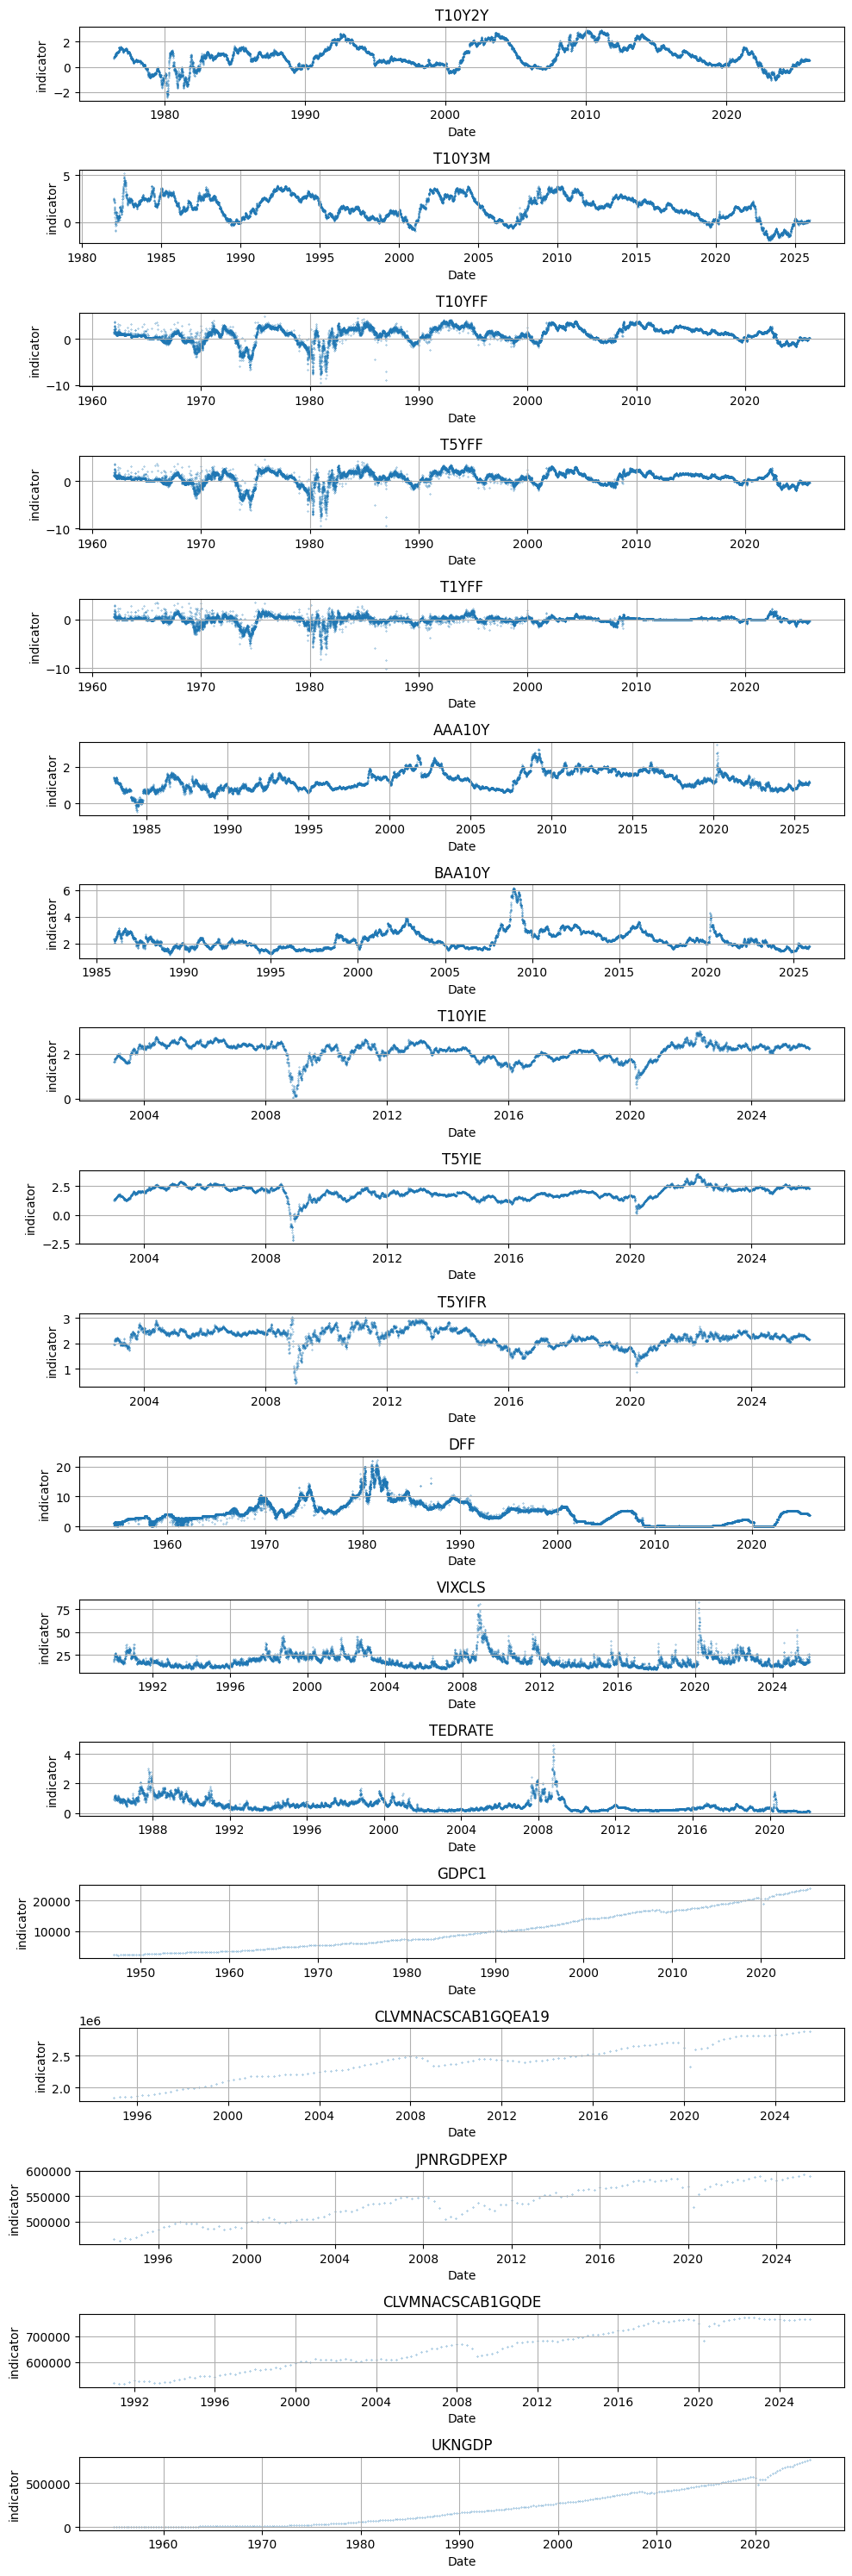

In [24]:
fig, ax = plt.subplots(len(df.columns),figsize=(10,30))
for i,column in enumerate(df.columns):
    df_filtered = df[column].dropna()
    ax[i].scatter(df_filtered.index,df_filtered,0.3,marker = '.')
    ax[i].set_title(column)
    ax[i].set_xlabel("Date")    
    ax[i].set_ylabel("indicator")
    ax[i].grid()

plt.tight_layout()
plt.show()

We can see that there are many outliers in the data. 

## B) Changepoint detection

Important observation: when running the algorithm with values of $\beta$ and $K$ recommended by the paper, we can observe oversegmentation (or sometimes undersegmentation). 

### B)1) With values of $\beta$ and $K$ recommended by the paper

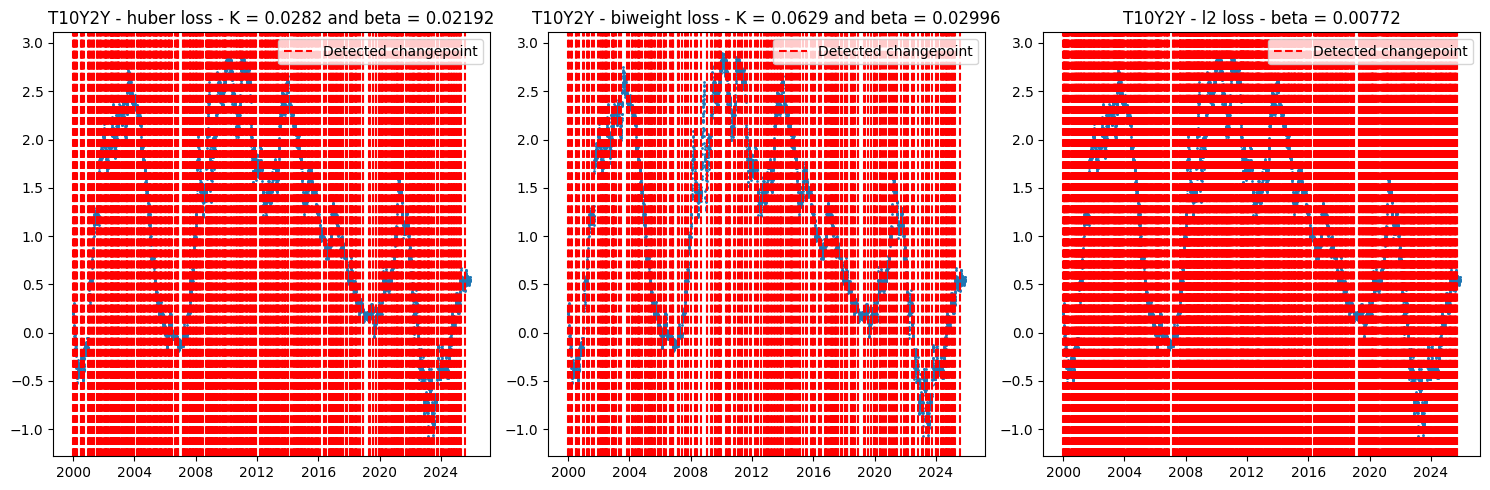

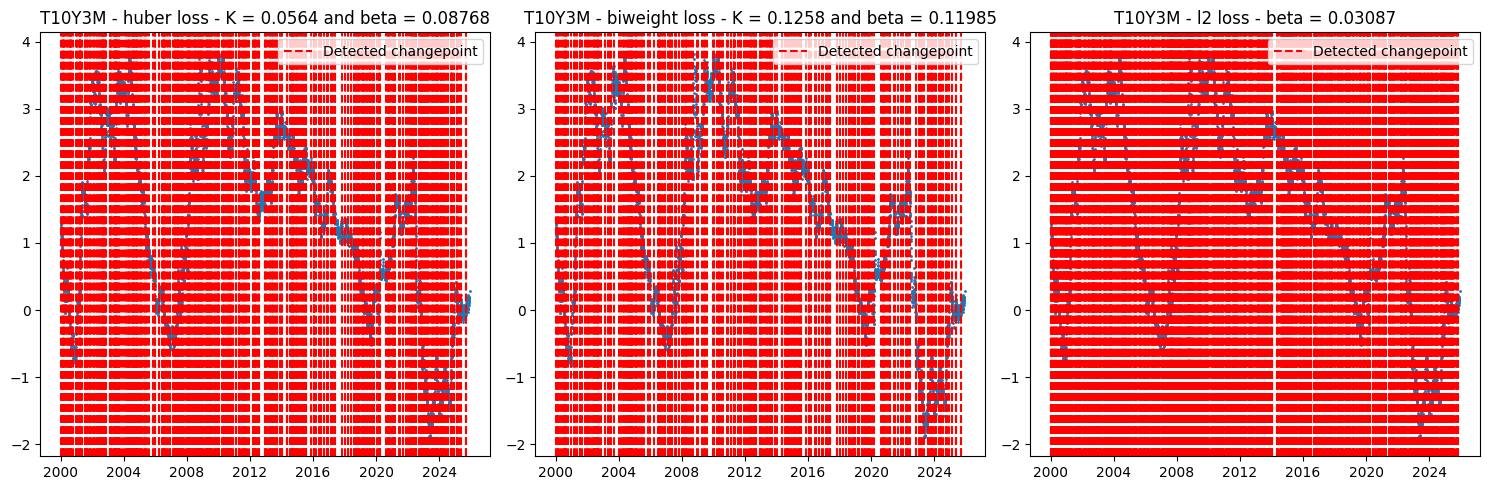

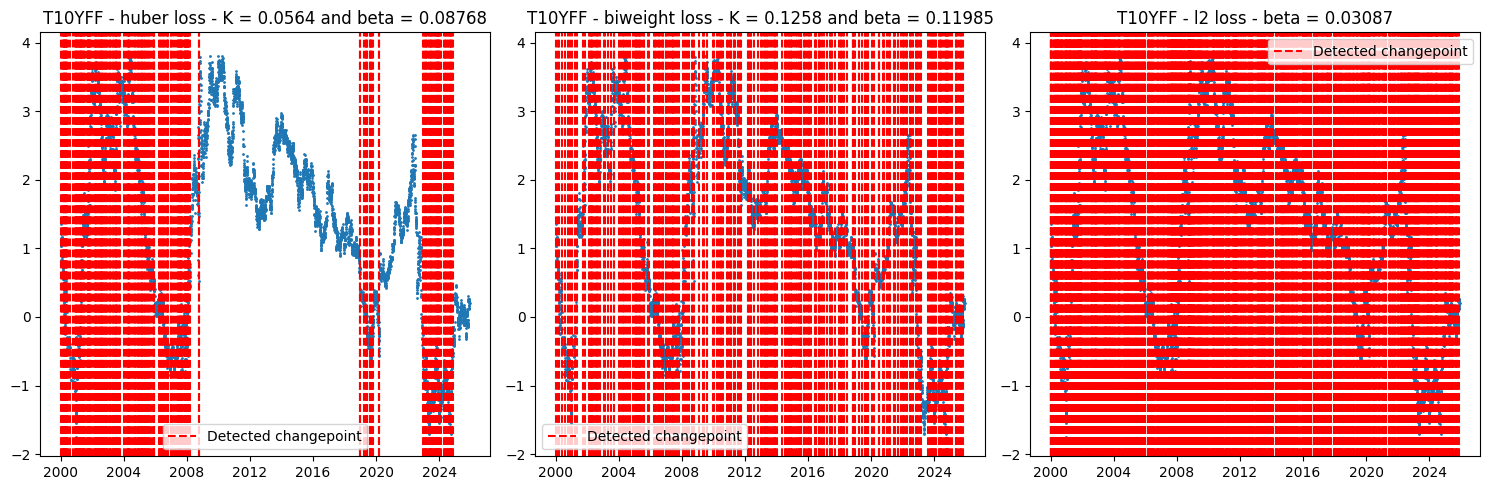

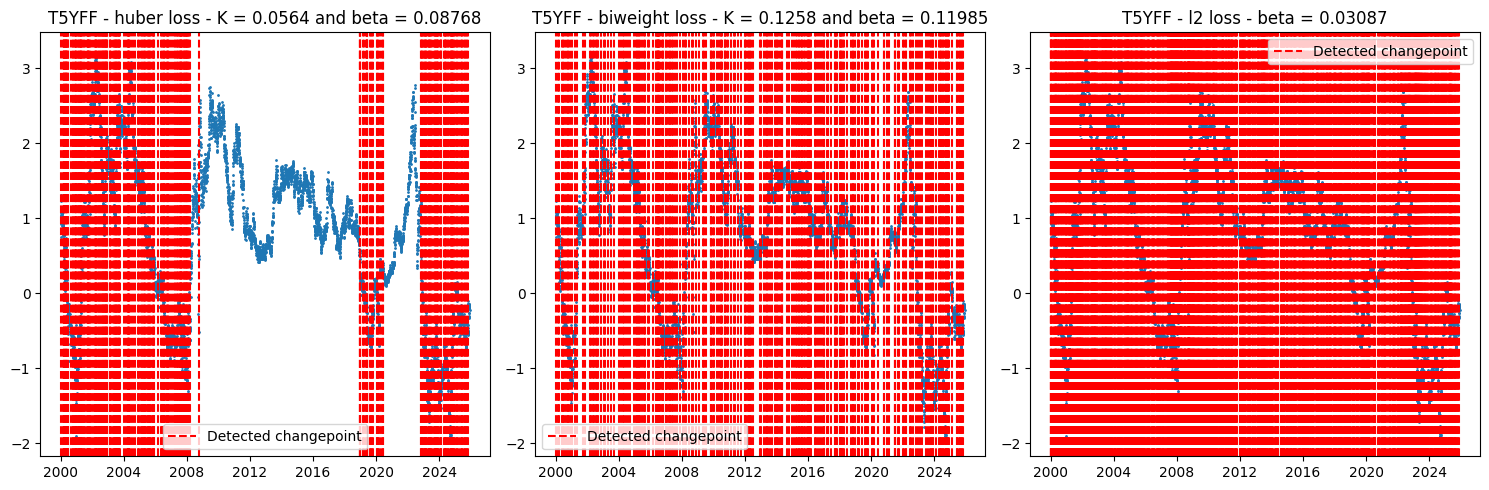

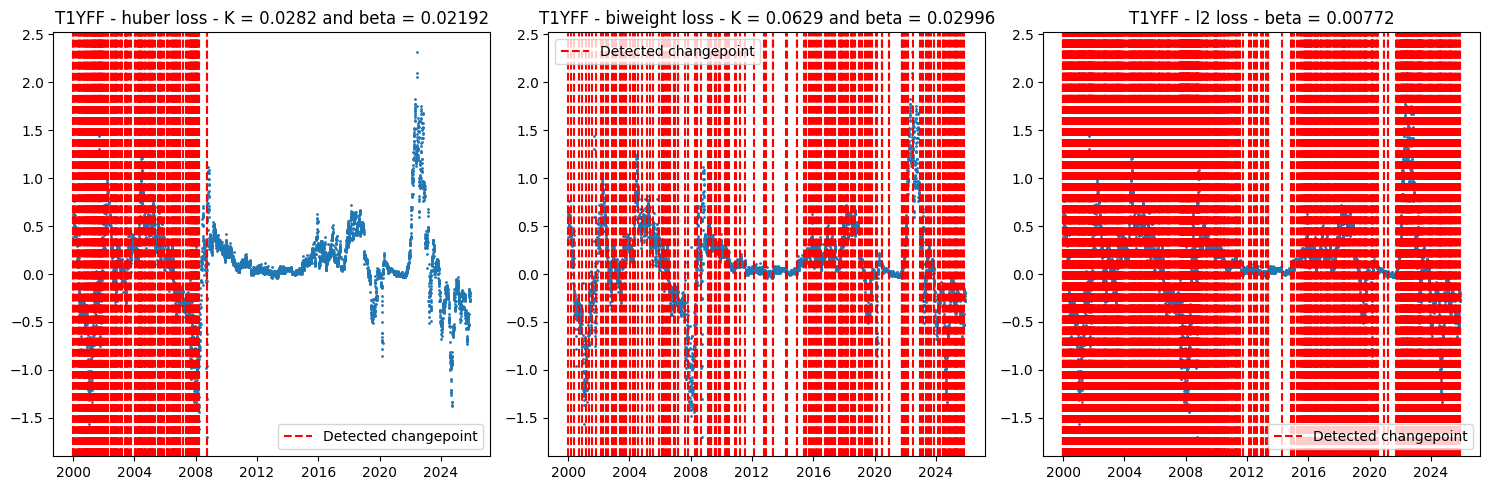

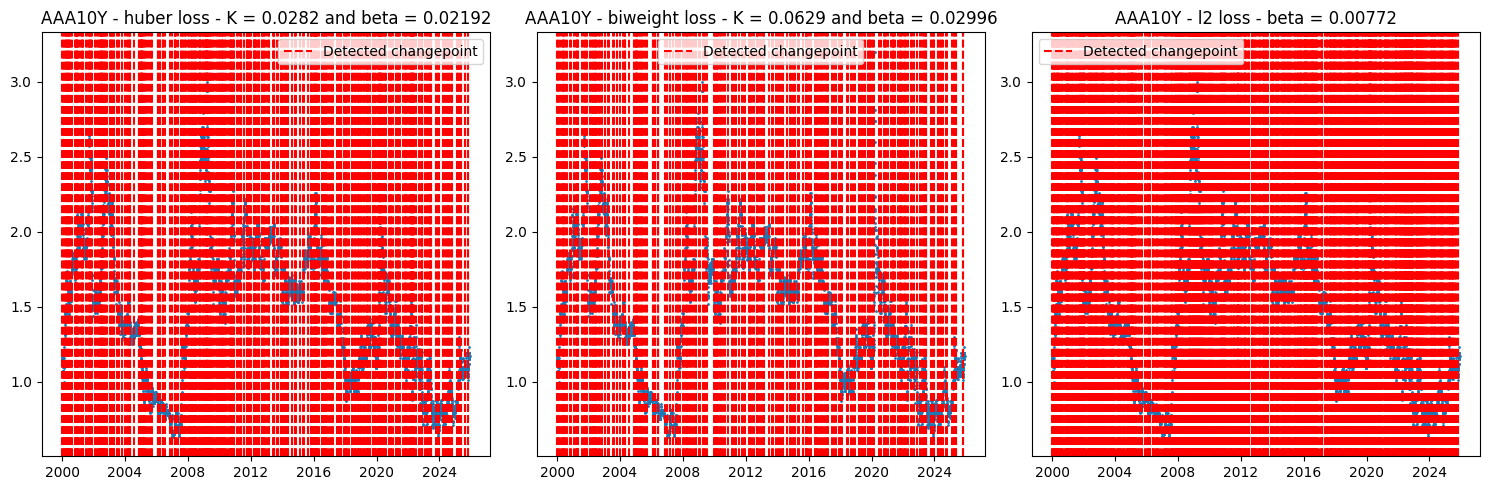

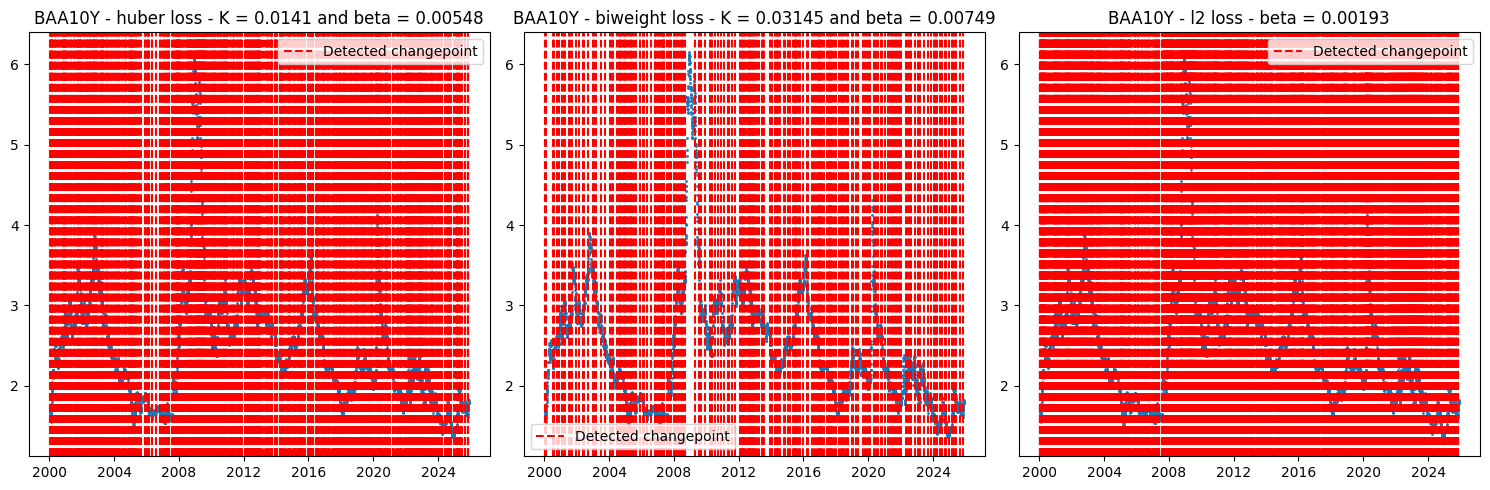

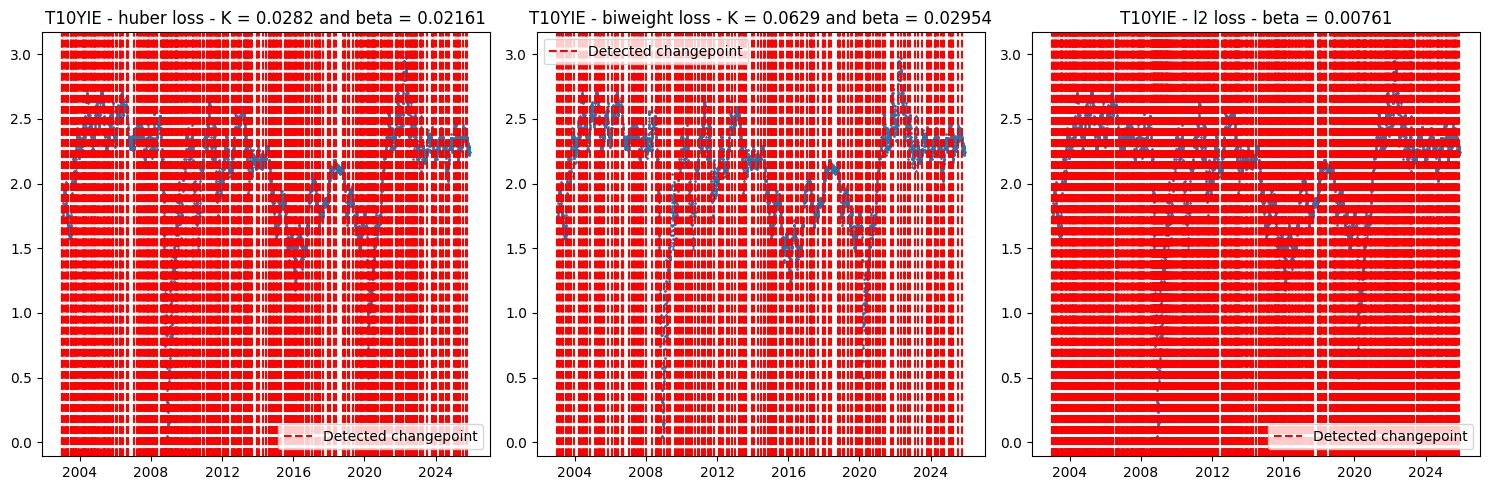

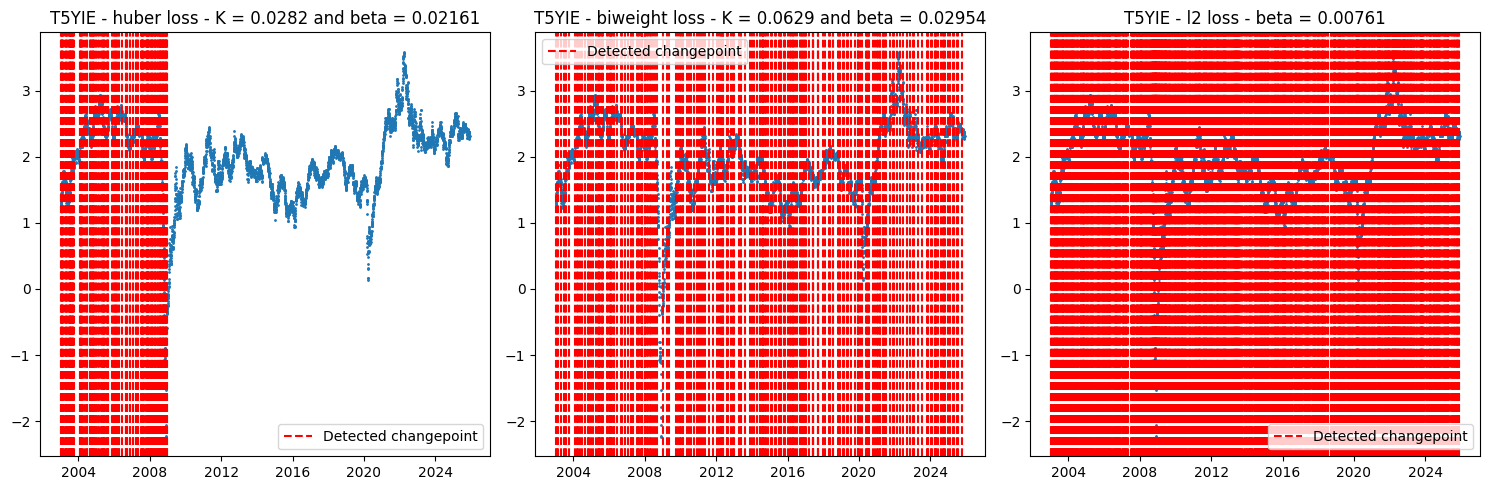

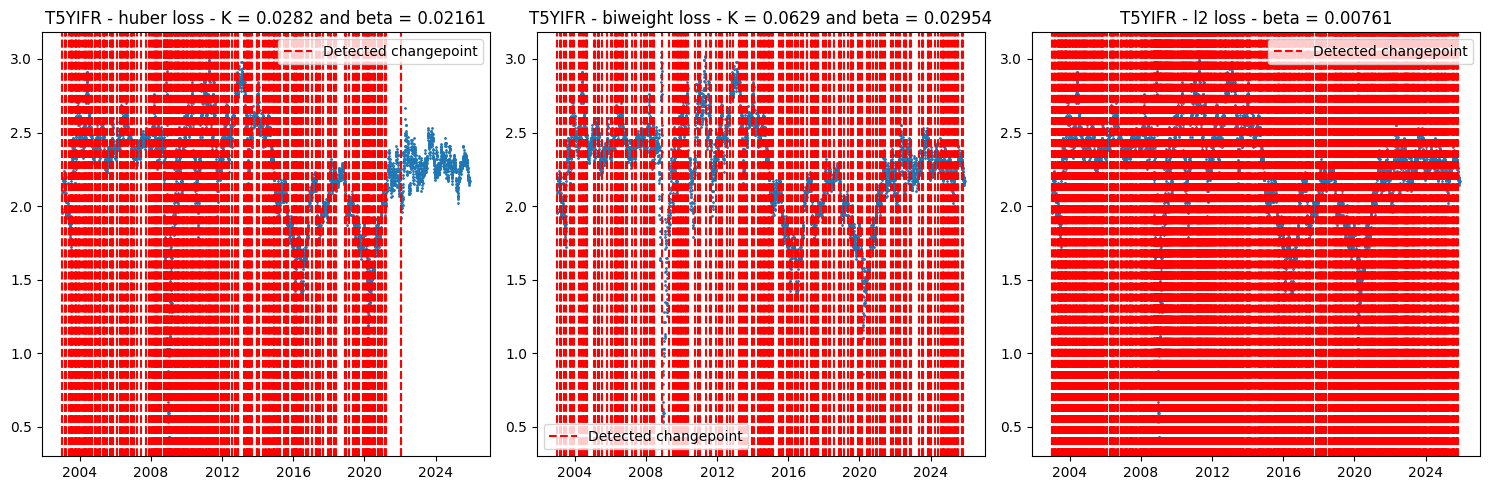

/var/folders/1x/xtzy6z6d7539r5dzrvb9g6x80000gn/T/ipykernel_15288/3446837324.py:61: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/henrifabre/opt/anaconda3/envs/dsd/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


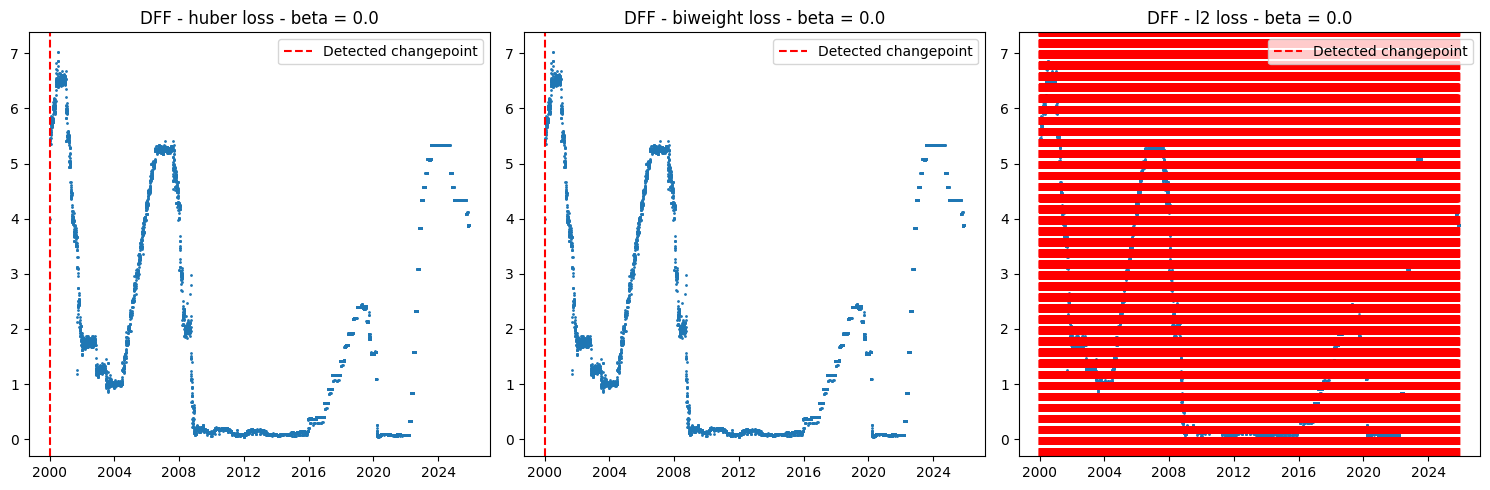

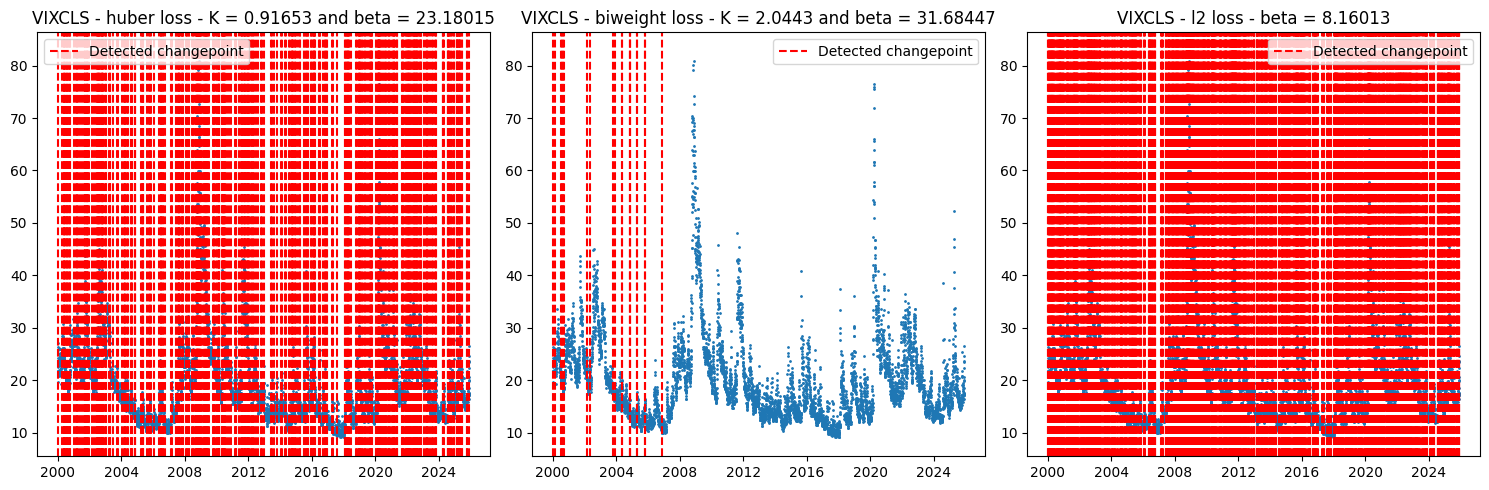

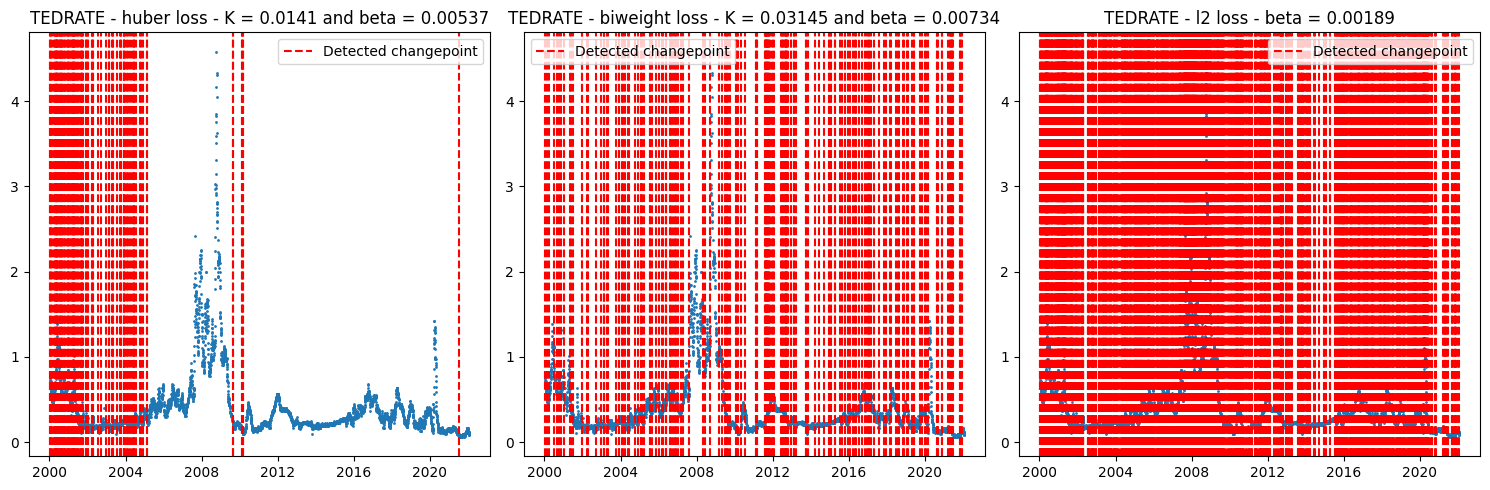

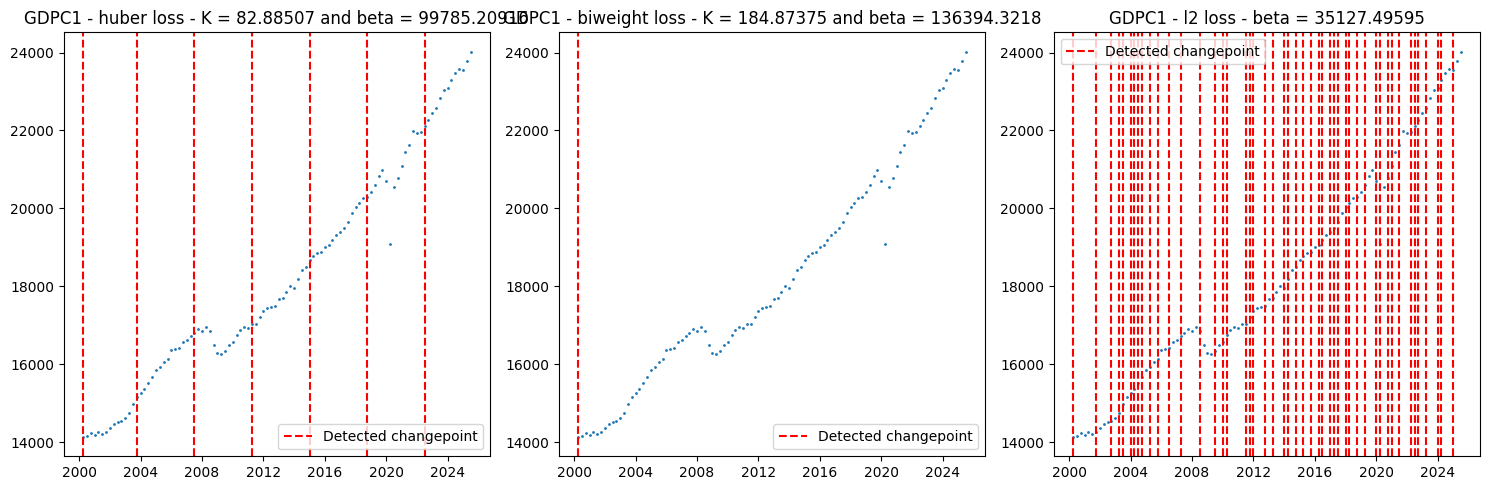

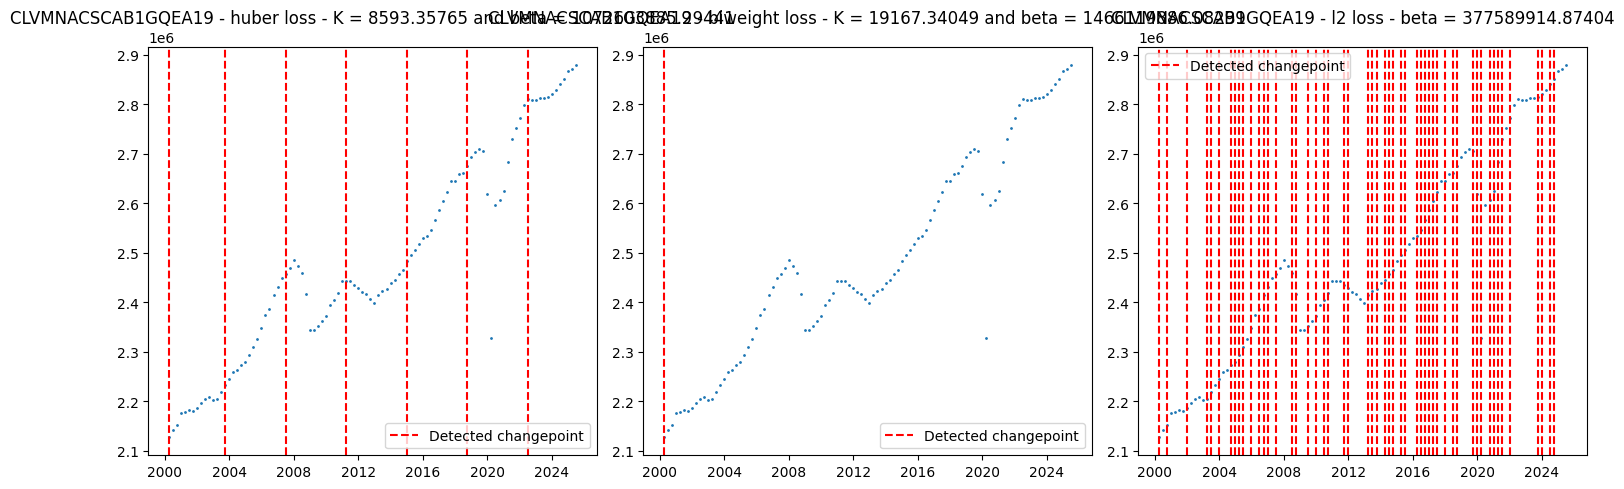

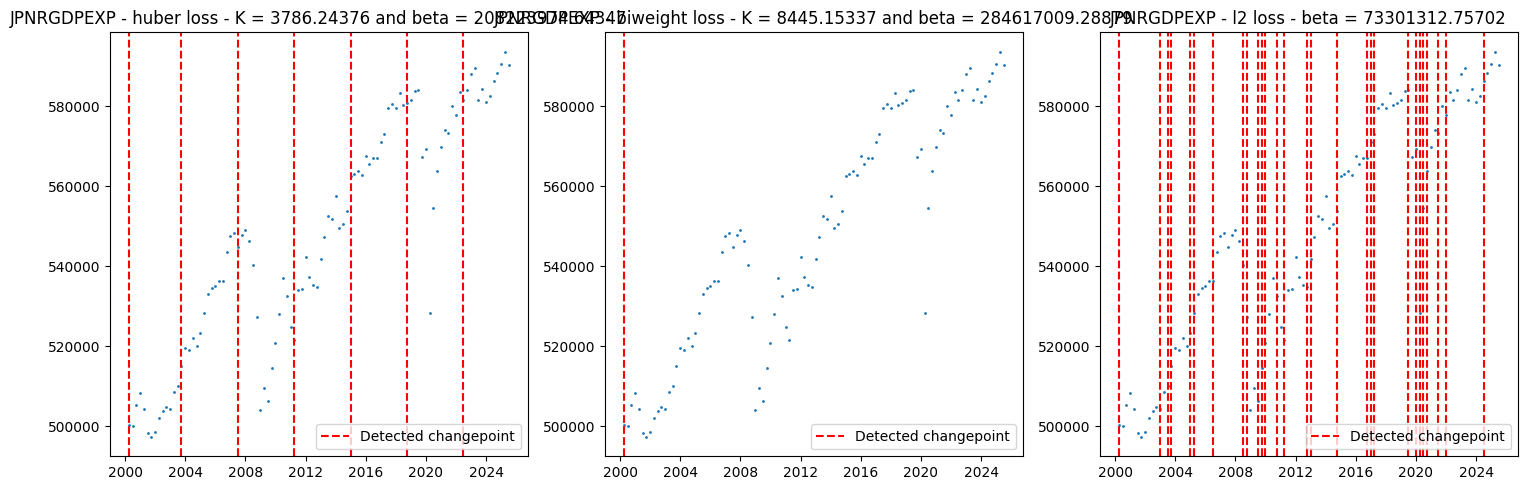

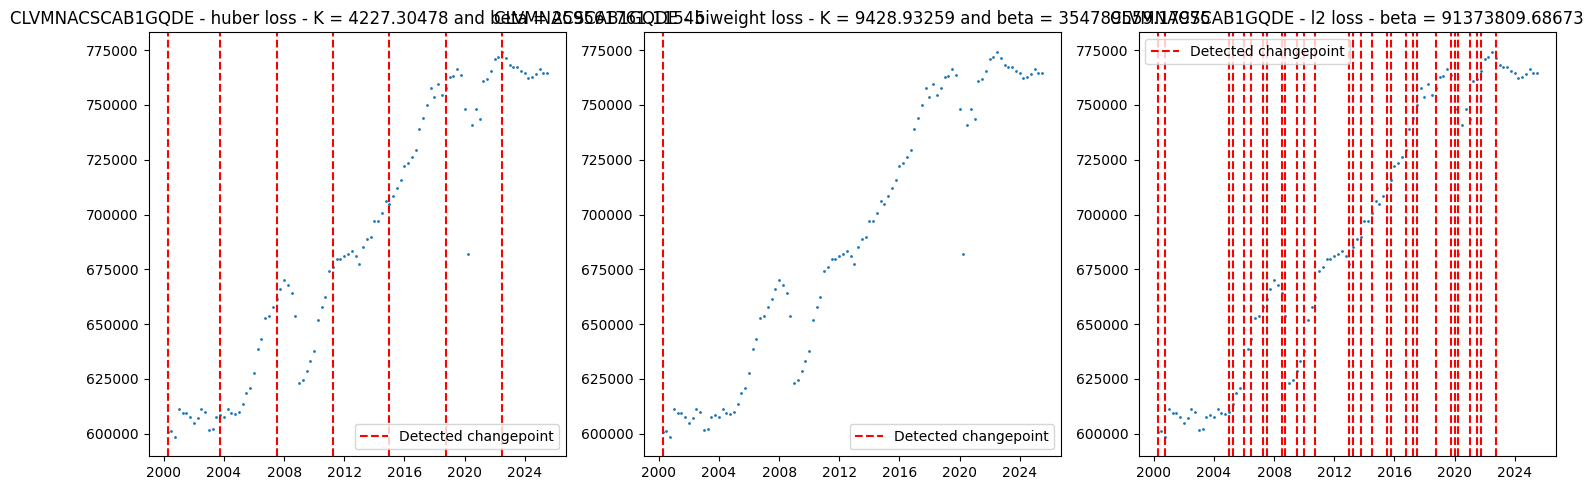

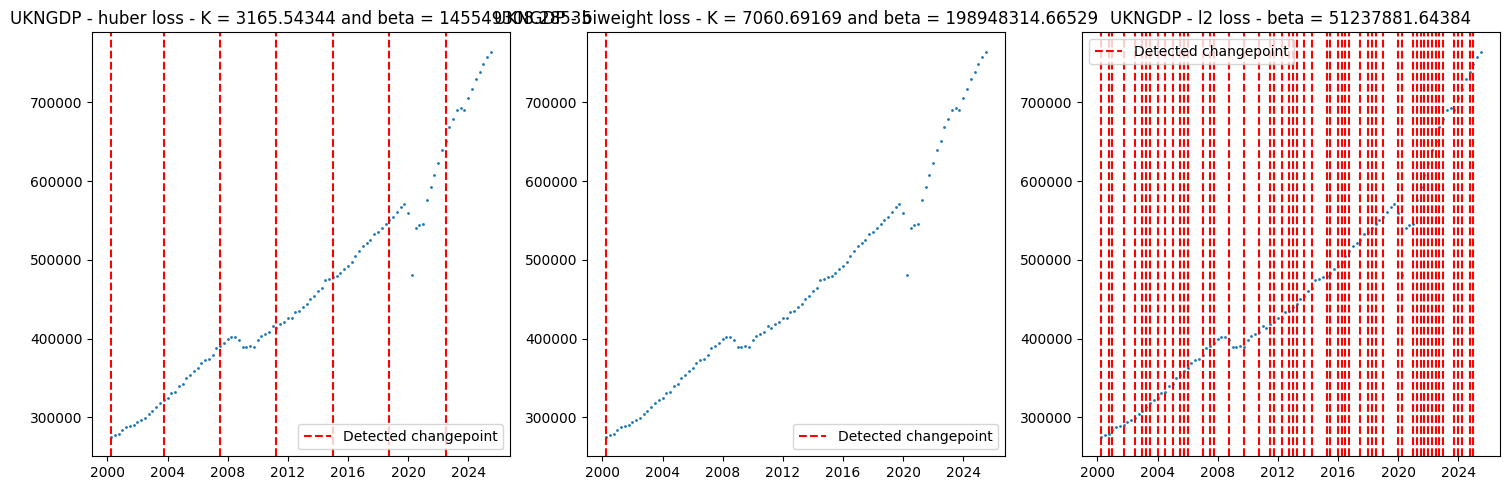

In [25]:
spreads = df.columns

for name in spreads:

    y = df[name].dropna()
    y = y[y.index>'2000']

    fig, axes = plt.subplots(1,3,figsize=(15,5))
    axes = axes.flatten()

    for i,loss in enumerate(['huber','biweight','l2']):
        
        beta = compute_penalty_beta(y,loss)
        K=compute_loss_bound_K(y,loss)
        
        


        if loss == 'huber':
            # if beta/K < len(y)/100:
            #     beta = K*len(y)/100
          
            cp_tau, Qt_vals, Qstar_final = rfpop_algorithm1_main(y, lambda y_t, t: gamma_builder_huber(y_t, K, t), beta)
        elif loss == 'biweight':
    
            cp_tau, Qt_vals, Qstar_final = rfpop_algorithm1_main(y, lambda y_t, t: gamma_builder_biweight(y_t, K, t), beta) 
        elif loss == 'l2':
 
            cp_tau, Qt_vals, Qstar_final = rfpop_algorithm1_main(y, lambda y_t, t: gamma_builder_L2(y_t, t), beta)


        ax = axes[i]

        ax.plot(y, '.', markersize=2)

        changepoints = np.unique(cp_tau)

        cp_dates = []
        for i, date in enumerate(y.index):
            if i in changepoints:
                cp_dates.append(1)
            else:
                cp_dates.append(0)

        cp_dates = pd.Series(cp_dates)
        cp_dates.index = y.index 
    
        for date in cp_dates.index:
                if cp_dates.loc[date] ==1:
            
                    # On trace une ligne rouge pointillée à chaque changepoint
                    ax.axvline(x=date, color='r', linestyle='--', label='Detected changepoint' if date == cp_dates.index[0] else "")
        if not K:
            ax.set_title(f'{name} - {loss} loss - beta = {round(beta,5)}')
        else:
            ax.set_title(f'{name} - {loss} loss - K = {round(K,5)} and beta = {round(beta,5)}')
        # ax.set_xlim(0, len(y))
        ax.legend()
        

    plt.tight_layout()
    plt.show()

### B)2) With values of $\beta$ and $K$ incrementally chosen

In [26]:
good_col = ['T5YIFR','T10YIE','AAA10Y','T5YFF','T10Y2Y',"VIXCLS","TEDRATE"]

In [27]:
def plot_sensitivity_tobeta(df,
                            name, 
                            scaling_list = [1,5,10,50,100,500,1000,5000,10000,50000]): 
    y = df[name].dropna()
    y = y[y.index>'2000']

    fig, axes = plt.subplots(1,3,figsize=(15,5))
    axes = axes.flatten()

    for i,loss in tqdm(enumerate(['huber','biweight','l2'])):
        
        beta = compute_penalty_beta(y,loss)
        K=compute_loss_bound_K(y,loss)
        
        list_scaling = np.array(scaling_list)*beta
        nb_changepoints = []

        for scaling in list_scaling:
            if loss == 'huber':
                cp_tau, Qt_vals, Qstar_final = rfpop_algorithm1_main(y, lambda y_t, t: gamma_builder_huber(y_t, K, t), scaling)
            elif loss == 'biweight':
                cp_tau, Qt_vals, Qstar_final = rfpop_algorithm1_main(y, lambda y_t, t: gamma_builder_biweight(y_t, K, t), scaling) 
            elif loss == 'l2':
                cp_tau, Qt_vals, Qstar_final = rfpop_algorithm1_main(y, lambda y_t, t: gamma_builder_L2(y_t, t), scaling)

            nb_changepoints.append(len(set(cp_tau)))

        ax = axes[i]
        ax.plot(scaling_list,nb_changepoints)
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("beta scaling factor (logscale)")
        ax.set_ylabel("number of detected changepoints (logscale)")
        ax.set_title(f'{name} - {loss} loss: number of changepoints detected')

    plt.tight_layout()
    plt.show()


def plot_segments(df,name,scaling_huber,scaling_biweight,scaling_l2):
    
    y = df[name].dropna()
    y = y[y.index>'2000']

    fig, axes = plt.subplots(1,3,figsize=(15,5))
    axes = axes.flatten()

    for i,loss in tqdm(enumerate(['huber','biweight','l2'])):
        
        beta = compute_penalty_beta(y,loss)
        K=compute_loss_bound_K(y,loss)
        
        if loss == 'huber':
            cp_tau, Qt_vals, Qstar_final = rfpop_algorithm1_main(y, lambda y_t, t: gamma_builder_huber(y_t, K, t), beta*scaling_huber)
        elif loss == 'biweight':
            cp_tau, Qt_vals, Qstar_final = rfpop_algorithm1_main(y, lambda y_t, t: gamma_builder_biweight(y_t, K, t), beta*scaling_biweight) 
        elif loss == 'l2':
            cp_tau, Qt_vals, Qstar_final = rfpop_algorithm1_main(y, lambda y_t, t: gamma_builder_L2(y_t, t), beta*scaling_l2)

        ax = axes[i]
        ax.plot(y, '.', markersize=2)
        changepoints = np.unique(cp_tau)
        t = len(y) - 1
        segments = []
        
        while t > 0:
            # Le début du segment actuel est indiqué par cp_tau[t]
            t_prev = int(cp_tau[t])
            # On enregistre le segment (start_index, end_index)
            segments.append((t_prev, t))
            # On recule
            t = t_prev
            
        segments.reverse() # On remet dans l'ordre chronologique

        # 3. Calcul de la moyenne de chaque segment
        for start_idx, end_idx in segments:
        
            segment_data = y.iloc[start_idx : end_idx + 1]
            seg_mean = segment_data.mean()
            
            # Récupération des dates pour l'axe X
            date_start = y.index[start_idx]
            date_end = y.index[end_idx] # La date du dernier point du segment

        
            ax.plot([date_start, date_end], [seg_mean, seg_mean], 
                    color='black', linewidth=2, label='Mean on each segment' if start_idx == 0 else "")
            
        
            if end_idx < len(y) - 1:
                ax.axvline(x=date_end, color='r', linestyle='--', alpha=0.5)

        if loss == 'l2':
            ax.set_title(f'{name} - {loss} loss\nbeta = {round(beta*scaling_l2, 1)}')
        elif loss == 'huber':
            ax.set_title(f'{name} - {loss} loss\nK = {round(K, 1)} | beta = {round(beta*scaling_huber, 1)}')
        elif loss == 'biweight':
            ax.set_title(f'{name} - {loss} loss\nK = {round(K, 1)} | beta = {round(beta*scaling_biweight, 1)}')
        
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys())

    plt.tight_layout()
    plt.show()

### i) T5YIFR

0it [00:00, ?it/s]

3it [03:01, 60.54s/it]


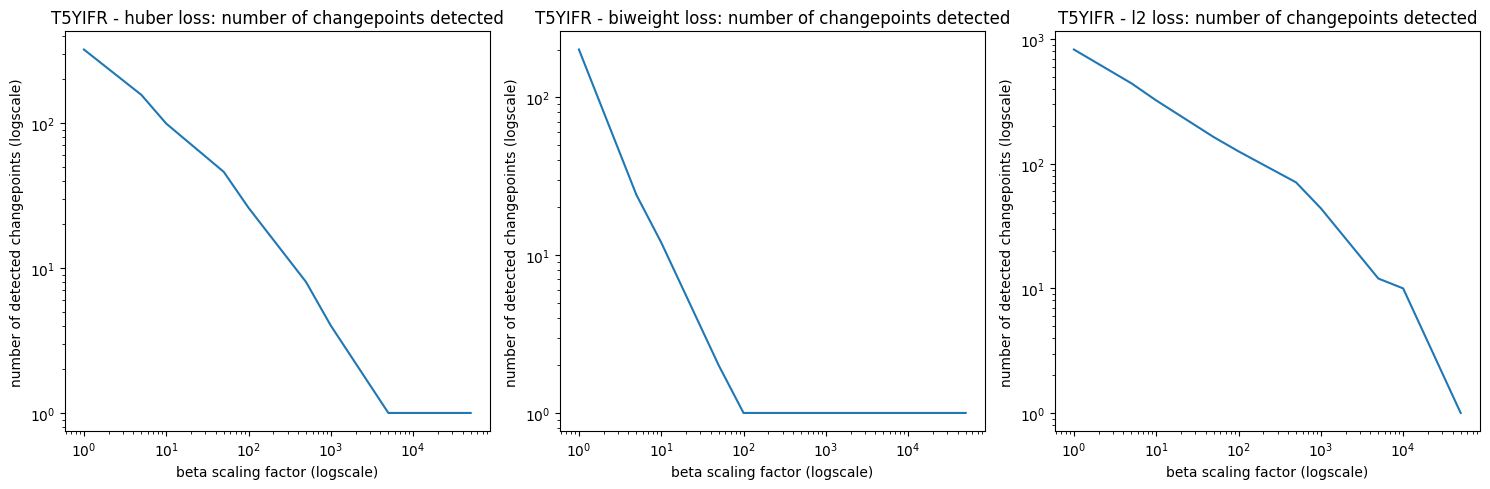

In [28]:
name = 'T5YIFR'

plot_sensitivity_tobeta(df,name)

The plots above represent the variation of number of changepoints detected by the algorithm for each loss, depending on the scaling factor of the penalty parameter (with x and y axis in logscale). For instance, when using the huber loss:
- if we use the $\beta$ recommended by the paper (beta scaling factor = 1), the algorithm will detect approximately 10^3 changepoints on the T5YIFR series. 
- if we use 10*$\beta$ (beta scaling factor = 10), the algorithm will detect approximately 100 changepoints on the T5YIFR series. 
- if we use 1000*$\beta$ (beta scaling factor =1000), the algorithm will detect approximately 5 changepoints on the T5YIFR series.

From this plot, we see that Huber and $\ell_2$ loss penalty parameter is easier to choose as it is less sensible to small variations in the scaling factor of $\beta$. This is a pro of using the Huber loss or $\ell_2$ loss compared to the biweight loss.

3it [00:11,  3.91s/it]


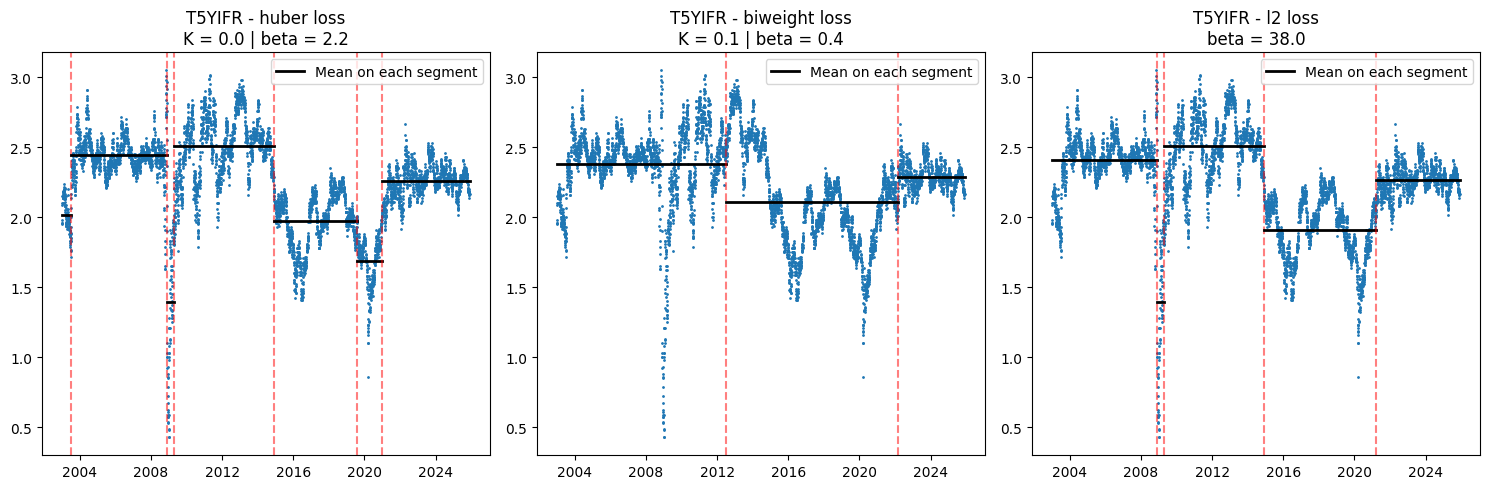

In [29]:
plot_segments(df,'T5YIFR',scaling_huber=100,scaling_biweight=12,scaling_l2=5000)

**Analysis of Structural Breaks in 5-Year Forward Inflation Expectations (T5YIFR)**

The application of the RFPOP algorithm on the T5YIFR series successfully identifies the major eras of recent US monetary history. All three loss functions detect the structural break of 2014 (the shift to a low-inflation regime) and the inflationary shock of 2021 (Post-Covid and Ukraine war inflation), validating the economic relevance of the changepoint detection algorithm on this time series.

**Comparison of Loss Functions**

* **L2 (Right) & Huber (Left) – The investor view:**
These algorithms seem to be more reactive to amplitude. They interpret the 2008 Global Financial Crisis and the 2020 COVID shock as distinct regimes. This aligns with market history, reflecting periods where investors genuinely priced in a high risk of deflation. These models capture the volatility of market fear.
* **Biweight (Center) – The economist view:**
The Biweight loss provides the most distinct interpretation: it treats the 2008 and 2020 crashes as outliers rather than structural changes. It suggests that despite the market panic in 2008, long-term inflation expectations remained structurally anchored until 2014. It filters out the noise of the COVID crisis to focus only on the trend. From a monetary policy evaluation perspective, this model is the most valuable as it distinguishes between temporary market panic (viewed as outliers) and true structural shifts in inflation anchoring.

We've seen that the biweight loss tends to penalize more and select less changepoints as it is more sensible to an increase in the size of $\beta$. Hence, the biweight loss may be more convenient to use to detect long term economic trends while L2 and huber loss are more useful to detect short term breaks. Notice that we can still get exactly the same results with all the 3 losses by playing with $\beta$.

Notice that with an appropriate $\beta$, the L2 loss gives very similar results to the Huber loss, so maybe the use of the Huber loss is not so relevant.

### ii) T10YIE

0it [00:00, ?it/s]

0it [00:48, ?it/s]


KeyboardInterrupt: 

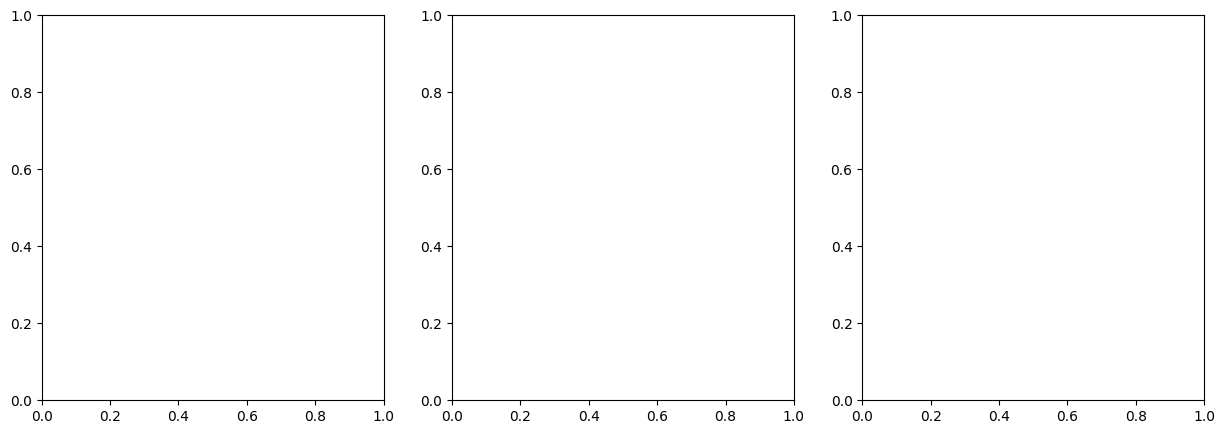

In [30]:
plot_sensitivity_tobeta(df,'T10YIE')

We see a similar sensitivity of number of changepoints as a function of the size of the penalty term: number of changepoints detected by Huber loss and $\ell_2$ loss is less sensitive to an increase in $\beta$ than number of changepoints detected by biweight loss.

3it [00:13,  4.49s/it]


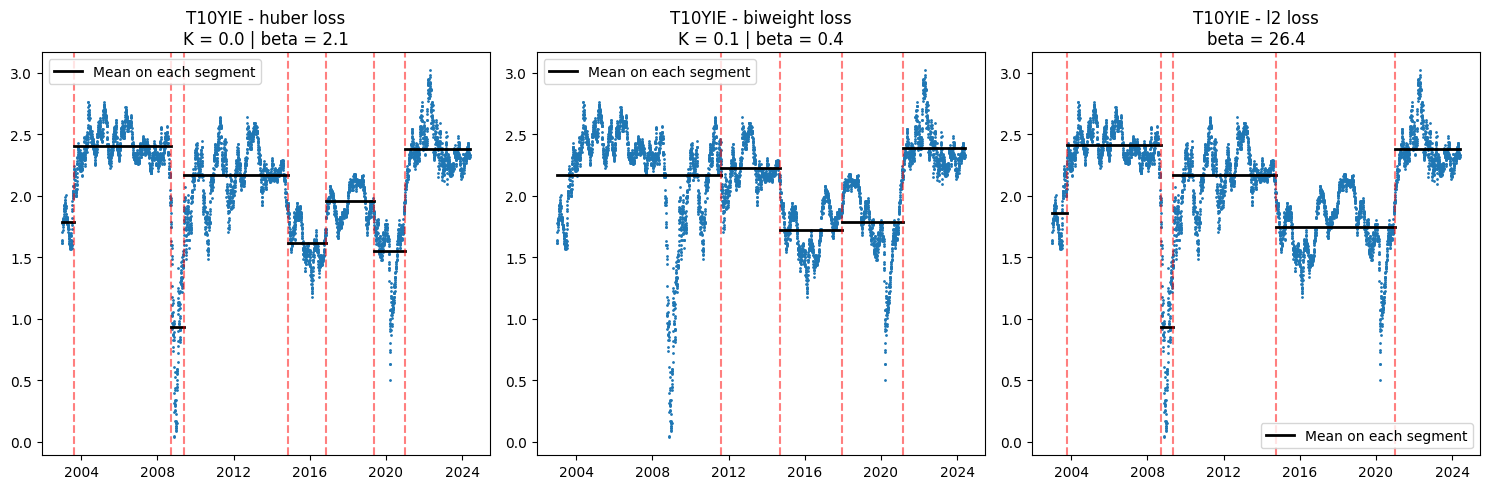

In [ ]:
plot_segments(df,'T10YIE',scaling_huber=100,scaling_biweight=14,scaling_l2=3500)

The T10YIE (10-Year Breakeven Inflation Rate) series represents the market's average inflation expectation over the next 10 years. It differs slightly from the previous series (T5YIFR) because it includes the near term (the next 5 years), making it more sensitive to immediate shocks like oil price crashes or liquidity crises.

### **Historical Analysis of Identified Regimes**

The algorithms have successfully segmented the last 20 years of US inflation history into distinct economic chapters.
- **pre-2008:** a stable plateau around 2.4%. This was an era in which markets were confident the FED had inflation perfectly under control.
- **2008: GFC liquidity crisis**. In late 2008, the TIPS (inflation-protected bonds) market suffered a liquidity crisis. Investors sold everything to get cash. This artificially depressed TIPS prices, making the Breakeven inflation Rate collapse. It wasn't necessarily that people expected 0% inflation for 10 years, but rather that the instrument measuring it was broken.
- **Period 2: 2014 - 2016: The Oil Shock**. In late 2014, oil prices crashed from $100 to $40. Since T10YIE includes near-term inflation (which is heavily driven by energy), expectations were repriced lower, from 2.4% to 1.7% on average. 
- **Period 3: Post-2021 (The Return of Inflation)**. Markets repriced a structural return to higher inflation due to fiscal stimulus after the covid crisis and supply chain shocks caused by Ukraine war. 

#### **L2 (Right) & Huber (Left): the investor's view**
- In 2008 and 2020, both algorithms create a specific, deep segment to account for the GFC and Covid crash.
- Interpretation: these models are more sensible to outliers than the biweight loss and consider short term volatility periods caused by crash as distinct regime change, however brief. This makes sense from an investor as large volatility periods are tremendously important for them. 
- L2 / Huber accurately depicted the financial stress and volatility of the market (detecting the crises).

#### **Biweight (Center): the economist view**
- The Biweight loss sees the 2008 and 2020 crashs as outliers. Instead of breaking the segment and creating a crisis regime, it chose to ignore the data points as noise and maintain the long-term anchor.
- As a result, it bridges 2005–2014 as a mostly continuous regime of stable expectations, filtering out the GFC and Covid volatility to show only the structural step-down in 2014 and the structural step-up in 2021.
- Biweight accurately depicted the fundamental economic anchor, arguing that the 2008 and 2020 market crashes were liquidity events, not fundamental shifts in long-term inflation expectations.

Once again, thanks to its larger sensitivity to size of penalty and to its propension to penalize more, the Biweight model seems more relevant to analyse economic periods without taking into account the noise of market panic.

### iii) AAA10Y

3it [03:08, 62.89s/it]


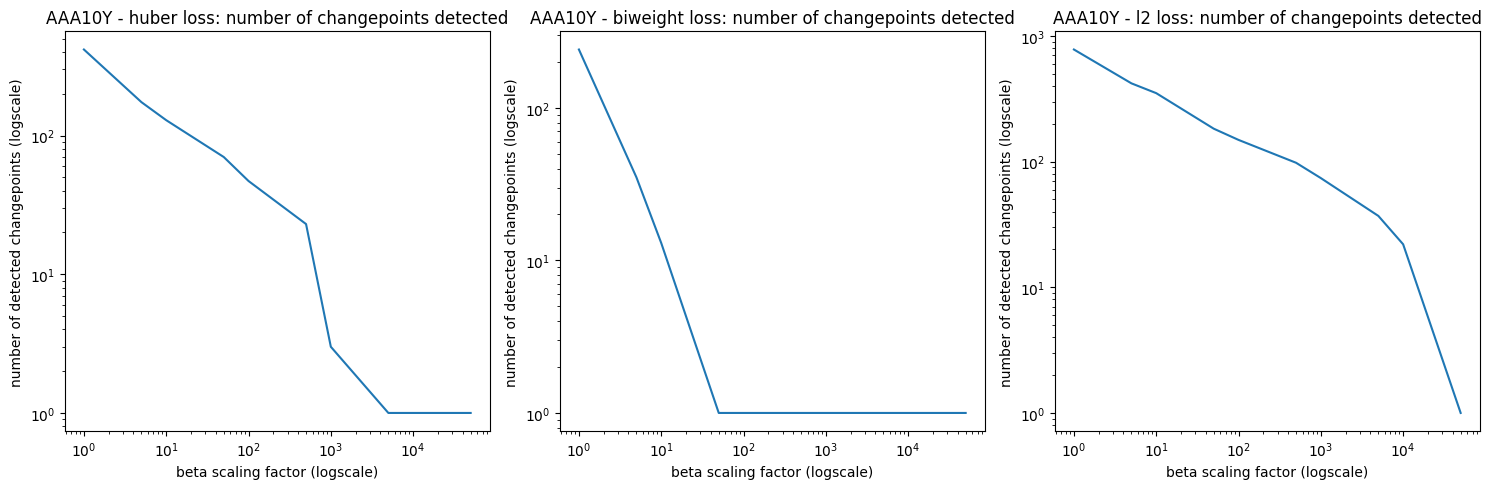

In [ ]:
plot_sensitivity_tobeta(df,'AAA10Y')

0it [00:00, ?it/s]

3it [00:17,  5.93s/it]


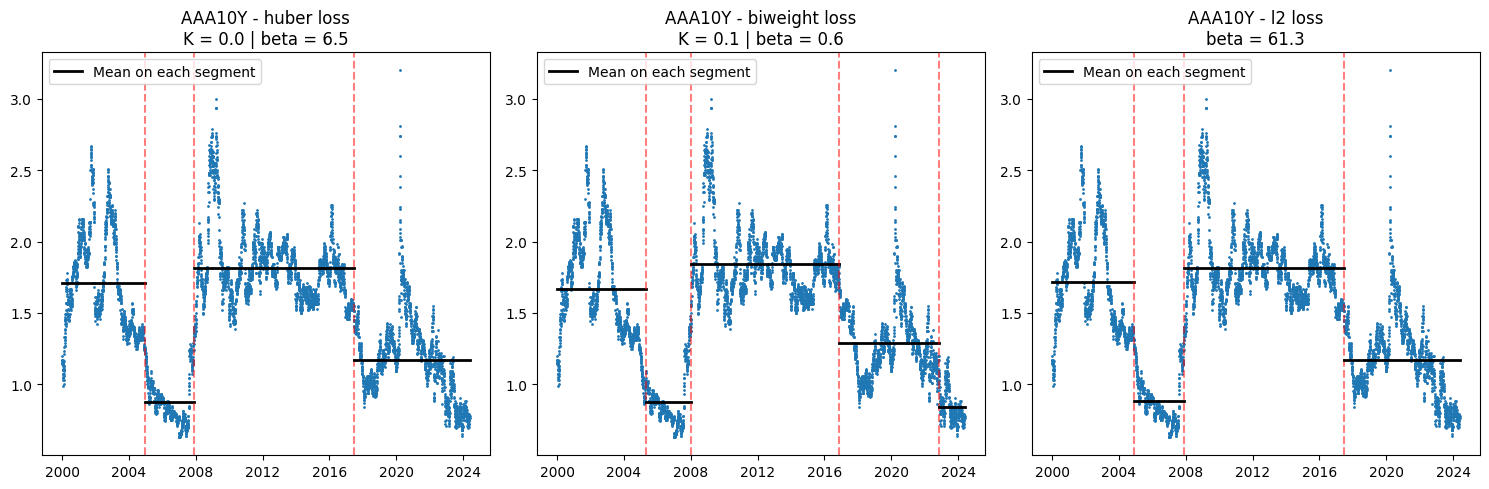

In [ ]:
plot_segments(df,'AAA10Y',scaling_huber=300,scaling_biweight=20,scaling_l2=8000)

This indicator a proxy for the Credit Spread or the risk premium on high-grade corporate debt.

### **Historical Interpretation of Regimes**

* **2000 – 2004: Post-Dotcom Risk Aversion**, characterized by high spreads. Following the Dotcom crash and the accounting scandals (Enron, WorldCom), investors demanded a high premium to hold corporate debt.
* **2004 – 2007: The "Credit Boom"**, characterized by historically low spreads (< 1.0%). This corresponds to the pre-2008 bubble. Liquidity was abundant, and investors compressed risk premiums to unsustainable lows. 
* **2008 – 2016: The Crisis & Post-Crisis "New Normal"**, characterized by another structural increase in spread. The 2008 Global Financial Crisis permanently repriced risk. Even after the panic subsided, spreads remained structurally elevated compared to 2005 due to tighter banking regulations (Basel III) and economic uncertainty (Eurozone crisis 2011).
* **2017 – Present: The Modern Low-Spread Era**, characterized by a moderate decrease (~1.2% - 1.3%). Corporate tax cuts (2017) and continued Central Bank support helped compress spreads again.

### **Comparison of Algorithms**
- The three models treat the 2008-2016 period as a single period. 
- The biweight model is the only one to create a specific period after 2024. This is a relevant split that has been commented a lot in the economic and financial news litterature recently. 

### iv) T10Y2Y

3it [04:04, 81.58s/it] 


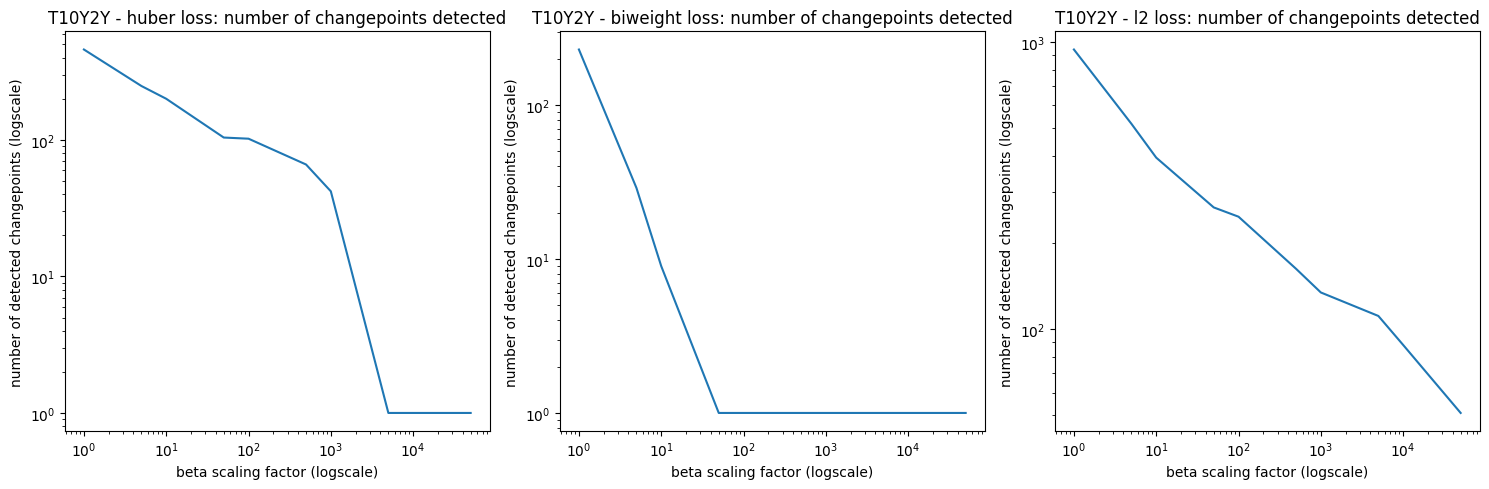

In [ ]:
plot_sensitivity_tobeta(df,"T10Y2Y")

3it [00:14,  4.91s/it]


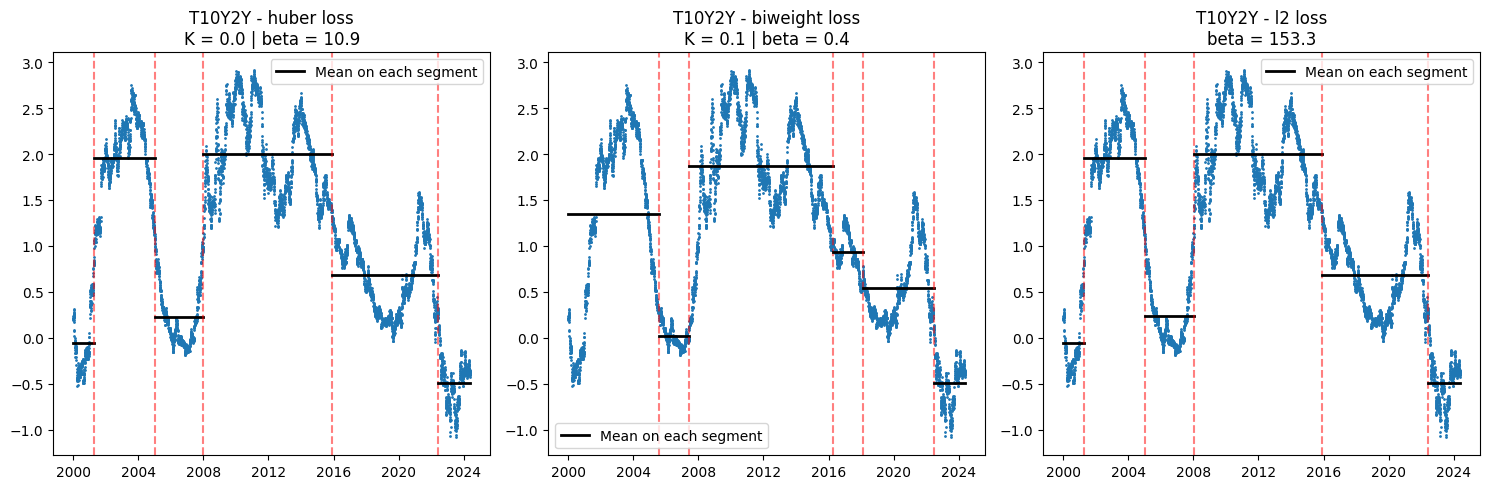

In [ ]:
plot_segments(df,'T10Y2Y',scaling_huber=500,scaling_biweight=12,scaling_l2=20000)

This indicator represents the slope of the yield curve: a steep positive slope suggests healthy economic growth expectations, while a negative slope is a predictor of an incoming recession.

### Historical Interpretation of Regimes

* **2000 – 2003: The Post-Dotcom Steepening**, characterized by a rapid shift from inversion to a steep curve. As the tech bubble burst, the Fed cut short-term rates aggressively, normalizing the curve.
* **2004 – 2007: The Pre-Crisis Inversion**, characterized by a steady flattening and eventual inversion.
* **2008 – 2016: The ZIRP Era**, characterized by a historically steep curve. With the Fed holding short-term rates at zero to stimulate recovery, the spread widened significantly as long-term yields remained higher.
* **2022 – Present: The Great Inversion**, characterized by the deepest inversion since the early 1980s. The Fed hiked rates aggressively to fight inflation resulting in Covid pandemic and Ukraine war, pushing short-term yields well above long-term yields.

### Comparison of Algorithms

* All three algorithms give similar results. The segmentation produced by the biweight loss is a bit less relevant than the other losses (no changepoint in 2003).

### v) VIXCLS

3it [10:03, 201.10s/it]


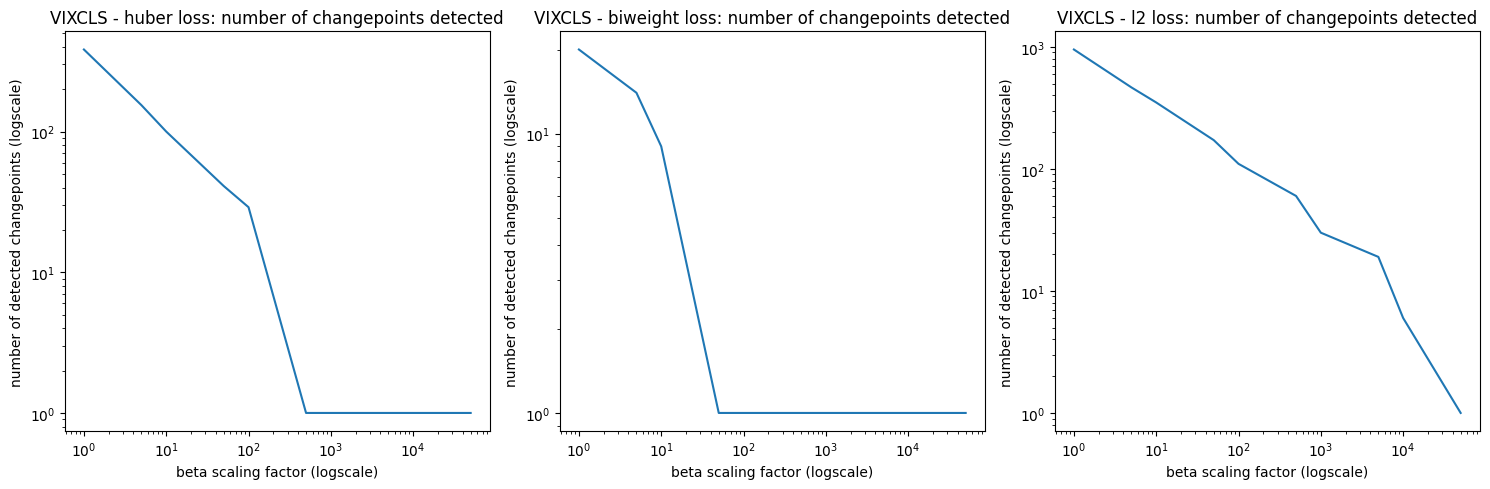

In [ ]:
plot_sensitivity_tobeta(df,'VIXCLS')

3it [00:19,  6.65s/it]


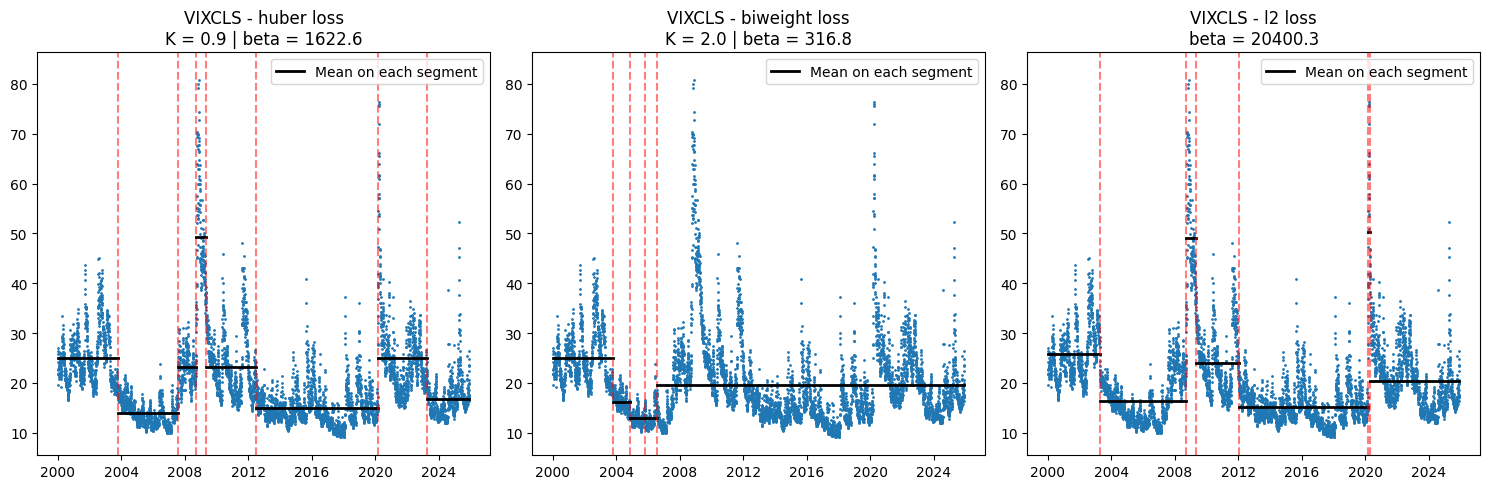

In [ ]:
plot_segments(df,'VIXCLS',scaling_huber=70,scaling_biweight=10,scaling_l2=2500)

VIXCLS acts as the "fear gauge" of the market, measuring the implied volatility of the main US index over the next 30 days.

### **Historical Interpretation of Regimes**

* **2000 – 2003: The Dotcom bubble**, characterized by elevated volatility (~25). Markets remained nervous following the tech bubble burst and the 9/11 attacks.
* **2004 – 2007: The Great Moderation**, characterized by historically low volatility (~13-15). This was the era of the "Central Bank Put" and extreme complacency before the GFC, where the VIX frequently dipped below 10.
* **2008 – 2011: The Crisis Era**, characterized by massive spikes and a high floor. The VIX hit its all-time highs during the Lehman collapse, and fear persisted through the initial Eurozone crisis.
* **2012 – 2019: low volatility period**, characterized by a return to suppressed volatility. Quantitative Easing (QE) dampened market swings. 
* **2020 – 2022**, new high volatility regime caused by Covid and Ukraine war and inflation. 
* **2023-now**, back to more reasonable levels.

### **Comparison of Algorithms**
* Huber and L2 loss model perform well and identify all these periods; we could question the relevance of the specific segment identified in 2008 (and 2020 for L2). 
* Biweight (Center):The results here are extremely poor and economically meaningless, even by trying many different penalty values. The VIX is an indicator where the outliers are the signal. By treating the massive spikes of 2008 (GFC) and 2020 (Covid) as "outliers" to be ignored, the Biweight model averages the panic of 2008 with the calm of 2017.

### **Idea: robust loss functions are ill-suited for series where extreme values represent the primary regime of interest.**

### vi) TEDRATE 

0it [00:00, ?it/s]

3it [01:03, 21.19s/it]


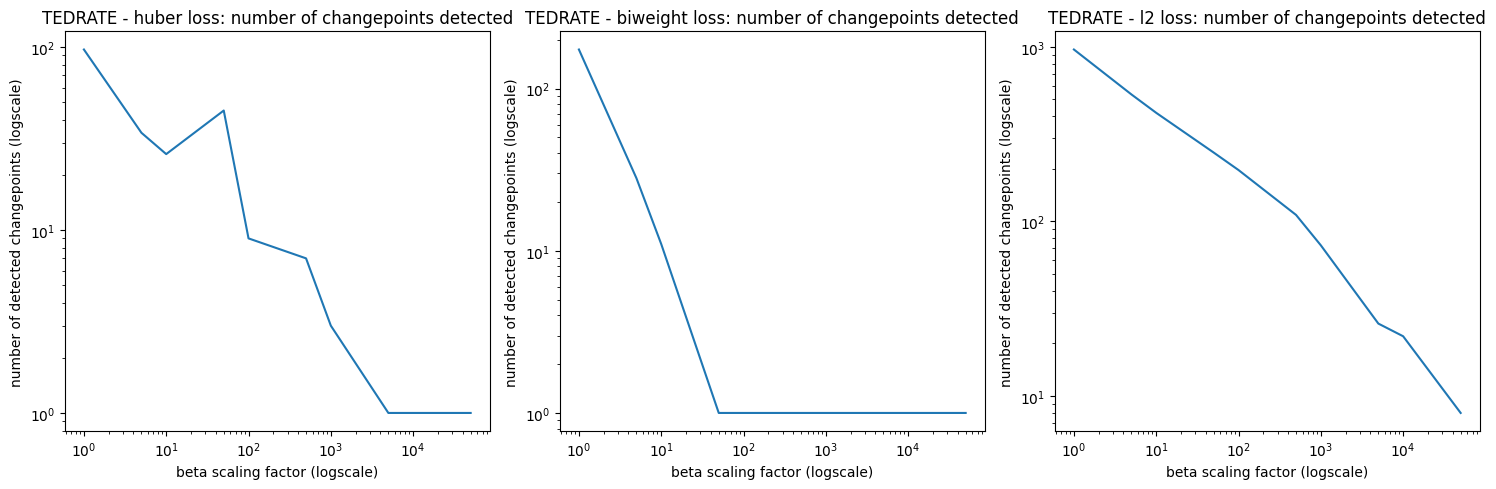

In [ ]:
plot_sensitivity_tobeta(df,'TEDRATE')

3it [00:08,  2.71s/it]


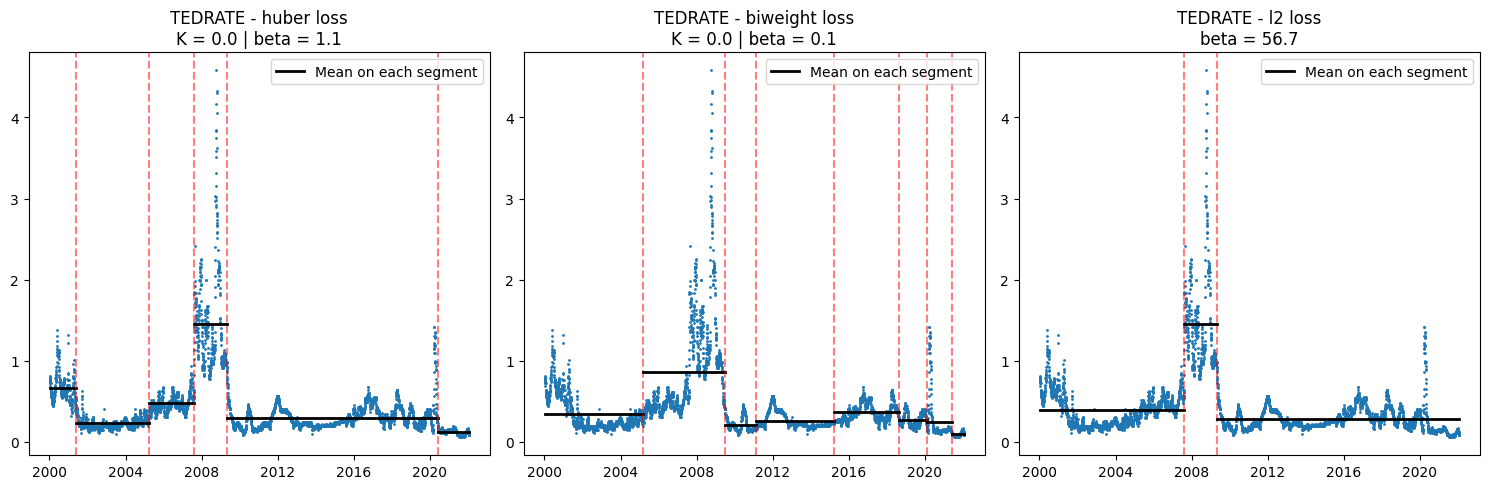

In [ ]:
plot_segments(df,'TEDRATE',scaling_huber=200,scaling_biweight=9.2,scaling_l2=30000)

The TED Spread (difference between 3-Month LIBOR and 3-Month Treasury Bill) is a gauge of perceived credit risk in the general economy and the health of the banking system. A rising spread indicates that banks believe the risk of other banks default risk is increasing.

### **Historical Interpretation of Regimes**

* **2000 – 2003: Dotcom bubble**, characterized by moderately elevated spreads. The recession following the burst of the tech bubble kept banking stress higher than average.
* **2004 – 2007: Liquidity Bubble**, characterized by very low spreads. Money was abundant in this period and banks trusted each other completely, underestimating systemic risk.
* **2008 – 2009: Global Financial Crisis (GFC)**, characterized a credit freeze. During thid period, banks stopped lending to each other, causing the spread to skyrocket to its all time high.
* **2010 – 2019: Post-Crisis Healing**, characterized by a normalization. Spreads fell back but remained structurally more volatile than before because of lack of confidence in the interbank market (Eurozone crisis created variations).
* **2020: Covid Liquidity Crunch**, characterized by a sharp spike because investors panicked and wanted to get their cash at the beginning of covid. 

### **Comparison of Algorithms**

* Huber loss algorithm effectively captures most of the periods mentioned above. L2 loss algorithm also yields decent results although the breakdown of periods could be more detailed. 
* Biweight loss algorithm yields poor results and does not properly identify breakpoints representing the 2008-2009 crisis (identifies 2005-2009 as a period instead). Because of boundedness of this loss, the extreme values in the 2008-2009 period are considered as outliers and not as characteristic values of a specific period.

### Recap of these experiments: 
- all algorithms identify relevant changepoints that make sense from an economic history perspective. We clearly identify different regimes with dates aligned with true events.
- the biweight loss algorithm is more sensitive to the value of beta: a higher beta leading to fewer changepoints, this algorithm could be more useful to ignore short term volatility (considered as outliers) and identify long term economic cycles and periods. Conversely, Huber and L2 loss algorithms are less sensitive so these algorithms can identify crashes and crisis as separate regimes.  
- however, the three algorithms can yield very similar results when picking the appropriate $\beta$ for each model. So maybe it is more relevant to stick with the L2 loss model as it is simpler and easier to use than the biweight and huber model.
- Bounded loss functions like the biweight can be ill-suited for series where extreme values represent the primary regime of interest (see VIXCLS and TEDRATE indexes).

### C)1) Experiments with raw time series

Here we work on DFF (fed fund rates, very dependent on macroeconomic conditions so many different regimes thorough history for this indicator), VIXCLS (VIX index, it is a "fear" index representing the confidence of investors) and TEDRATE (a spread indicator of financial crisis).

0
1
2


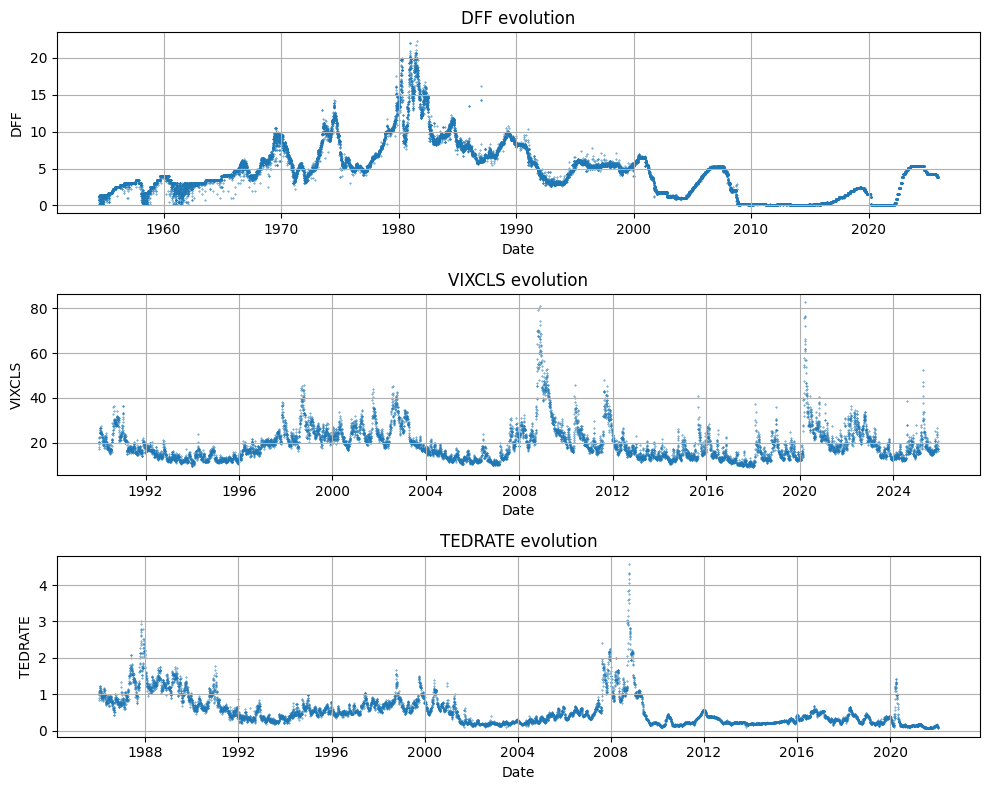

In [ ]:
fig, ax = plt.subplots(3,figsize=(10,8))
for i,column in enumerate(["DFF","VIXCLS","TEDRATE"]):
    print(i)
    df_filtered = dus[column].dropna()
    ax[i].scatter(df_filtered.index,df_filtered,0.5,marker = '.')
    ax[i].set_title(column)
    ax[i].set_xlabel("Date")    
    ax[i].set_ylabel(f"{column}")
    ax[i].grid()
    ax[i].set_title(f"{column} evolution")

plt.tight_layout()
plt.show()

C:\Users\jean-\AppData\Local\Temp\ipykernel_16120\1107198153.py:56: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\jean-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


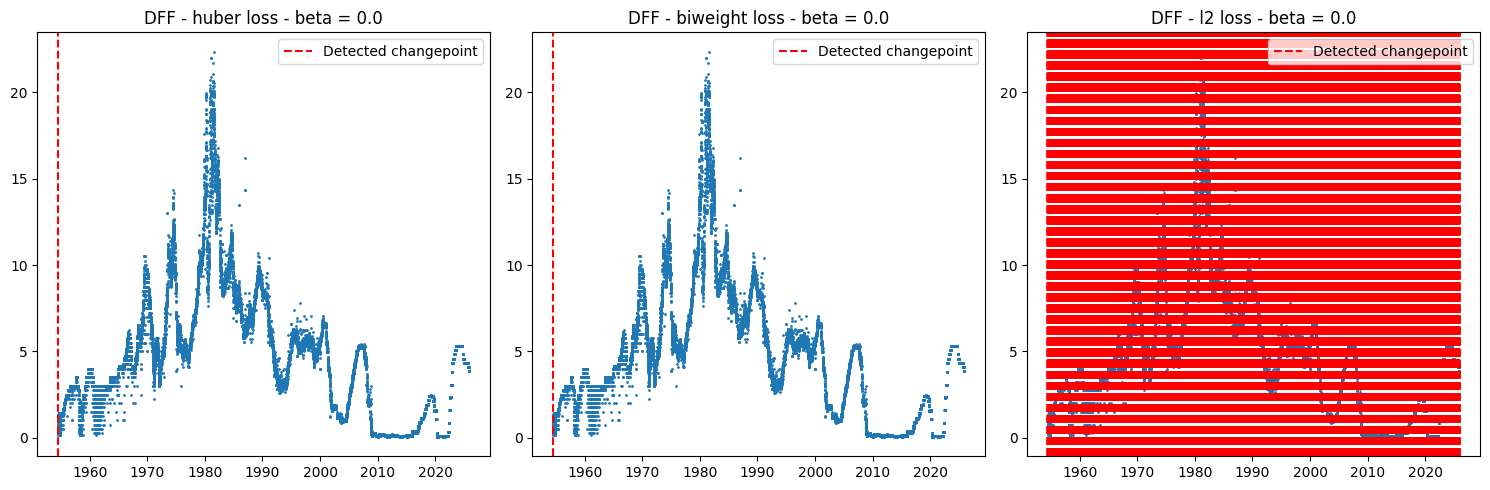

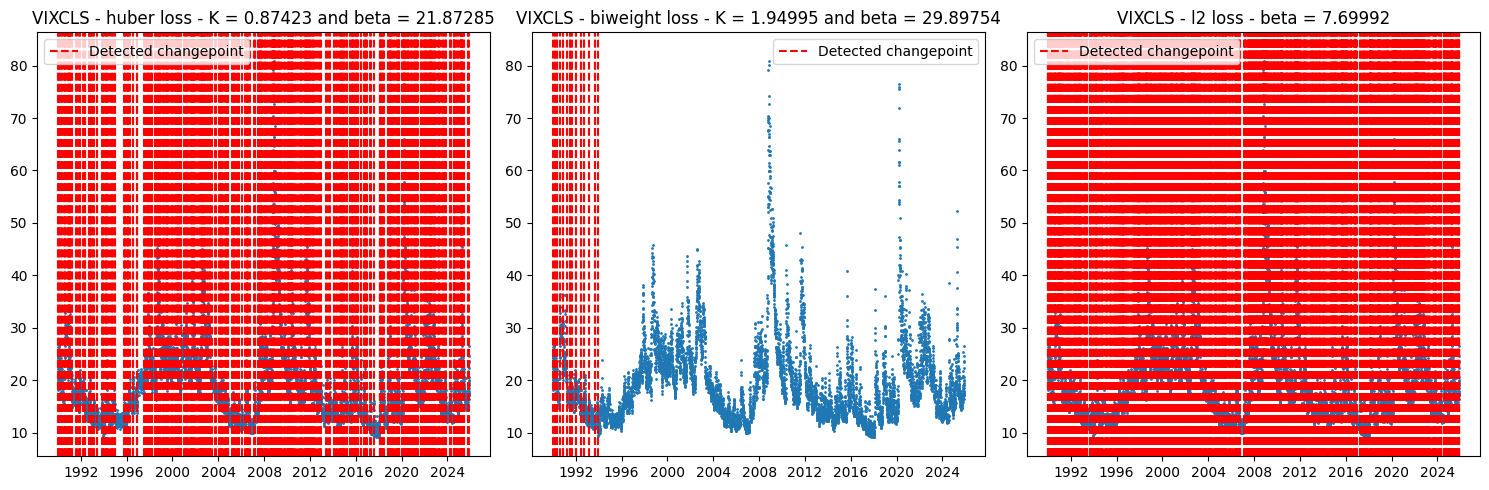

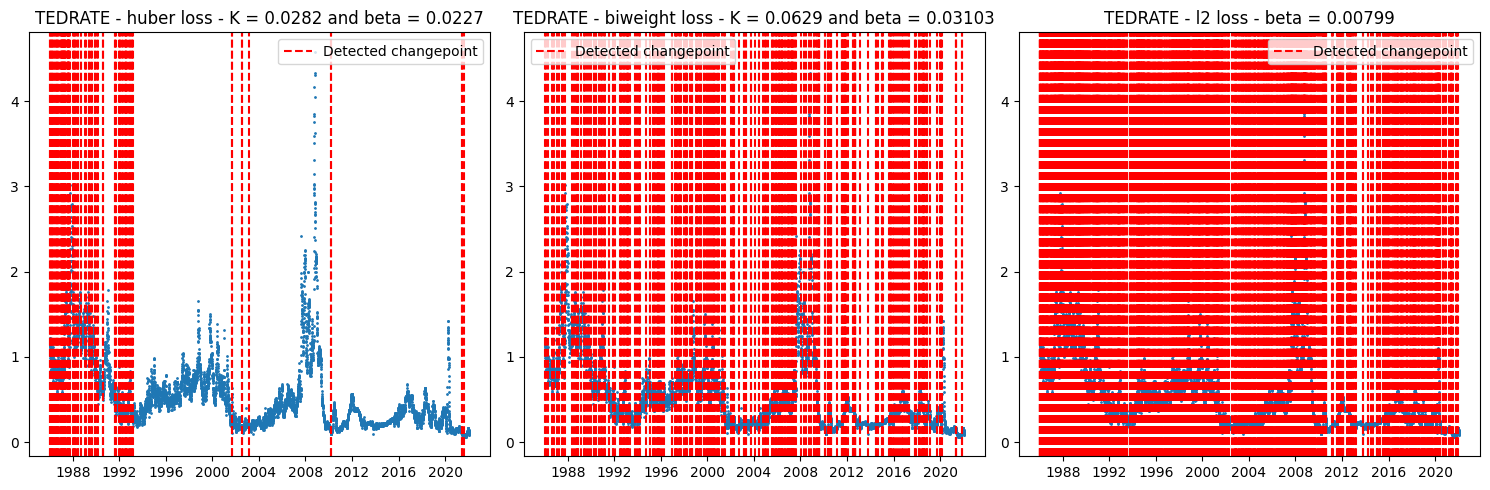

In [ ]:
col = ["DFF","VIXCLS","TEDRATE"]

for name in col:

    y = dus[name].dropna()
    # y = y[y.index>'2000']

    fig, axes = plt.subplots(1,3,figsize=(15,5))
    axes = axes.flatten()

    for i,loss in enumerate(['huber','biweight','l2']):
        
        beta = compute_penalty_beta(y,loss)
        K=compute_loss_bound_K(y,loss)
        
        if loss == 'huber':
            # if beta/K < len(y)/100:
            #     beta = K*len(y)/100
            # beta = beta*150
            cp_tau, Qt_vals, Qstar_final = rfpop_algorithm1_main(y, lambda y_t, t: gamma_builder_huber(y_t, K, t), beta)
        elif loss == 'biweight':
            # beta = beta*10
            cp_tau, Qt_vals, Qstar_final = rfpop_algorithm1_main(y, lambda y_t, t: gamma_builder_biweight(y_t, K, t), beta) 
        elif loss == 'l2':
            # beta = beta*1500
            cp_tau, Qt_vals, Qstar_final = rfpop_algorithm1_main(y, lambda y_t, t: gamma_builder_L2(y_t, t), beta)

        ax = axes[i]
        ax.plot(y, '.', markersize=2)
        changepoints = np.unique(cp_tau)

       
        cp_dates = []
        for i, date in enumerate(y.index):
            if i in changepoints:
                cp_dates.append(1)
            else:
                cp_dates.append(0)

        cp_dates = pd.Series(cp_dates)
        cp_dates.index = y.index 
    
        for date in cp_dates.index:
                if cp_dates.loc[date] ==1:
            
                    # On trace une ligne rouge pointillée à chaque changepoint
                    ax.axvline(x=date, color='r', linestyle='--', label='Detected changepoint' if date == cp_dates.index[0] else "")
        if not K:
            ax.set_title(f'{name} - {loss} loss - beta = {round(beta,5)}')
        else:
            ax.set_title(f'{name} - {loss} loss - K = {round(K,5)} and beta = {round(beta,5)}')
        # ax.set_xlim(0, len(y))
        ax.legend()
        

    plt.tight_layout()
    plt.show()

Once again, using the values of $\beta$ and $K$ recommended by the paper yield poor results and results in oversegmentation, so we need to manually and incrementally choose the value of these parameters to get satisfying results.

KeyboardInterrupt: 

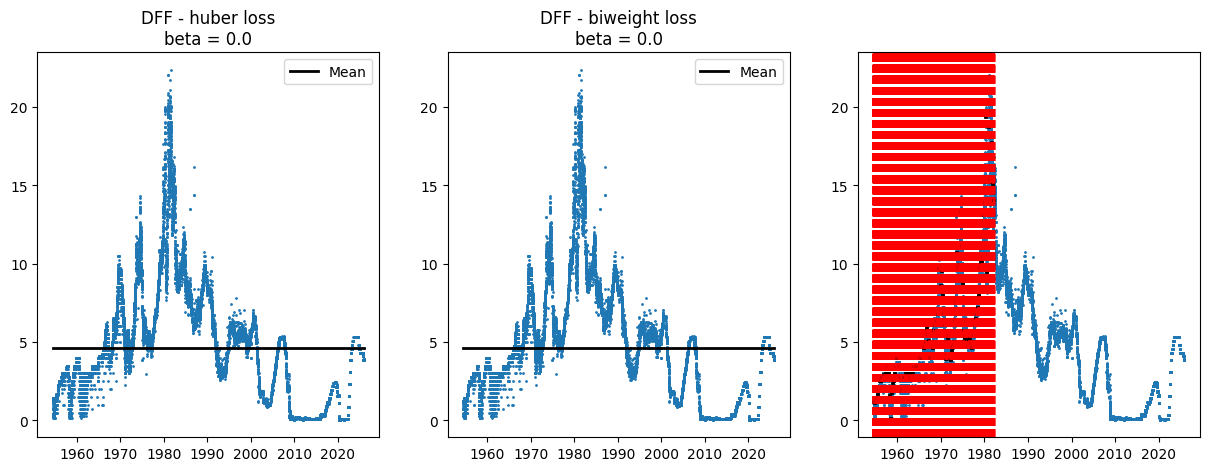

In [ ]:
col = ["VIXCLS","TEDRATE"]

for name in col:

    y = dus[name].dropna()
    # y = y[y.index>'2000']

    fig, axes = plt.subplots(1,3,figsize=(15,5))
    axes = axes.flatten()

    for i,loss in enumerate(['huber','biweight','l2']):
        
        beta = compute_penalty_beta(y,loss)
        K=compute_loss_bound_K(y,loss)
        
        


        if loss == 'huber':
            # if beta/K < len(y)/100:
            #     beta = K*len(y)/100
            beta = beta*150
            cp_tau, Qt_vals, Qstar_final = rfpop_algorithm1_main(y, lambda y_t, t: gamma_builder_huber(y_t, K, t), beta)
        elif loss == 'biweight':
            beta = beta*10
            cp_tau, Qt_vals, Qstar_final = rfpop_algorithm1_main(y, lambda y_t, t: gamma_builder_biweight(y_t, K, t), beta) 
        elif loss == 'l2':
            beta = beta*1500
            cp_tau, Qt_vals, Qstar_final = rfpop_algorithm1_main(y, lambda y_t, t: gamma_builder_L2(y_t, t), beta)


        ax = axes[i]

        ax.plot(y, '.', markersize=2)

        changepoints = np.unique(cp_tau)

        t = len(y) - 1
        segments = []
        
        while t > 0:
            # Le début du segment actuel est indiqué par cp_tau[t]
            t_prev = int(cp_tau[t])
            # On enregistre le segment (start_index, end_index)
            segments.append((t_prev, t))
            # On recule
            t = t_prev
            
        segments.reverse() # On remet dans l'ordre chronologique

        # 3. Calcul de la moyenne de chaque segment
        for start_idx, end_idx in segments:
     
            segment_data = y.iloc[start_idx : end_idx + 1]
            seg_mean = segment_data.mean()
            
            # Récupération des dates pour l'axe X
            date_start = y.index[start_idx]
            date_end = y.index[end_idx] # La date du dernier point du segment

       
            ax.plot([date_start, date_end], [seg_mean, seg_mean], 
                    color='black', linewidth=2, label='Mean' if start_idx == 0 else "")
            
     
            if end_idx < len(y) - 1:
                ax.axvline(x=date_end, color='r', linestyle='--', alpha=0.5)

        if not K:
            ax.set_title(f'{name} - {loss} loss\nbeta = {round(beta, 1)}')
        else:
            ax.set_title(f'{name} - {loss} loss\nK = {round(K, 1)} | beta = {round(beta, 1)}')
        
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys())

        # cp_dates = []
        # for i, date in enumerate(y.index):
        #     if i in changepoints:
        #         cp_dates.append(1)
        #     else:
        #         cp_dates.append(0)

        # cp_dates = pd.Series(cp_dates)
        # cp_dates.index = y.index 
    
        # for date in cp_dates.index:
        #         if cp_dates.loc[date] ==1:
            
        #             # On trace une ligne rouge pointillée à chaque changepoint
        #             ax.axvline(x=date, color='r', linestyle='--', label='Detected changepoint' if date == cp_dates.index[0] else "")
        # if not K:
        #     ax.set_title(f'{name} - {loss} loss - beta = {round(beta,5)}')
        # else:
        #     ax.set_title(f'{name} - {loss} loss - K = {round(K,5)} and beta = {round(beta,5)}')
        # # ax.set_xlim(0, len(y))
        # ax.legend()
        

    plt.tight_layout()
    plt.show()

## C)2) Experiences with differentiated time series.

Here we work on GDP of various contries (US, Europe, Japan, Germany, UK). For such indicators, what matters is the variation of the time series and not the raw time series itself. 

0
1
2
3
4


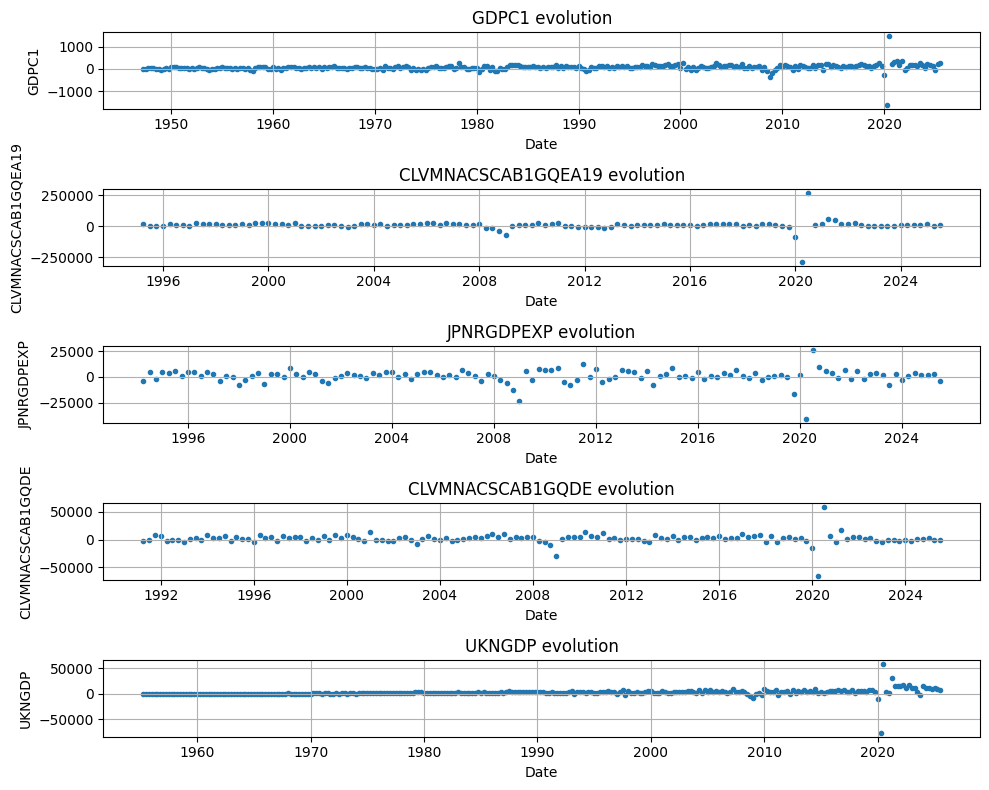

In [ ]:
fig, ax = plt.subplots(5,figsize=(10,8))
for i,column in enumerate(["GDPC1","CLVMNACSCAB1GQEA19","JPNRGDPEXP","CLVMNACSCAB1GQDE","UKNGDP"]):
    print(i)
    df_filtered = dus[column].dropna()
    ax[i].scatter(df_filtered.index,df_filtered.diff(),marker = '.')
    ax[i].set_title(column)
    ax[i].set_xlabel("Date")    
    ax[i].set_ylabel(f"{column}")
    ax[i].grid()
    ax[i].set_title(f"{column} evolution")

plt.tight_layout()
plt.show()

In [ ]:
y

Series([], Name: CLVMNACSCAB1GQEA19, dtype: float64)

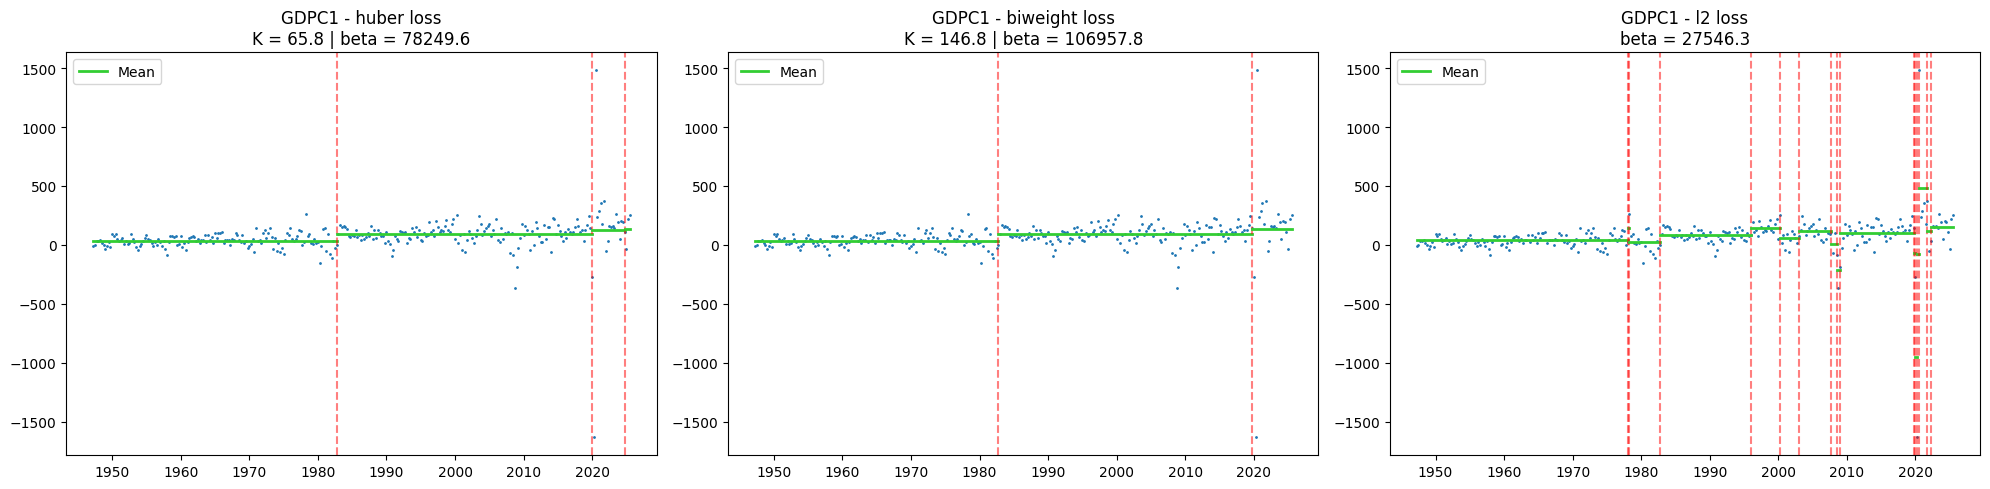

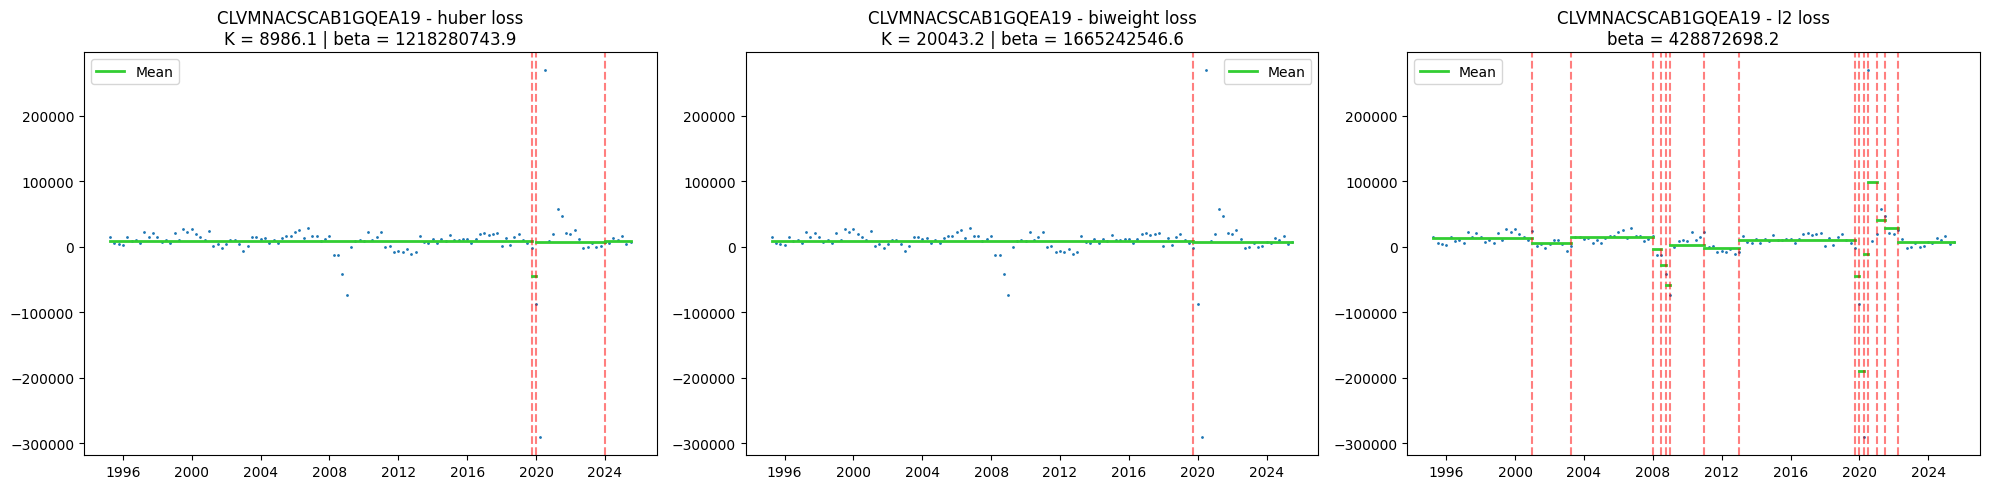

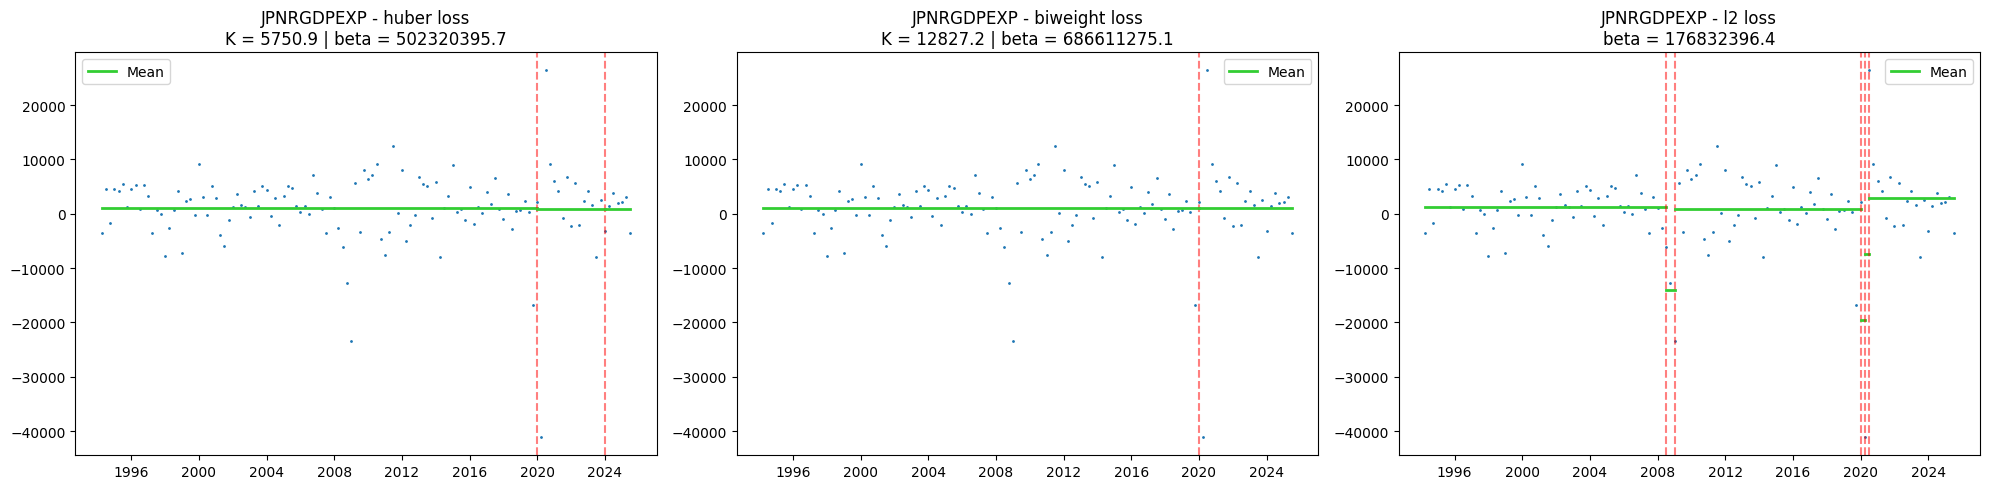

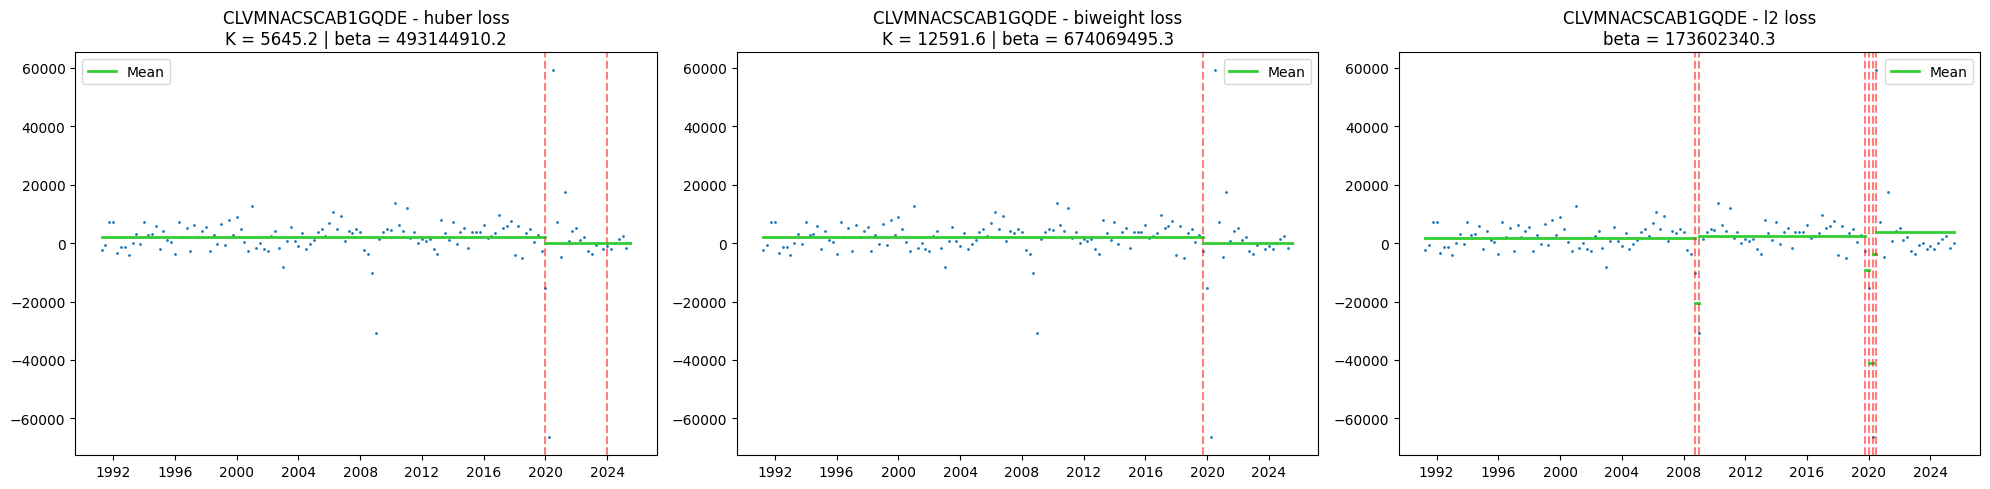

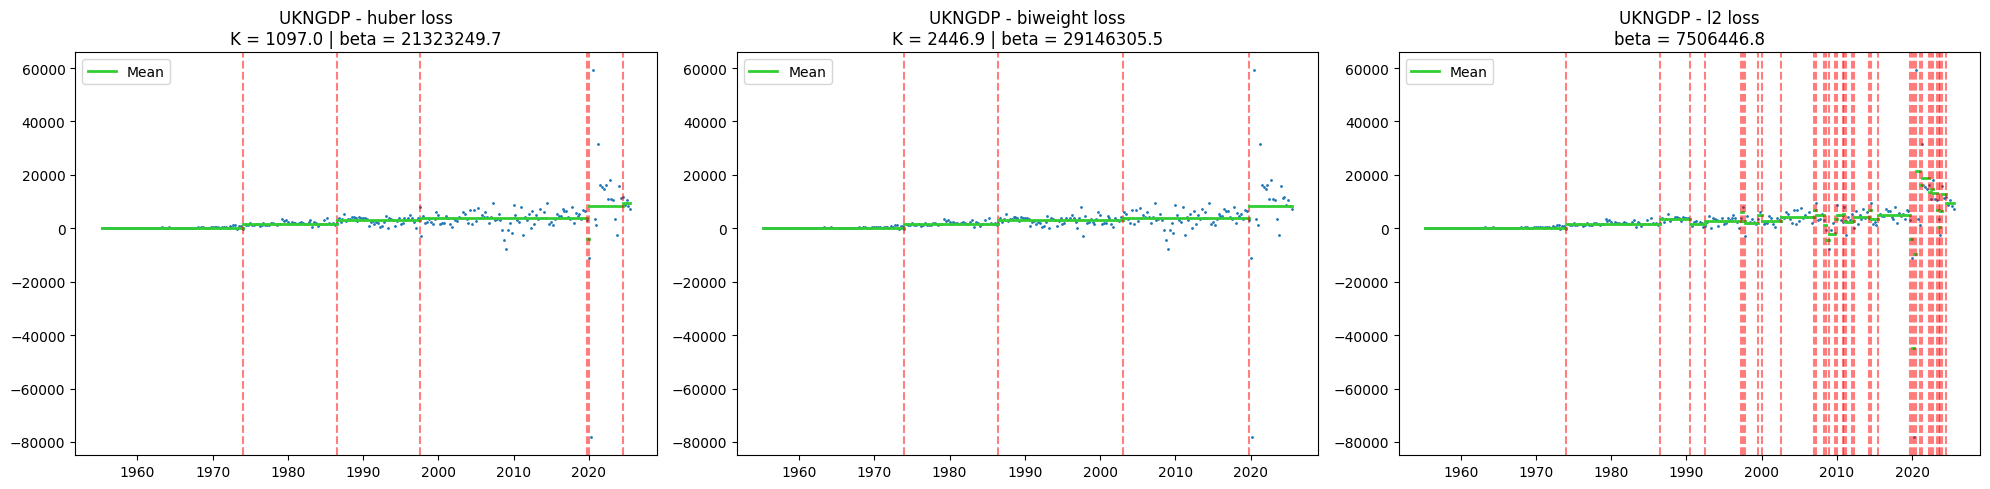

In [ ]:
col = ["GDPC1","CLVMNACSCAB1GQEA19","JPNRGDPEXP","CLVMNACSCAB1GQDE","UKNGDP"]

for name in col:

    y = dus[name].dropna()
    y = y.diff().dropna()
    # y = y[y.index>'2000']

    fig, axes = plt.subplots(1,3,figsize=(20,5))
    axes = axes.flatten()

    for i,loss in enumerate(['huber','biweight','l2']):
        
        beta = compute_penalty_beta(y,loss)
        K=compute_loss_bound_K(y,loss)
        
        


        if loss == 'huber':
            # if beta/K < len(y)/100:
            #     beta = K*len(y)/100
            # beta = beta*150
            cp_tau, Qt_vals, Qstar_final = rfpop_algorithm1_main(y, lambda y_t, t: gamma_builder_huber(y_t, K, t), beta)
        elif loss == 'biweight':
            # beta = beta*10
            cp_tau, Qt_vals, Qstar_final = rfpop_algorithm1_main(y, lambda y_t, t: gamma_builder_biweight(y_t, K, t), beta) 
        elif loss == 'l2':
            # beta = beta*1500
            cp_tau, Qt_vals, Qstar_final = rfpop_algorithm1_main(y, lambda y_t, t: gamma_builder_L2(y_t, t), beta)


        ax = axes[i]

        ax.plot(y, '.', markersize=2)

        changepoints = np.unique(cp_tau)

        # cp_dates = []
        # for i, date in enumerate(y.index):
        #     if i in changepoints:
        #         cp_dates.append(1)
        #     else:
        #         cp_dates.append(0)

        # cp_dates = pd.Series(cp_dates)
        # cp_dates.index = y.index 

        t = len(y) - 1
        segments = []
        
        while t > 0:
            # Le début du segment actuel est indiqué par cp_tau[t]
            t_prev = int(cp_tau[t])
            # On enregistre le segment (start_index, end_index)
            segments.append((t_prev, t))
            # On recule
            t = t_prev
            
        segments.reverse() # On remet dans l'ordre chronologique



        # 3. Calcul de la moyenne de chaque segment
        for start_idx, end_idx in segments:
     
            segment_data = y.iloc[start_idx : end_idx + 1]
            seg_mean = segment_data.mean()
            
            # Récupération des dates pour l'axe X
            date_start = y.index[start_idx]
            date_end = y.index[end_idx] # La date du dernier point du segment

       
            ax.plot([date_start, date_end], [seg_mean, seg_mean], 
                    color='limegreen', linewidth=2, label='Mean' if start_idx == 0 else "")
            
     
            if end_idx < len(y) - 1:
                ax.axvline(x=date_end, color='r', linestyle='--', alpha=0.5)

        if not K:
            ax.set_title(f'{name} - {loss} loss\nbeta = {round(beta, 1)}')
        else:
            ax.set_title(f'{name} - {loss} loss\nK = {round(K, 1)} | beta = {round(beta, 1)}')
            
   
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys())



    plt.tight_layout()
    plt.show()

# IV - Online Analysis (as in the paper)

The RFPOP algorithm is inherently **online**: it processes data sequentially and can detect changepoints in real-time as new observations arrive. This section demonstrates this capability on Federal Reserve interest rate data, which is relevant for detecting monetary policy regime changes.

Key monetary policy regime changes we might expect to detect:
- **2001**: Dot-com bubble burst, aggressive rate cuts
- **2007-2008**: Financial crisis, rates cut to near zero
- **2015-2018**: Rate normalization period
- **2020**: COVID-19 crisis, emergency rate cuts
- **2022-2023**: Aggressive rate hikes to combat inflation

In [ ]:
def rfpop_online_analysis(
    y: np.ndarray,
    loss: Literal['huber', 'biweight', 'l2'] = 'biweight',
    beta: Optional[float] = None,
    K: Optional[float] = None,
    checkpoints: Optional[List[int]] = None
) -> dict:
    """
    Analyse online avec RFPOP - montre l'évolution des changepoints détectés
    au fur et à mesure que les données arrivent.
    
    Parameters:
    -----------
    y : np.ndarray
        Série temporelle complète
    loss : str
        Type de loss function
    beta : float, optional
        Pénalité (calculée automatiquement si None)
    K : float, optional
        Seuil de la loss (calculé automatiquement si None)
    checkpoints : list, optional
        Points où enregistrer l'état (défaut: tous les 10%)
        
    Returns:
    --------
    dict : Historique de l'analyse online
    """
    n = len(y)
    y_list = list(y)
    
    # Paramètres par défaut
    if beta is None:
        beta = compute_penalty_beta(y, loss)
    if K is None and loss in ['huber', 'biweight']:
        K = compute_loss_bound_K(y, loss)
    
    # Points de contrôle par défaut (10%, 20%, ..., 100%)
    if checkpoints is None:
        checkpoints = [int(n * p) for p in np.arange(0.1, 1.01, 0.1)]
        checkpoints = [c for c in checkpoints if c > 10]  # Au moins 10 points
    
    # Créer le gamma_builder
    if loss == 'huber':
        gamma_builder = lambda y_t, t, K=K: gamma_builder_huber(y_t, K, t)
    elif loss == 'biweight':
        gamma_builder = lambda y_t, t, K=K: gamma_builder_biweight(y_t, K, t)
    else:
        gamma_builder = lambda y_t, t: gamma_builder_L2(y_t, t)
    
    # Historique
    history = {
        'checkpoints': [],
        'n_changepoints': [],
        'changepoint_positions': [],
        'costs': []
    }
    
    # Analyse online: on simule l'arrivée progressive des données
    for checkpoint in checkpoints:
        y_partial = y_list[:checkpoint]
        
        cp_tau, Qt_vals, _ = rfpop_algorithm1_main(y_partial, gamma_builder, beta)
        changepoints = extract_changepoints_backtrack(cp_tau)
        
        history['checkpoints'].append(checkpoint)
        history['n_changepoints'].append(len(changepoints))
        history['changepoint_positions'].append(changepoints.copy())
        history['costs'].append(Qt_vals[-1])
    
    return {
        'history': history,
        'final_cp_tau': cp_tau,
        'final_changepoints': changepoints,
        'params': {'beta': beta, 'K': K, 'loss': loss}
    }


def plot_online_analysis(y, online_result, title="Online Changepoint Detection", dates=None):
    """
    Visualise l'analyse online: montre comment les changepoints évoluent
    au fur et à mesure que les données arrivent.
    """
    history = online_result['history']
    checkpoints = history['checkpoints']
    n = len(y)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # 1. Données complètes avec changepoints finaux
    ax1 = axes[0, 0]
    if dates is not None:
        ax1.plot(dates, y, '.', markersize=1, alpha=0.5, label='Data')
        for cp in online_result['final_changepoints']:
            if cp < len(dates):
                ax1.axvline(x=dates[cp], color='red', linestyle='--', alpha=0.7)
    else:
        ax1.plot(y, '.', markersize=1, alpha=0.5, label='Data')
        for cp in online_result['final_changepoints']:
            ax1.axvline(x=cp, color='red', linestyle='--', alpha=0.7)
    ax1.set_title(f'{title}\nFinal changepoints: {len(online_result["final_changepoints"])}')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Value')
    ax1.legend()
    
    # 2. Évolution du nombre de changepoints
    ax2 = axes[0, 1]
    ax2.plot(checkpoints, history['n_changepoints'], 'o-', linewidth=2, markersize=8)
    ax2.set_xlabel('Number of observations')
    ax2.set_ylabel('Number of changepoints detected')
    ax2.set_title('Evolution of detected changepoints (online)')
    ax2.grid(True, alpha=0.3)
    
    # 3. Heatmap des positions de changepoints au fil du temps
    ax3 = axes[1, 0]
    max_cp = max(history['n_changepoints']) if history['n_changepoints'] else 1
    heatmap_data = np.zeros((len(checkpoints), n))
    
    for i, (checkpoint, cps) in enumerate(zip(checkpoints, history['changepoint_positions'])):
        for cp in cps:
            if cp < n:
                heatmap_data[i, cp] = 1
    
    ax3.imshow(heatmap_data, aspect='auto', cmap='Reds', interpolation='nearest')
    ax3.set_xlabel('Position in time series')
    ax3.set_ylabel('Checkpoint (data seen)')
    ax3.set_yticks(range(len(checkpoints)))
    ax3.set_yticklabels([f'{c}' for c in checkpoints])
    ax3.set_title('Changepoint positions over time\n(red = changepoint detected)')
    
    # 4. Coût au fil du temps
    ax4 = axes[1, 1]
    ax4.plot(checkpoints, history['costs'], 'o-', linewidth=2, markersize=8, color='green')
    ax4.set_xlabel('Number of observations')
    ax4.set_ylabel('Total cost')
    ax4.set_title('Evolution of total cost')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig

## Online Analysis on Federal Funds Rate (DFF)

The Federal Funds Rate is the key interest rate set by the Federal Reserve. Changes in this rate reflect major shifts in monetary policy. Let's apply online changepoint detection to identify these regime changes.

Federal Funds Rate (DFF) data:
  Period: 1990-01-01 to 2025-12-01
  Number of observations: 13119
  Range: 0.04% to 10.39%


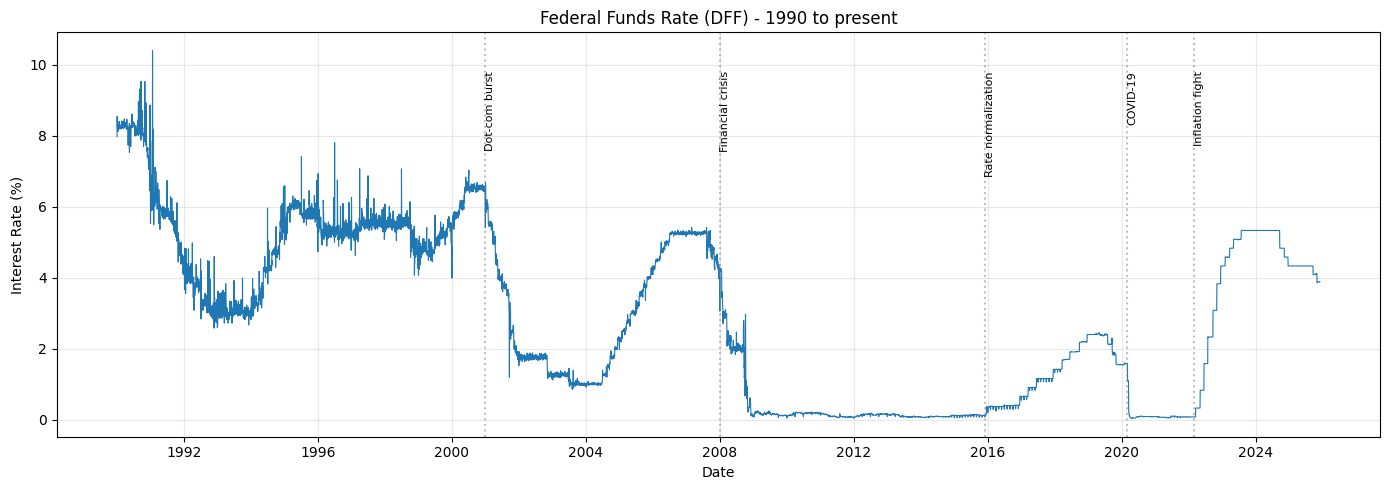

In [ ]:
# Load and prepare Federal Funds Rate data
dff = df['DFF'].dropna()
dff = dff[dff.index >= '1990']  # Focus on modern era

print(f"Federal Funds Rate (DFF) data:")
print(f"  Period: {dff.index[0].strftime('%Y-%m-%d')} to {dff.index[-1].strftime('%Y-%m-%d')}")
print(f"  Number of observations: {len(dff)}")
print(f"  Range: {dff.min():.2f}% to {dff.max():.2f}%")

# Visualize the raw data
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(dff.index, dff.values, linewidth=0.8)
ax.set_title('Federal Funds Rate (DFF) - 1990 to present')
ax.set_xlabel('Date')
ax.set_ylabel('Interest Rate (%)')
ax.grid(True, alpha=0.3)

# Add annotations for key events
events = {
    '2001-01-01': 'Dot-com burst',
    '2008-01-01': 'Financial crisis',
    '2015-12-01': 'Rate normalization',
    '2020-03-01': 'COVID-19',
    '2022-03-01': 'Inflation fight'
}
for date_str, label in events.items():
    date = pd.to_datetime(date_str)
    if date >= dff.index[0] and date <= dff.index[-1]:
        ax.axvline(x=date, color='gray', linestyle=':', alpha=0.5)
        ax.text(date, ax.get_ylim()[1]*0.9, label, rotation=90, fontsize=8, va='top')

plt.tight_layout()
plt.show()

Parameters for biweight loss:
  K = 0.0000
  beta = 0.0000
  beta/K ratio = nan

Scaled beta = 0.0000
Scaled beta/K ratio = nan


/var/folders/1x/xtzy6z6d7539r5dzrvb9g6x80000gn/T/ipykernel_15101/2197383903.py:12: RuntimeWarning: invalid value encountered in scalar divide
  print(f"  beta/K ratio = {beta_biweight/K_biweight:.2f}")
/var/folders/1x/xtzy6z6d7539r5dzrvb9g6x80000gn/T/ipykernel_15101/2197383903.py:19: RuntimeWarning: invalid value encountered in scalar divide
  print(f"Scaled beta/K ratio = {beta_scaled/K_biweight:.2f}")



Final number of changepoints: 0


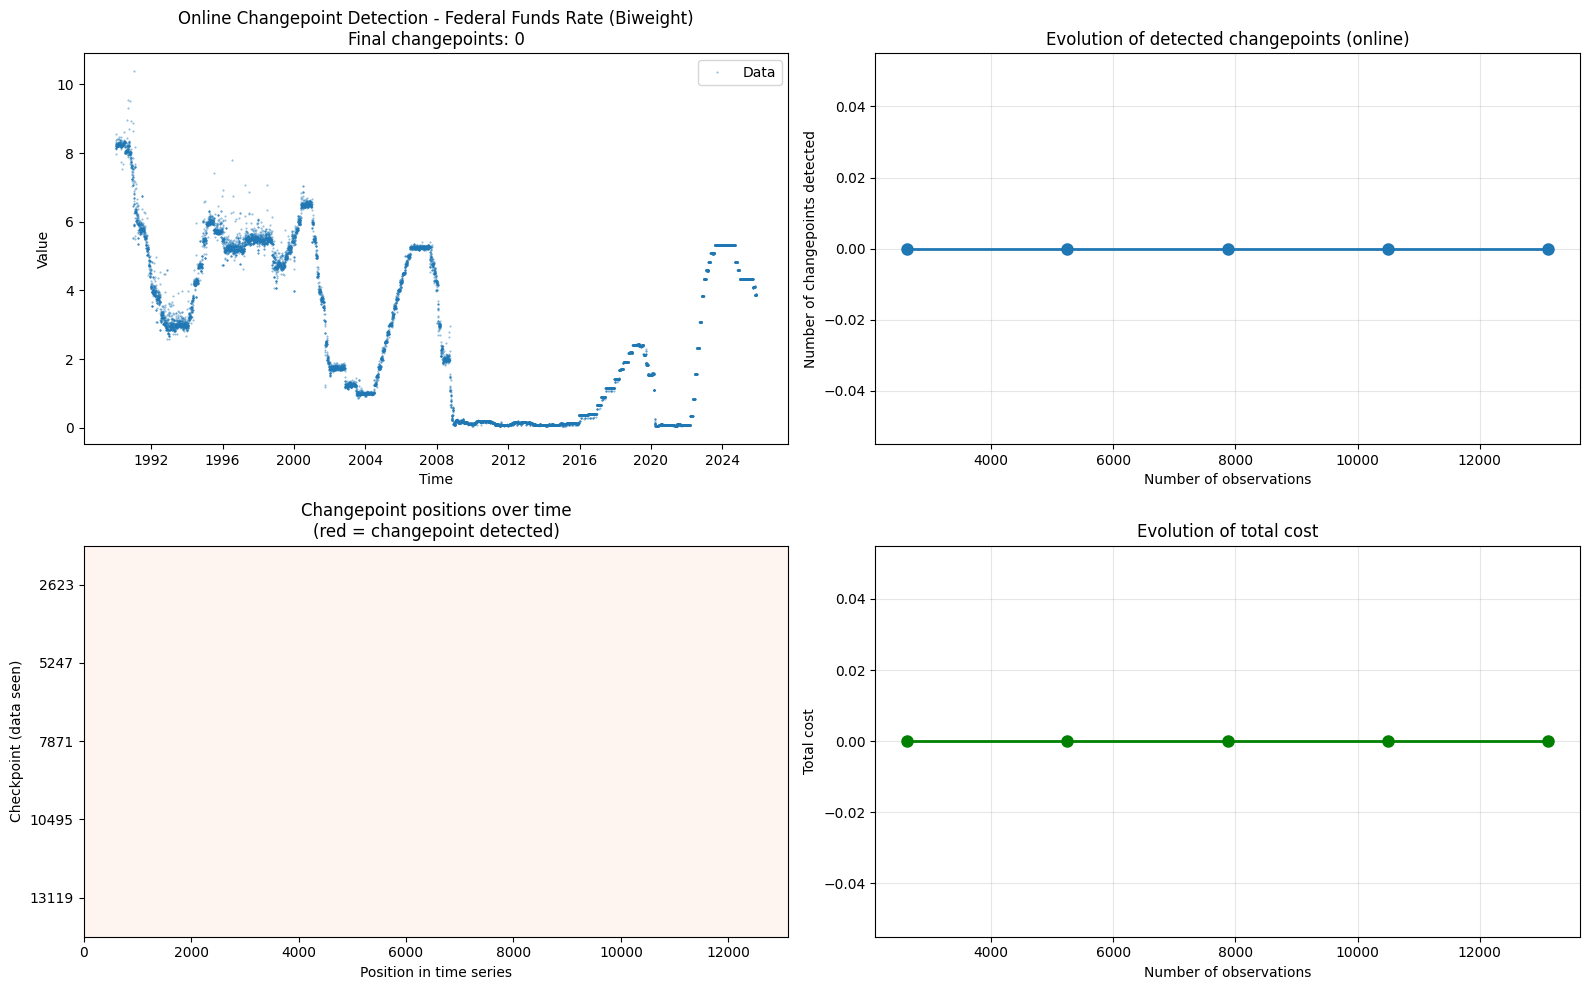

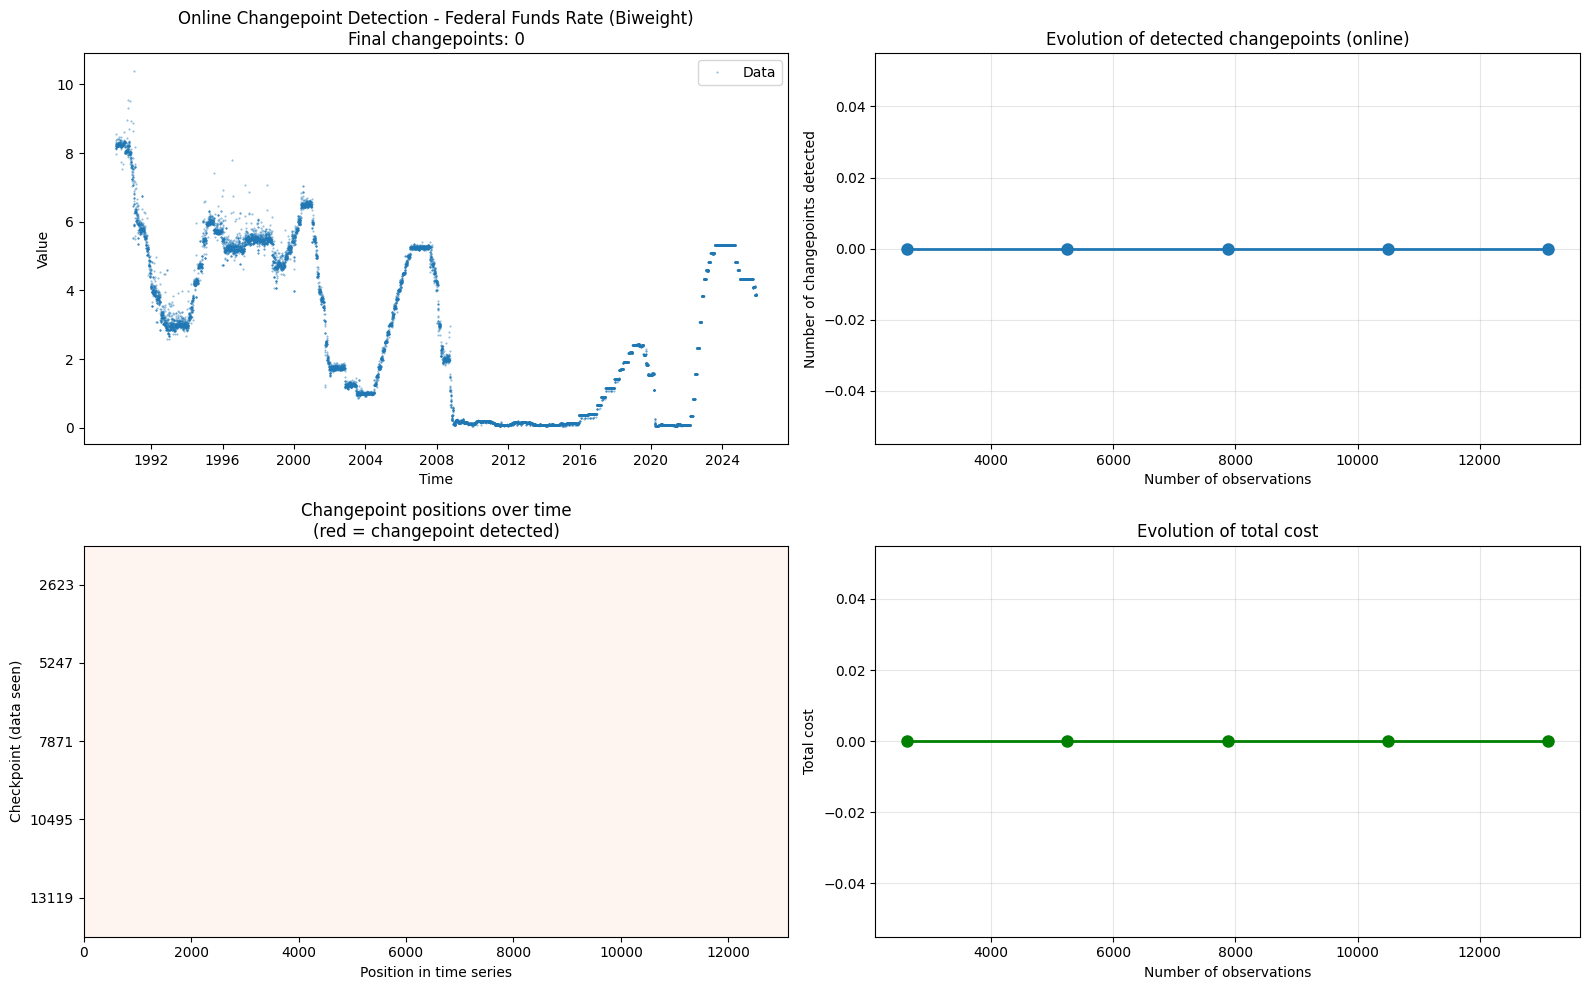

In [ ]:
# Online analysis with biweight loss (robust to outliers)
y_dff = dff.values
dates_dff = dff.index

# Calculate parameters
beta_biweight = compute_penalty_beta(y_dff, 'biweight')
K_biweight = compute_loss_bound_K(y_dff, 'biweight')

print(f"Parameters for biweight loss:")
print(f"  K = {K_biweight:.4f}")
print(f"  beta = {beta_biweight:.4f}")
print(f"  beta/K ratio = {beta_biweight/K_biweight:.2f}")

# Scale beta to get reasonable number of changepoints (based on domain knowledge)
# Federal funds rate typically has 10-20 major regime changes since 1990
beta_scaled = beta_biweight * 50  # Increase penalty to avoid over-segmentation

print(f"\nScaled beta = {beta_scaled:.4f}")
print(f"Scaled beta/K ratio = {beta_scaled/K_biweight:.2f}")

# Run online analysis
online_result = rfpop_online_analysis(
    y_dff, 
    loss='biweight',
    beta=beta_scaled,
    K=K_biweight,
    checkpoints=[int(len(y_dff) * p) for p in [0.2, 0.4, 0.6, 0.8, 1.0]]
)

print(f"\nFinal number of changepoints: {len(online_result['final_changepoints'])}")

# Plot online analysis
plot_online_analysis(y_dff, online_result, 
                     title="Online Changepoint Detection - Federal Funds Rate (Biweight)",
                     dates=dates_dff)

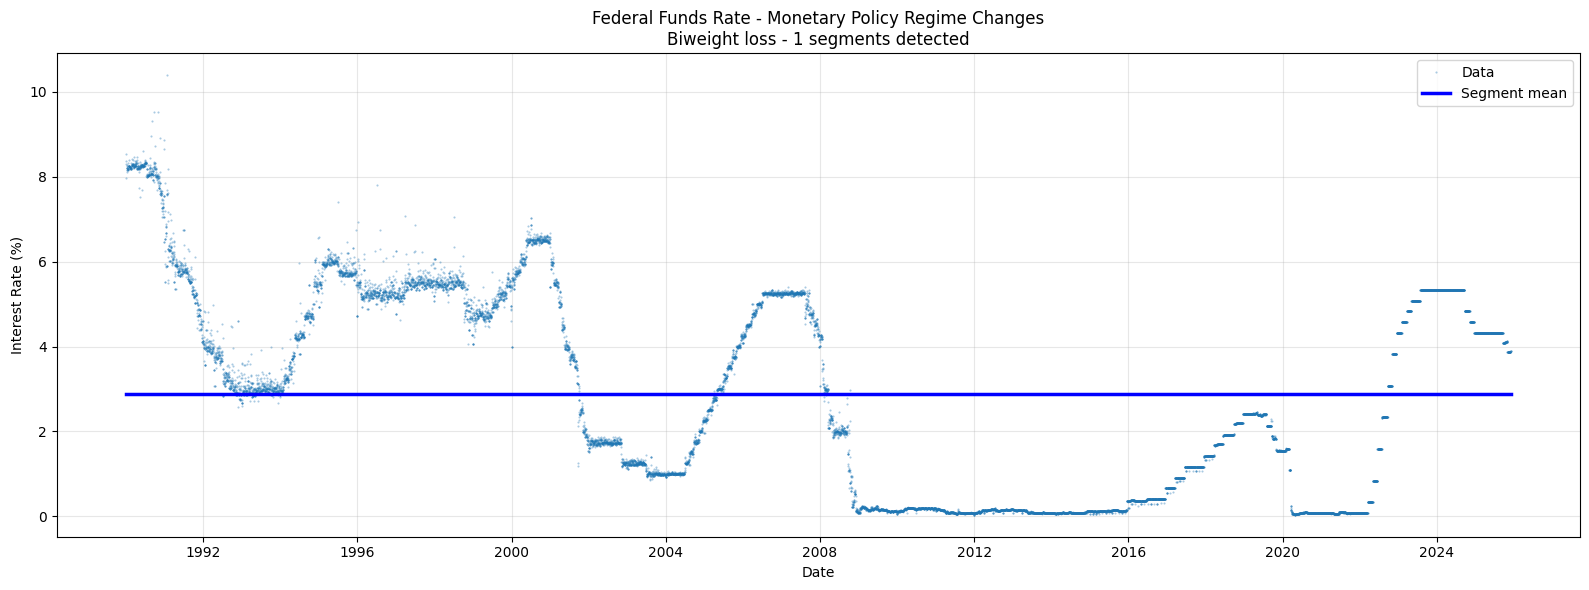


Detected changepoints (0 total):
--------------------------------------------------


In [ ]:
# Detailed visualization with segment means and changepoint dates
def plot_segments_with_dates(y, cp_tau, dates, title, loss_name):
    """
    Plot the time series with detected segments and their means.
    Show changepoint dates for interpretation.
    """
    segments = get_segments_from_cp_tau(cp_tau, y)
    
    fig, ax = plt.subplots(figsize=(16, 6))
    
    # Plot raw data
    ax.plot(dates, y, '.', markersize=1, alpha=0.4, label='Data')
    
    # Plot segment means
    for start_idx, end_idx, seg_mean in segments:
        date_start = dates[start_idx]
        date_end = dates[end_idx]
        ax.plot([date_start, date_end], [seg_mean, seg_mean], 
                color='blue', linewidth=2.5, label='Segment mean' if start_idx == 0 else "")
        
        # Vertical line at changepoint
        if end_idx < len(y) - 1:
            ax.axvline(x=date_end, color='red', linestyle='--', alpha=0.6)
    
    ax.set_title(f'{title}\n{loss_name} loss - {len(segments)} segments detected')
    ax.set_xlabel('Date')
    ax.set_ylabel('Interest Rate (%)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print changepoint dates
    print(f"\nDetected changepoints ({len(segments)-1} total):")
    print("-" * 50)
    for i, (start_idx, end_idx, seg_mean) in enumerate(segments[:-1]):
        cp_date = dates[end_idx]
        next_mean = segments[i+1][2]
        change = next_mean - seg_mean
        print(f"  {cp_date.strftime('%Y-%m-%d')}: {seg_mean:.2f}% → {next_mean:.2f}% (Δ = {change:+.2f}%)")
    
    return segments

# Run full analysis with biweight
cp_tau_full, Qt_vals_full, _ = rfpop_algorithm1_main(
    list(y_dff), 
    lambda y_t, t, K=K_biweight: gamma_builder_biweight(y_t, K, t), 
    beta_scaled
)

segments = plot_segments_with_dates(
    y_dff, cp_tau_full, dates_dff,
    "Federal Funds Rate - Monetary Policy Regime Changes",
    "Biweight"
)

## Comparison of Loss Functions on Fed Funds Rate

Let's compare how the three loss functions (Huber, Biweight, L2) perform on the same data. The robust losses (Huber and Biweight) should be less sensitive to daily volatility spikes.

KeyboardInterrupt: 

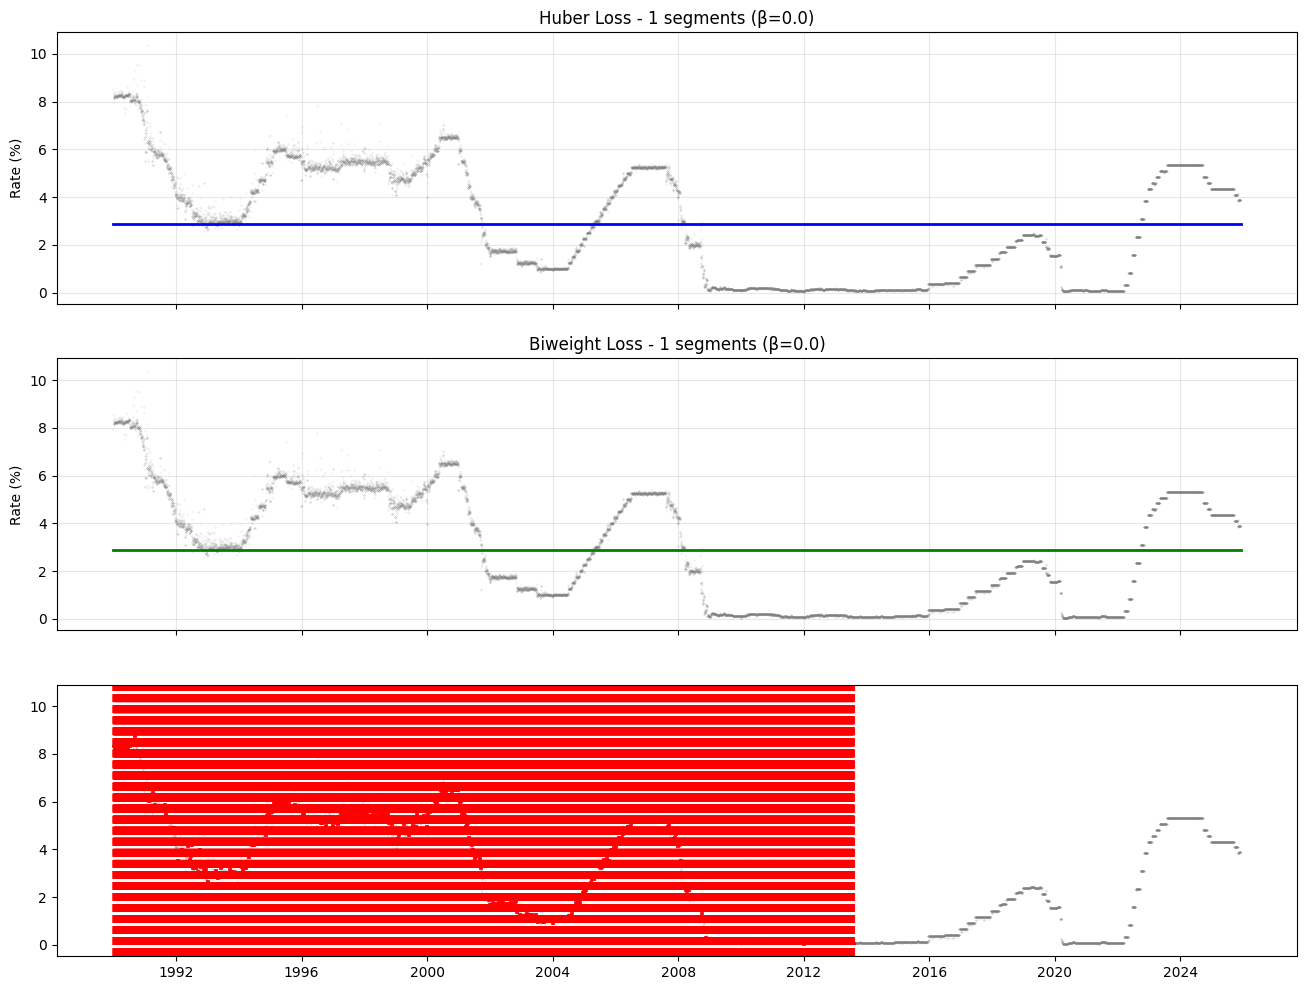

In [ ]:
# Compare all three loss functions on Federal Funds Rate
fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)

loss_configs = [
    ('huber', 'Huber', 'blue', 100),      # (loss, name, color, beta_multiplier)
    ('biweight', 'Biweight', 'green', 50),
    ('l2', 'L2 (Least Squares)', 'red', 200)
]

results_comparison = {}

for ax, (loss, name, color, beta_mult) in zip(axes, loss_configs):
    # Calculate parameters
    beta = compute_penalty_beta(y_dff, loss) * beta_mult
    K = compute_loss_bound_K(y_dff, loss) if loss != 'l2' else None
    
    # Create gamma builder with proper closure
    if loss == 'huber':
        gamma_builder = lambda y_t, t, K=K: gamma_builder_huber(y_t, K, t)
    elif loss == 'biweight':
        gamma_builder = lambda y_t, t, K=K: gamma_builder_biweight(y_t, K, t)
    else:
        gamma_builder = lambda y_t, t: gamma_builder_L2(y_t, t)
    
    # Run RFPOP
    cp_tau, Qt_vals, _ = rfpop_algorithm1_main(list(y_dff), gamma_builder, beta)
    segments = get_segments_from_cp_tau(cp_tau, y_dff)
    
    results_comparison[loss] = {
        'segments': segments,
        'n_changepoints': len(segments) - 1,
        'beta': beta,
        'K': K
    }
    
    # Plot
    ax.plot(dates_dff, y_dff, '.', markersize=0.5, alpha=0.3, color='gray')
    
    for start_idx, end_idx, seg_mean in segments:
        date_start = dates_dff[start_idx]
        date_end = dates_dff[end_idx]
        ax.plot([date_start, date_end], [seg_mean, seg_mean], 
                color=color, linewidth=2)
        if end_idx < len(y_dff) - 1:
            ax.axvline(x=date_end, color=color, linestyle='--', alpha=0.4)
    
    ax.set_ylabel('Rate (%)')
    ax.set_title(f'{name} Loss - {len(segments)} segments (β={beta:.1f})')
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Date')
plt.suptitle('Federal Funds Rate: Comparison of Loss Functions', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Summary table
print("\nSummary of detected changepoints:")
print("=" * 60)
for loss, name, _, _ in loss_configs:
    n_cp = results_comparison[loss]['n_changepoints']
    beta = results_comparison[loss]['beta']
    print(f"{name:25s}: {n_cp:3d} changepoints (β = {beta:.1f})")

## Interpretation: Monetary Policy Regime Changes

The detected changepoints should correspond to major shifts in Federal Reserve monetary policy:

| Period | Policy Regime | Expected Detection |
|--------|--------------|-------------------|
| 1990-1992 | Easing after S&L crisis | Rate cuts |
| 1994-1995 | Preemptive tightening | Sharp rate hikes |
| 1998 | LTCM/Asian crisis response | Brief easing |
| 2001-2003 | Post dot-com easing | Aggressive cuts |
| 2004-2006 | Gradual normalization | "Measured" hikes |
| 2007-2008 | Financial crisis response | Emergency cuts to 0% |
| 2008-2015 | Zero lower bound (ZIRP) | Rates near 0% |
| 2015-2018 | Gradual normalization | Slow rate hikes |
| 2019 | Mid-cycle adjustment | Modest cuts |
| 2020 | COVID-19 emergency | Immediate cut to 0% |
| 2022-2023 | Inflation fighting | Most aggressive hikes in decades |

The robust loss functions (Huber, Biweight) should be better at ignoring daily noise and identifying these structural breaks.